In [21]:
import pandas as pd
import matplotlib as mpl
# ^^^ pyforest auto-imports - don't write above this line
import math
import os
import pandas as pd
import numpy as np
import sklearn.tree

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from xgboost import plot_importance
import lightgbm as lgb

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
mpl.rc('figure', max_open_warning = 0)

# Driver Analysis
- Separated out into suite-cost, suite-compete
- I talked to Chris, and the only file that is here that is complete is the "subsval_subtheme" file, which is all of the data needed for the suite analysis, he is going to be putting together another dataset for app

In [435]:
os.chdir('C:\\Users\\fulto\\Desktop\\Driver Analysis')

In [489]:
#complete suite dataset
suite = pd.read_csv('subsval_subtheme_clf_all_nontext_dimensions.csv')

C:\Users\fulto\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (18,60,62,72,73,76,77,78,79,81,82,83,84,86,103,104,135,157,181,183,185,186,187,188,193,194,195,198,200,202,207,212,213,214,215,216,219,221,222,234,235,236,237,238,242) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [1]:
suite.shape

NameError: name 'suite' is not defined

In [491]:
#create data set for cost
suite_cost = suite[suite['NgramThemePredictions'] == 'cost']

#create data set for compete
suite_compete = suite[suite['NgramThemePredictions'] == 'compete']

In [492]:
#creating data sets that are separated out by consumer, commercial edu, and commercial nonedu
suite_cost_consumer = suite_cost[suite_cost['Feedback_UserType'] == 'Consumer']
suite_cost_commercial = suite_cost[suite_cost['Feedback_UserType'] == 'Commercial']
suite_cost_commercial_edu = suite_cost_commercial[suite_cost_commercial['User_Commercial_HasEducation'] == 1.0]
suite_cost_commercial_nonedu = suite_cost_commercial[suite_cost_commercial['User_Commercial_HasEducation'] == 0.0]

#do the same for compete
suite_compete_consumer = suite_compete[suite_compete['Feedback_UserType'] == 'Consumer']
suite_compete_commercial = suite_compete[suite_compete['Feedback_UserType'] == 'Commercial']
suite_compete_commercial_edu = suite_compete_commercial[suite_compete_commercial['User_Commercial_HasEducation'] == 1.0]
suite_compete_commercial_nonedu = suite_compete_commercial[suite_compete_commercial['User_Commercial_HasEducation'] == 0.0]

In [493]:
def force_to_cat(df):
    
    '''
    this function forces all columns in these dfs to be objects if their number of unique values is low
    
    '''
    
    non_cat = df.select_dtypes(exclude = ['object'])
    for col in non_cat:
        #we have to specify that feedback rating value is not going to be converted
        if (df[col].nunique() < 20) & (col != 'Feedback_RatingValue'):
            df[col] = df[col].astype(str)
            
    return df

In [494]:
#remove columns from data that are missing all or almost all of their data (in this case more than half)
def remove_completely_missing_columns(df, missing_tolerance):
    
    '''this function removes all columns that are missing more than x% all values'''
    
    
    #create missingness df
    missingness = pd.DataFrame(df.isna().sum()).reset_index().rename(columns = {'index':'column', 0:'num_missing'})

    print(f'shape before deleting missing columns: {df.shape}')
    #find columns that are missing all of their data and drop them
    all_missing = []
    for idx, row in missingness.iterrows():
        #filter out columns missing most of their values
        if row[1] > (missing_tolerance * df.shape[0]):
            all_missing.append(row[0])

    #drop these columns
    df = df.drop([x for x in all_missing], axis = 1)

    print(f'shape after deleting missing columns: {df.shape}')
    
    return df

In [499]:
#create list of dfs to iterate through
dfs = [suite_cost_consumer, suite_cost_commercial_edu, suite_cost_commercial_nonedu, suite_compete_consumer, suite_compete_commercial_edu, suite_compete_commercial_nonedu, suite_cost,
      suite_compete]

#remove features with high missingness
dfs = [remove_completely_missing_columns(x, .75) for x in dfs]

#unpack dfs back into single vars
suite_cost_consumer, suite_cost_commercial_edum, suite_cost_commercial_nonedu, suite_compete_consumer, suite_compete_commercial_edu, suite_compete_commercial_nonedu, suite_cost,\
        suite_compete = dfs

shape before deleting missing columns: (3976, 76)
shape after deleting missing columns: (3976, 76)
shape before deleting missing columns: (1051, 323)
shape after deleting missing columns: (1051, 254)
shape before deleting missing columns: (1443, 251)
shape after deleting missing columns: (1443, 251)
shape before deleting missing columns: (437, 76)
shape after deleting missing columns: (437, 76)
shape before deleting missing columns: (315, 255)
shape after deleting missing columns: (315, 255)
shape before deleting missing columns: (384, 251)
shape after deleting missing columns: (384, 251)
shape before deleting missing columns: (6470, 323)
shape after deleting missing columns: (6470, 261)
shape before deleting missing columns: (1136, 323)
shape after deleting missing columns: (1136, 269)


## Dealing with Missingness
- I am going to impute for missing values based on categorical variables for numeric missing features
- for categorical features, I will be imputing the mode
- Feature importances did not change substantially when using different methods for imputing missing values
- missing values were only imputed for top level classifier, the Random Forest, and were left unimputed for the XGBoost, since XGBoost can accept missing data

In [31]:
#imputing missing values
def fill_na(df, feature, filler1, filler2, method = None):
    
    '''
    
    this function fills in missing values with your method of choice (depending on expanding function and specifying method)
    
    '''
    
    if method == 'mode':
    
        df[feature] = df.groupby([filler1, filler2])[f'{feature}'].transform(lambda x: x.replace(np.nan, x.value_counts().index[0]))
        
    if method == 'mean':
        
        df[feature] = df.groupby([filler1, filler2])[f'{feature}'].transform(lambda x: x.replace(np.nan, x.mean()))
        
    return df

#create list of columns with missing values
cost_missing_cols = []

for idx, row in pd.DataFrame(suite_cost.isna().sum()).iterrows():
    if row[0] > 0:
        cost_missing_cols.append(idx)

#get compete missing columns 
compete_missing_cols = []

for idx, row in pd.DataFrame(suite_compete.isna().sum()).iterrows():
    if row[0] > 0:
        compete_missing_cols.append(idx)
        
#fill nas with mode of grouped region and feedback source
for col in cost_missing_cols:
    if suite_cost[col].dtype != 'O':
        suite_cost = fill_na(suite_cost, col, 'User_A13Region', 'Feedback_Source', method = 'mode')
        
#needed to pass errors since some of the groupbys were creating nas
for col in compete_missing_cols:
    if suite_compete[col].dtype != 'O':
        try:
            suite_compete = fill_na(suite_compete, col, 'User_A13Region', 'Feedback_Source', method = 'mode')
        except:
            pass
        
#fill remaining nas with mode of suite compete columns 
suite_compete[compete_missing_cols] = suite_compete[compete_missing_cols].fillna(suite_compete.mode().iloc[0])

#fill remaining nas in suite cost with mode of column
suite_cost[cost_missing_cols] = suite_cost[cost_missing_cols].fillna(suite_cost.mode().iloc[0])

In [32]:
#imputing missing values for consumer, commercial edu, and commercial nonedu

#create list of columns with missing values
consumer_cost_missing_cols = []

for idx, row in pd.DataFrame(suite_cost_consumer.isna().sum()).iterrows():
    if row[0] > 0:
        consumer_cost_missing_cols.append(idx)
        
commercial_edu_cost_missing_cols = []

for idx, row in pd.DataFrame(suite_cost_commercial_edu.isna().sum()).iterrows():
    if row[0] > 0:
        commercial_edu_cost_missing_cols.append(idx)
        
commercial_nonedu_cost_missing_cols = []

for idx, row in pd.DataFrame(suite_cost_commercial_nonedu.isna().sum()).iterrows():
    if row[0] > 0:
        commercial_nonedu_cost_missing_cols.append(idx)

#get compete missing columns 
consumer_compete_missing_cols = []

for idx, row in pd.DataFrame(suite_compete_consumer.isna().sum()).iterrows():
    if row[0] > 0:
        consumer_compete_missing_cols.append(idx)
        
commercial_edu_compete_missing_cols = []

for idx, row in pd.DataFrame(suite_compete_commercial_edu.isna().sum()).iterrows():
    if row[0] > 0:
        commercial_edu_compete_missing_cols.append(idx)
        
commercial_nonedu_compete_missing_cols = []

for idx, row in pd.DataFrame(suite_compete_commercial_nonedu.isna().sum()).iterrows():
    if row[0] > 0:
        commercial_nonedu_compete_missing_cols.append(idx)
        
#fill nas with mode of grouped region and feedback source
for col in consumer_cost_missing_cols:
    if suite_cost_consumer[col].dtype != 'O':
        suite_cost_consumer = fill_na(suite_cost_consumer, col, 'User_A13Region', 'Feedback_Source', method = 'mode')
        
for col in commercial_edu_cost_missing_cols:
    if suite_cost_commercial_edu[col].dtype != 'O':
        try:
            suite_cost_commercial_edu = fill_na(suite_cost_commercial_edu, col, 'User_A13Region', 'Feedback_Source', method = 'mode')
        except:
            pass
#needed to pass errors since some of the groupbys were creating nas
for col in commercial_nonedu_compete_missing_cols:
    if suite_compete_commercial_nonedu[col].dtype != 'O':
        try:
            suite_compete_commercial_nonedu = fill_na(suite_compete_commercial_nonedu, col, 'User_A13Region', 'Feedback_Source', method = 'mode')
        except:
            pass
        
#fill remaining nas with mode of suite compete columns 
suite_compete_consumer[consumer_compete_missing_cols] = suite_compete_consumer[consumer_compete_missing_cols].fillna(suite_compete_consumer.mode().iloc[0])
suite_compete_commercial_edu[commercial_edu_compete_missing_cols] = suite_compete_commercial_edu[commercial_edu_compete_missing_cols].fillna(suite_compete_commercial_edu.mode().iloc[0])
suite_compete_commercial_nonedu[commercial_nonedu_compete_missing_cols] = suite_compete_commercial_nonedu[commercial_nonedu_compete_missing_cols].fillna(suite_compete_commercial_nonedu.mode().iloc[0])

#fill remaining nas in suite cost with mode of column
suite_cost_consumer[consumer_cost_missing_cols] = suite_cost_consumer[consumer_cost_missing_cols].fillna(suite_cost_consumer.mode().iloc[0])
suite_cost_commercial_edu[commercial_edu_cost_missing_cols] = suite_cost_commercial_edu[commercial_edu_cost_missing_cols].fillna(suite_cost_commercial_edu.mode().iloc[0])
suite_cost_commercial_nonedu[commercial_nonedu_cost_missing_cols] = suite_cost_commercial_nonedu[commercial_nonedu_cost_missing_cols].fillna(suite_cost_commercial_nonedu.mode().iloc[0])

# Modeling
- I am going to begin the modeling process by encoding all categorical variables with the mean of the target (NPS)

In [33]:

def target_encoder(df, column, target, index=None, method='mean'):

    """

    Target-based encoding is numerization of a categorical variables via the target variable. Main purpose is to deal

    with high cardinality categorical features without exploding dimensionality. This replaces the categorical variable

    with just one new numerical variable. Each category or level of the categorical variable is represented by a

    summary statistic of the target for that level.



    Args:

        df (pandas df): Pandas DataFrame containing the categorical column and target.

        column (str): Categorical variable column to be encoded.

        target (str): Target on which to encode.

        index (arr): Can be supplied to use targets only from the train index. Avoids data leakage from the test fold

        method (str): Summary statistic of the target. Mean, median or std. deviation.



    Returns:

        arr: Encoded categorical column.



    """



    index = df.index if index is None else index # Encode the entire input df if no specific indices is supplied



    if method == 'mean':

        encoded_column = df[column].map(df.loc[index].groupby(column)[target].mean())

    elif method == 'median':

        encoded_column = df[column].map(df.loc[index].groupby(column)[target].median())

    elif method == 'std':

        encoded_column = df[column].map(df.loc[index].groupby(column)[target].std())

    else:

        raise ValueError("Incorrect method supplied: '{}'. Must be one of 'mean', 'median', 'std'".format(method))



    return encoded_column

In [34]:
#updated this for app from suite, just had to add in a couple of columns that weren't in this originally
def throw_out_useless_features(df):
    
    '''
    
    There are several features that Manoj doesn't want in the analysis (i.e. locators since every geo feature rolls up to region), so I am creating a function
    that takes care of this since I have to do it so often
    
    '''
    
    print(f'Shape before: {df.shape}')
    #get rid of features that we know from Surface analysis that Manoj definitely does not want in the model
    features = pd.DataFrame(df.columns).rename(columns = {0:'features'})

    features = features[~features['features']\
    .str.contains('Feedback_ID|Date|Feedback_Verbatim|Feedback_SurveyName|Scale|Locale|Feedback_SurveyFlightName|'\
                  'IsValid|Language|SourceVerbatim|Ocv|Country|State|OsName|User_SurveyId|Enabled')]

    features = features[~features['features']\
    .str.contains('User_CommercialTenantName|MSSalesTopParent|Market|ResellerName|Tenant_Name|City|'\
                  'OrgName|OrgId|Unnamed|TenantName|TenantID|OfferList|Time|LastUpdated|Feedback_Platform')]

    features = features[~features['features']\
    .str.contains('Postal|Currency|SubsidiaryName|SubRegion|Cluster|RegionName|AreaName|Big|VerticalName|'\
                  'SegmentName|GroupName|ATUName|Territory|TenantId|Month|Rating_y|App_y')]

    features = features[~features['features']\
    .str.contains('CompanyName|GPName|SignupRegion|AreaName|TeamName|Verbatim_Details|Verbatim_Themes|NPS|'\
                  'Fork|NgramThemePrediction|DistrictId|Since|Start|End|Ngrams|Rating_x')]

    #subset the df 
    df = df[[x for x in features['features']]]
    
    print(f'Shape after throwing them out: {df.shape}')
    
    return df

In [172]:
#transform datasets with the above function
suite_cost = throw_out_useless_features(suite_cost)
suite_compete = throw_out_useless_features(suite_compete)

Shape before: (6470, 261)
Shape after throwing them out: (6470, 174)
Shape before: (1136, 269)
Shape after throwing them out: (1136, 176)


In [173]:
suite_cost_consumer = throw_out_useless_features(suite_cost_consumer)
suite_cost_commercial_edu = throw_out_useless_features(suite_cost_commercial_edu)
suite_cost_commercial_nonedu = throw_out_useless_features(suite_cost_commercial_nonedu)
suite_compete_consumer = throw_out_useless_features(suite_compete_consumer)
suite_compete_commercial_edu = throw_out_useless_features(suite_compete_commercial_edu)
suite_compete_commercial_nonedu = throw_out_useless_features(suite_compete_commercial_nonedu)

Shape before: (3976, 44)
Shape after throwing them out: (3976, 44)
Shape before: (1051, 164)
Shape after throwing them out: (1051, 164)
Shape before: (1443, 163)
Shape after throwing them out: (1443, 163)
Shape before: (437, 44)
Shape after throwing them out: (437, 44)
Shape before: (315, 165)
Shape after throwing them out: (315, 165)
Shape before: (384, 163)
Shape after throwing them out: (384, 163)


In [37]:
#split data into feature and label sets
suite_cost_features = suite_cost.drop(['Feedback_RatingValue', 'Feedback_Rating'], axis = 1)
suite_cost_labels = suite_cost['Feedback_RatingValue']

suite_compete_features = suite_compete.drop(['Feedback_RatingValue', 'Feedback_Rating'], axis = 1)
suite_compete_labels = suite_compete['Feedback_RatingValue']

In [38]:
#split data into feature and label sets for consumer, commercial edu, and commercian nonedu
suite_cost_consumer_features = suite_cost_consumer.drop(['Feedback_RatingValue', 'Feedback_Rating'], axis = 1)
suite_cost_consumer_labels = suite_cost_consumer['Feedback_RatingValue']


suite_cost_commercial_edu_features = suite_cost_commercial_edu.drop(['Feedback_RatingValue',  'Feedback_Rating'], axis = 1)
suite_cost_commercial_edu_labels = suite_cost_commercial_edu['Feedback_RatingValue']


suite_cost_commercial_nonedu_features = suite_cost_commercial_nonedu.drop(['Feedback_RatingValue', 'Feedback_Rating'], axis = 1)
suite_cost_commercial_nonedu_labels = suite_cost_commercial_nonedu['Feedback_RatingValue']


suite_compete_consumer_features = suite_compete_consumer.drop(['Feedback_RatingValue', 'Feedback_Rating'], axis = 1)
suite_compete_consumer_labels = suite_compete_consumer['Feedback_RatingValue']


suite_compete_commercial_edu_features = suite_compete_commercial_edu.drop(['Feedback_RatingValue', 'Feedback_Rating'], axis = 1)
suite_compete_commercial_edu_labels = suite_compete_commercial_edu['Feedback_RatingValue']


suite_compete_commercial_nonedu_features = suite_compete_commercial_nonedu.drop(['Feedback_RatingValue', 'Feedback_Rating'], axis = 1)
suite_compete_commercial_nonedu_labels = suite_compete_commercial_nonedu['Feedback_RatingValue']

In [39]:
def find_important_features(features, labels, model = None, encode = False):
    
    '''
    
    This function takes a set of features and labels as arguments and runs them through a tree-based model of your choice, returning feature importances, you 
    can choose to target encode your categorical features by setting the "encode" argument to "True", this helps with high cardinality and not exploding
    the number of features, which will happen when dummy coding, its also a good way to improve accuracy of models often
    
    Arguments: features, labels, model = (either 'random forest' or 'xgboost'), encode = True/False
    
    '''
    
    #create train/test split to feed into Random Forest, we are using this algorithm to filter out important experiments for NPS
    #X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2)

    #if encoder is set to tru in the args, take the features and mean target encode them so that the data can be fed into the algorithm
    if encode == True:
        
        combined = pd.concat([features, labels], axis = 1)
        
        for col in combined.columns:
            
            if combined[col].dtype == 'O':
                
                combined[col] = target_encoder(combined, column = col, target = 'Feedback_RatingValue', index = None, method = 'mean')
    
                features = combined.drop('Feedback_RatingValue', axis = 1)
    
                labels = combined['Feedback_RatingValue']
    
    # run gridsearch for best Random Forest params, in this case I am using RandomizedSearchCV rather than GridsearchCV, which has been shown to have similar
    # performance to Gridsearch, but takes significantly less time 
    if model == 'xgboost':
        
        #fill in missing data so xgboost knows what is missing
        features.fillna(-1234, inplace = True)
        
        import xgboost as xgb
        model = xgb.XGBClassifier(n_estimators=500,max_depth=9,learning_rate=0.05,subsample=0.9, colsample_bytree=0.9, missing = -1234) #xgboost deals with missing data here
        param_grid = {'n_estimators': [50, 100, 250, 500, 750, 1000, 1250, 1500],#'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth': [2,5,10,25,None]}

        CV_xg = RandomizedSearchCV(estimator=model, n_jobs=-1, param_distributions=param_grid, verbose=10, scoring='neg_log_loss',cv= 5)
        CV_xg.fit(features, labels)
    
        n_estimators, max_depth = CV_xg.best_params_.values()

        xg = xgb.XGBClassifier(random_state = 0, n_estimators = n_estimators, max_depth = max_depth, learning_rate=0.05,subsample=0.9, 
                               colsample_bytree=0.9, missing = -1234).fit(features, labels)

        #getting feature importances greatest to least
        learners = xg.feature_importances_.argsort()[::-1]
    
        features = pd.DataFrame(features.columns[learners], xg.feature_importances_[learners])
    
        #only using features that had more than .015 splits
        feature_importances = features[features.index>0.005]
        
        return feature_importances, xg
    
    elif model == 'random forest':
        
        model = RandomForestClassifier(n_estimators=500,max_depth=10)
        param_grid = {'n_estimators': [50, 100, 250, 500, 750, 1000, 1250, 1500],#'max_features': ['auto', 'sqrt', 'log2'],
                  'max_depth': [2,5,10,25,None]}
        
        CV_rf = RandomizedSearchCV(estimator=model, n_jobs=-1, param_distributions=param_grid, verbose=10, scoring='neg_log_loss',cv= 5)
        CV_rf.fit(features, labels)
        
        n_estimators, max_depth = CV_rf.best_params_.values()
        
        rf = RandomForestClassifier(random_state = 0, n_estimators = n_estimators, max_depth = max_depth).fit(features, labels)
        
        #getting feature importances greatest to least
        learners = rf.feature_importances_.argsort()[::-1]
    
        features = pd.DataFrame(features.columns[learners], rf.feature_importances_[learners])
    
        #only using features that had more than .015 splits
        feature_importances = features[features.index>0.005].rename(columns = {0:'Features'})
    
        return feature_importances

In [41]:
#find important features using Random Forest
suite_cost_important_features = find_important_features(suite_cost_features, suite_cost_labels, model = 'random forest', encode = True)
suite_compete_important_features = find_important_features(suite_compete_features, suite_compete_labels, model = 'random forest', encode = True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.9s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   23.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   58.4s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.4min remaining:   17.7s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  2.2min remaining:    8.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  2.2min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    9.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   22.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   36.5s remaining:    7.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   38.0s remaining:    2.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   40.6s finished


In [1685]:
def get_top_10_feats(df, app_or_suite = None, subset = None):
    
    '''
    
    This function takes an input of a dataframe of feature importances from the modeling function, then it subsets the df2 for those features only, returning a 
    df of 10 features and NPS scores
    
    '''
    
    top_10 = [x for x in df.iloc[:10, 0].reset_index()['Features']]
    
    new_df = app_or_suite[app_or_suite['NgramThemePredictions'] == subset]
    
    new_df = pd.concat([new_df[top_10], new_df['Feedback_RatingValue']], axis = 1)
    
    return new_df

## Getting Important Features for Suite Cost/Compete 

In [1324]:
#using function to pull top 10 features with respect to splits
suite_cost_top_10_features = get_top_10_feats(suite_cost_important_features, app_or_suite = suite, subset = 'cost')
suite_compete_top_10_features = get_top_10_feats(suite_compete_important_features, app_or_suite = suite, subset = 'compete')

## Running Same Analysis for Consumer, Commercial Edu, and Commercial Non-Edu Separated

In [1686]:
#running same analysis for consumer, comercial edu, and commercial nonedu separated out
suite_cost_consumer_important_features = find_important_features(suite_cost_consumer_features, suite_cost_consumer_labels, model = 'random forest', encode = True)
suite_cost_commercial_edu_important_features = find_important_features(suite_cost_commercial_edu_features, suite_cost_commercial_edu_labels, model = 'random forest', encode = True)
suite_cost_commercial_nonedu_important_features = find_important_features(suite_cost_commercial_nonedu_features, suite_cost_commercial_nonedu_labels, model = 'random forest', encode = True)
suite_compete_consumer_important_features = find_important_features(suite_compete_consumer_features, suite_compete_consumer_labels, model = 'random forest', encode = True)
suite_compete_commercial_edu_important_features = find_important_features(suite_compete_commercial_edu_features, suite_compete_commercial_edu_labels, model = 'random forest', encode = True)
suite_compete_commercial_nonedu_important_features = find_important_features(suite_compete_commercial_nonedu_features, suite_compete_commercial_nonedu_labels, model = 'random forest', encode = True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   20.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   46.2s remaining:   10.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   50.1s remaining:    3.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   52.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   14.0s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   17.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   18.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   23.6s remaining:    5.1s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   27.4s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   28.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    4.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    9.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   19.8s remaining:    4.3s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   22.9s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   23.5s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    9.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   17.5s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   23.1s remaining:    5.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   25.1s remaining:    1.5s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   25.7s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    9.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   13.7s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   15.0s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   15.5s finished


## Important Features for Suite, Split by Consumer, Commercial Edu, and Commercial Non-Edu

In [1687]:
#using function to pull top 10 features with respect to splits
suite_cost_consumer_top_10_features = get_top_10_feats(suite_cost_consumer_important_features, app_or_suite = suite, subset = 'cost')
suite_cost_commercial_edu_top_10_features = get_top_10_feats(suite_cost_commercial_edu_important_features, app_or_suite = suite, subset = 'cost')
suite_cost_commercial_nonedu_top_10_features = get_top_10_feats(suite_cost_commercial_nonedu_important_features, app_or_suite = suite, subset = 'cost')
suite_compete_consumer_top_10_features = get_top_10_feats(suite_compete_consumer_important_features, app_or_suite = suite, subset = 'compete')
suite_compete_commercial_edu_top_10_features = get_top_10_feats(suite_compete_commercial_edu_important_features, app_or_suite = suite, subset = 'compete')
suite_compete_commercial_nonedu_top_10_features = get_top_10_feats(suite_compete_commercial_nonedu_important_features, app_or_suite = suite, subset = 'compete')

# Visualizing Suite Cost and Suite Compete Feature Importances
- First, I will create feature importances plots with xgboost, then....
- I am going to be creating plots for NPS scores 
- Plots will be separated by continuous and categorical
- Plots will be showing average NPS scores in general

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   52.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 47.9min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 48.8min remaining: 10.7min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 53.4min remaining:  3.4min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 53.6min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

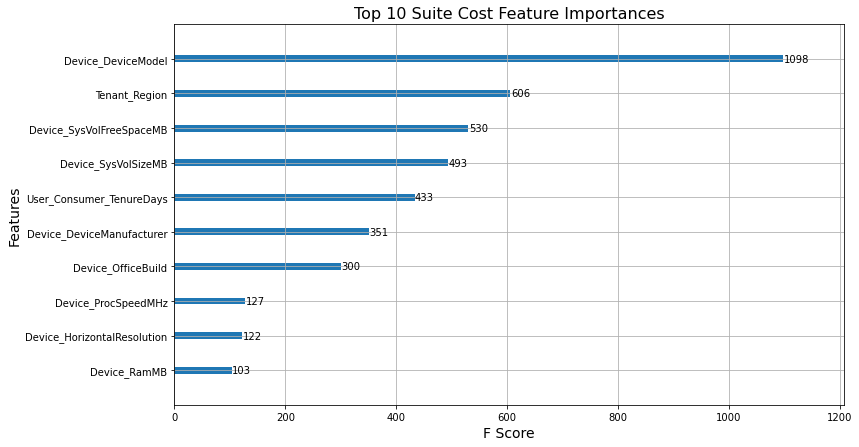

In [1344]:
suite_cost_feats, suite_cost_important_features_model = find_important_features(suite_cost_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                                suite_cost_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)


#plot the features
plt.figure(figsize = (12, 10))
ax = plot_importance(suite_cost_important_features_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 Suite Cost Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   26.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   31.0s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   41.2s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   48.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.2min remaining:   16.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.4min remaining:    5.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.5min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

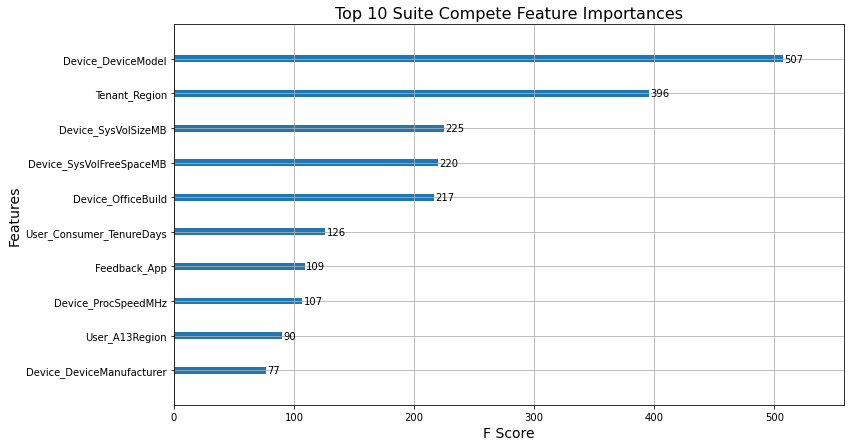

In [1347]:
suite_compete_feats, suite_compete_important_features_model = find_important_features(suite_compete_top_10_features.drop('Feedback_RatingValue', axis = 1), 
                                                                                suite_compete_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)


#plot the features
plt.figure(figsize = (12, 10))
ax = plot_importance(suite_compete_important_features_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 Suite Compete Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

In [456]:
#set up suite cost feature importance plot with %s instead of # of splits
suite_cost_feats = ['Device_DeviceModel', 'Tenant_Region', 'Device_SysVolFreeSpaceMB', 'Device_SysVolSizeMB', 'User_Consumer_TenureDays', 'Device_DeviceManufacturer',
                   'Device_OfficeBuild', 'Device_ProcSpeedMHz', 'Device_HorizontalResolution', 'Device_RamMB']
suite_cost_splits = [1090, 606, 530, 493, 433, 351, 300, 127, 122, 103]

suite_compete_feats = ['Device_DeviceModel', 'Tenant_Region', 'Device_SysVolSizeMB', 'Device_SysVolFreeSpaceMB', 'Device_OfficeBuild', 'User_Consumer_TenureDays', 
                      'Feedback_App', 'Device_ProcSpeedMHz', 'User_A13Region', 'Device_DeviceManufacturer']
suite_compete_splits = [507, 396, 225, 220, 217, 126, 109, 107, 90, 77]

suite_cost_feats_importances = pd.DataFrame({'features':suite_cost_feats, 'suite_cost_splits':suite_cost_splits, 'split_%':[x/sum(suite_cost_splits) for x in suite_cost_splits]})
suite_compete_feats_importances = pd.DataFrame({'features':suite_compete_feats, 'suite_compete_splits':suite_compete_splits,
                                                'split_%':[x/sum(suite_compete_splits) for x in suite_compete_splits]})

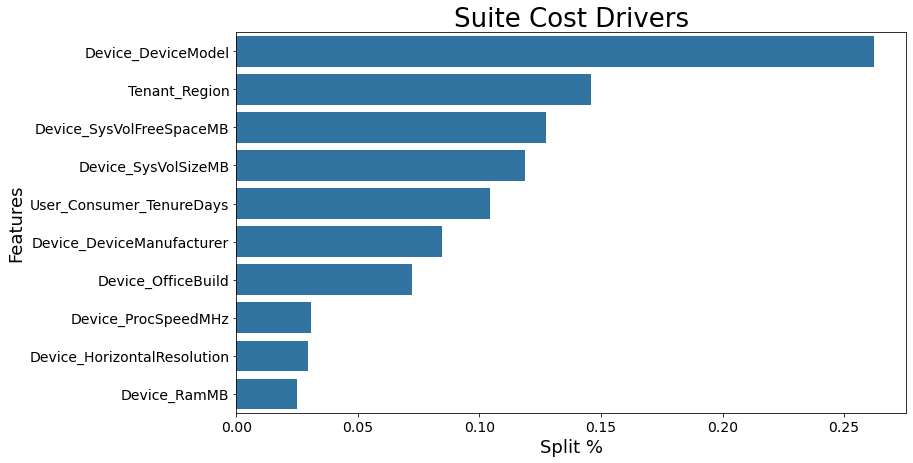

In [472]:
#plot barplots for feature importances
plt.figure(figsize = (12, 7))
sns.barplot(y = 'features', x = 'split_%', data = suite_cost_feats_importances, color = 'tab:blue')
plt.title('Suite Cost Drivers', fontsize = 26)
plt.xlabel('Split %', fontsize = 18)
plt.ylabel('Features', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

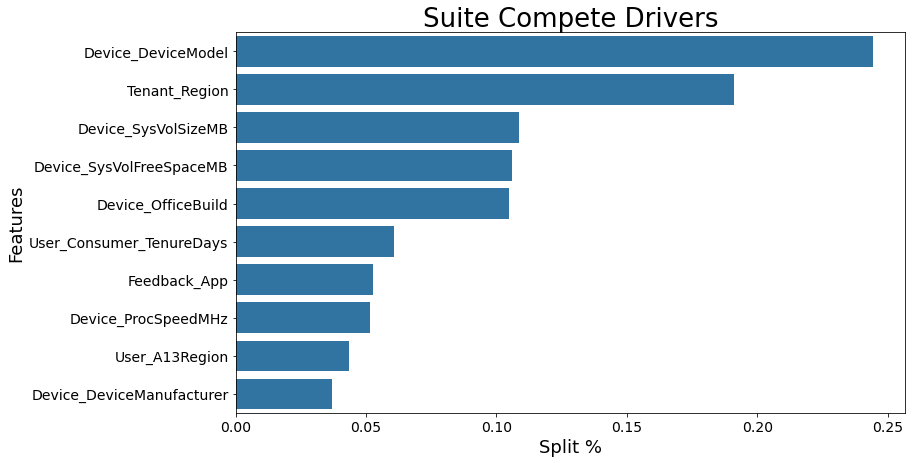

In [476]:
#plot barplots for feature importances
plt.figure(figsize = (12, 7))
sns.barplot(y = 'features', x = 'split_%', data = suite_compete_feats_importances, color = 'tab:blue')
plt.title('Suite Compete Drivers', fontsize = 26)
plt.xlabel('Split %', fontsize = 18)
plt.ylabel('Features', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

### Plotting Functions
- I have written functions to take care of all of the plotting
- The first function plots categorical features, the second plots numeric features

In [224]:
def plot_cats(df, nps, subset = None):
    
    '''
    
    This function takes a df as an argument, it plots categorical features, if a categorical feature has more than 40 levels then it simply
    performs a groupby and chooses the top 20 from that feature's value counts, indications of this will be in the title of the resulting plot
    
    '''
    
    #loop through and plot each cat feature with less than 40 levels
    for feature in df.columns:
        
        if (df[feature].nunique() < 40) & (feature != 'Feedback_RatingValue') & (df[feature].dtype == 'O'): # don't want to plot feedback rating value
        
            plt.figure(figsize = (20, 7))
        
            df.groupby(df[feature]).Feedback_RatingValue.mean().sort_values().plot(kind = 'bar')
        
            plt.title(f'NPS by {feature}', fontsize = 16)
        
            plt.xlabel(f'{feature}', fontsize = 14)
        
            plt.ylabel('Average NPS Score', fontsize = 14)
            
            plt.axhline(y=nps, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall
            
            #if a feature has more than 20 levels, rotate this much    
            if df[feature].nunique() > 20:
            
                plt.xticks(rotation = 60)
            else:
            
                plt.xticks(rotation = 20)
            
            #add annotated legend depending on if data is suite or app
            if subset == 'suite':
                
                plt.legend(labels = ['2020 AVG Suite NPS'], fontsize = 14)
            
            elif subset == 'app':
                
                plt.legend(labels = ['2020 Combined App NPS'], fontsize = 14)
                
        elif (df[feature].nunique() > 40) & (df[feature].dtype == 'O'):
            
            #plotting top 20 device models by NPS score 
            top_20 = pd.DataFrame(df[f'{feature}'].value_counts().nlargest(20)).index
            
            #creating df for levels in the top 20
            plt_df = df[df[f'{feature}'].isin(top_20)]
            
            #creating figure size
            plt.figure(figsize = (20, 7))
            
            #plotting on a categorical variable using groupby
            plt_df.groupby(f'{feature}').Feedback_RatingValue.mean().sort_values().plot(kind = 'bar')
            
            #create title
            plt.title(f'NPS by Top 20 {feature}', fontsize = 16)
            
            #create y label
            plt.ylabel('Average NPS Score', fontsize = 14)
            
            #create x label
            plt.xlabel(f'{feature}', fontsize = 14)
            
            plt.axhline(y=nps, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall
            
            if subset == 'suite':
            
                plt.legend(labels = ['2020 AVG Suite NPS'], fontsize = 14)
                
            elif subset == 'app':
                
                plt.legend(labels = ['2020 AVG Combined App NPS'], fontsize = 14)
            
            #setting x tick rotation for longer names to be visible and not overlap
            plt.xticks(rotation = 65);

In [109]:
def plot_nums(nps, df, feature, subset, title, xlabel, bins, labels = None, method = None):
    
    '''
    
    This function takes a df, feature, binsize (or individual bins when using cut), labels (again, if using cut pass a list of labels), and method
    It then plots the feature accordingly
    
    '''
    
    #if you are going to use qcut
    if method is 'qcut':
            
        plt.figure(figsize = (15, 7))
                
        ax = df.groupby(pd.qcut(df[feature], bins, duplicates = 'drop')).Feedback_RatingValue.mean().plot(kind = 'bar')
                
        plt.title(title, fontsize = 16)
                
        plt.xlabel(xlabel, fontsize = 14)
                
        plt.ylabel('Average NPS Score')
        
        plt.axhline(y=nps, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall
        
        if subset == 'suite':
            
            ax.legend(labels = ['2020 AVG Suite NPS'], fontsize = 14)
            
        elif subset == 'app':
            
            ax.legend(labels = ['2020 AVG App NPS'], fontsize = 14)
            
        plt.xticks(list(range(0, bins)), labels, rotation = 50);
        
        #if you are going to use cut (for descretizing features with greater control over bins)
    elif method is 'cut':
            
        plt.figure(figsize = (15, 7))
                
        ax = df.groupby(pd.cut(df[feature], bins = bins, labels = labels)).Feedback_RatingValue.mean().plot(kind = 'bar')
                
        plt.title(title, fontsize = 16)
                
        plt.xlabel(xlabel, fontsize = 14)
                
        plt.ylabel('Average NPS Score', fontsize = 14)
        
        plt.axhline(y=nps, color = 'tab:blue', linestyle = '--', linewidth = 2)#create lineplot for NPS trend overall
        
        if subset == 'suite':
            
            ax.legend(labels = ['2020 AVG Suite NPS'], fontsize = 14)
        
        elif subset == 'app':
            
            ax.legend(labels = ['2020 AVG App NPS'], fontsize = 14)
            
        plt.xticks(rotation = 20);

## Plotting Suite Compete Features
- I am going to plot the top 20 levels of any categorical variable that has high cardinality

In [ ]:
#Here is the SQL query I used in Kusto
SELECT DATEPART(year, Feedback_DateTime) AS Year,
AVG(CAST(Feedback_RatingValue AS FLOAT)) AS Avg_NPS FROM EndUserO365NPS()
GROUP BY DATEPART(year, Feedback_DateTime)
ORDER BY Year

### Suite Compete Categorical Feature Plots

In [1356]:
suite_compete_top_10_features.dtypes

Device_DeviceModel            object
Device_OfficeBuild            object
Device_SysVolSizeMB          float64
Tenant_Region                 object
Device_SysVolFreeSpaceMB     float64
Device_ProcSpeedMHz          float64
Device_DeviceManufacturer     object
User_A13Region                object
User_Consumer_TenureDays     float64
Feedback_App                  object
Feedback_RatingValue           int64
dtype: object

In [43]:
#just use this if the kernel dies to avoid having to run models again, no need to
suite_compete_top_10_features = suite_compete[['Device_DeviceModel', 'Device_OfficeBuild', 'Device_SysVolSizeMB', 'Tenant_Region', 'Device_SysVolFreeSpaceMB',
                                              'Device_ProcSpeedMHz', 'Device_DeviceManufacturer', 'User_A13Region', 'User_Consumer_TenureDays', 'Feedback_App',
                                              'Feedback_RatingValue']]

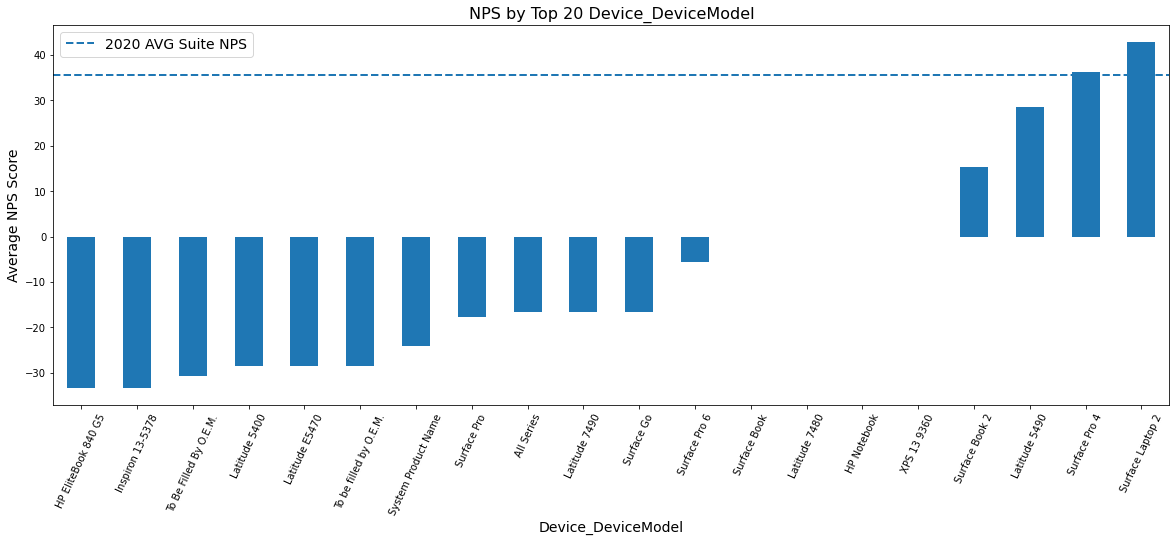

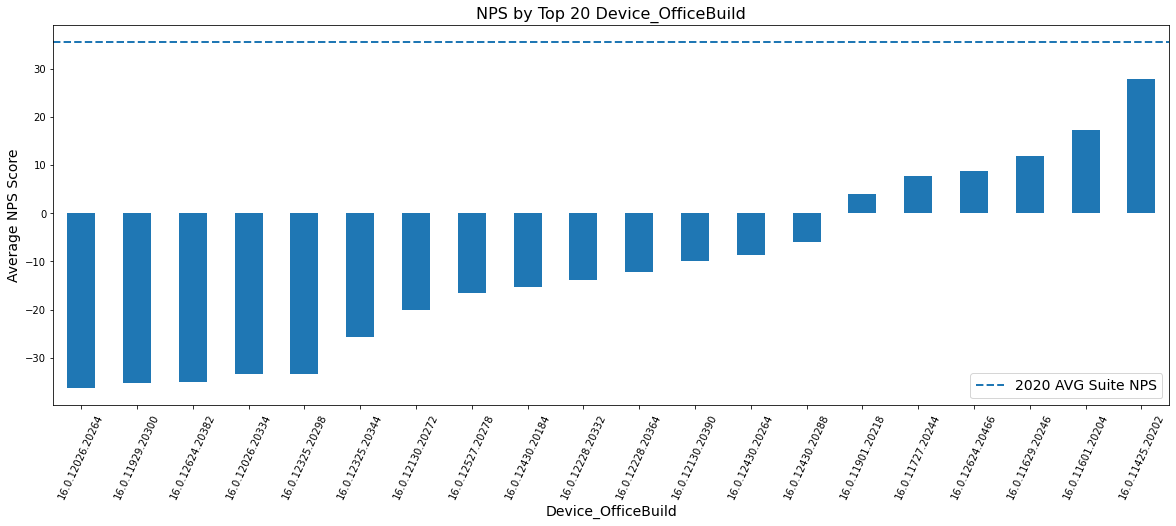

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37117 missing from curre

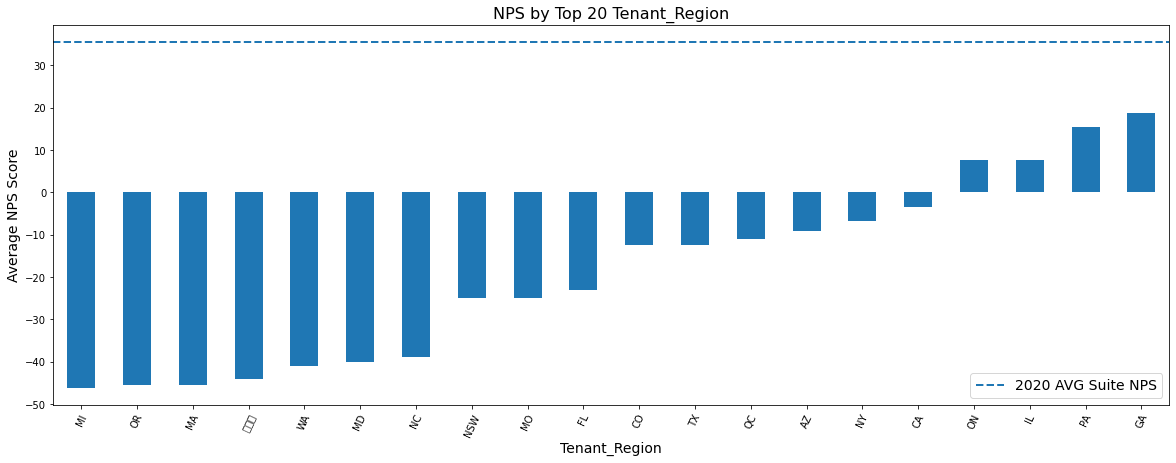

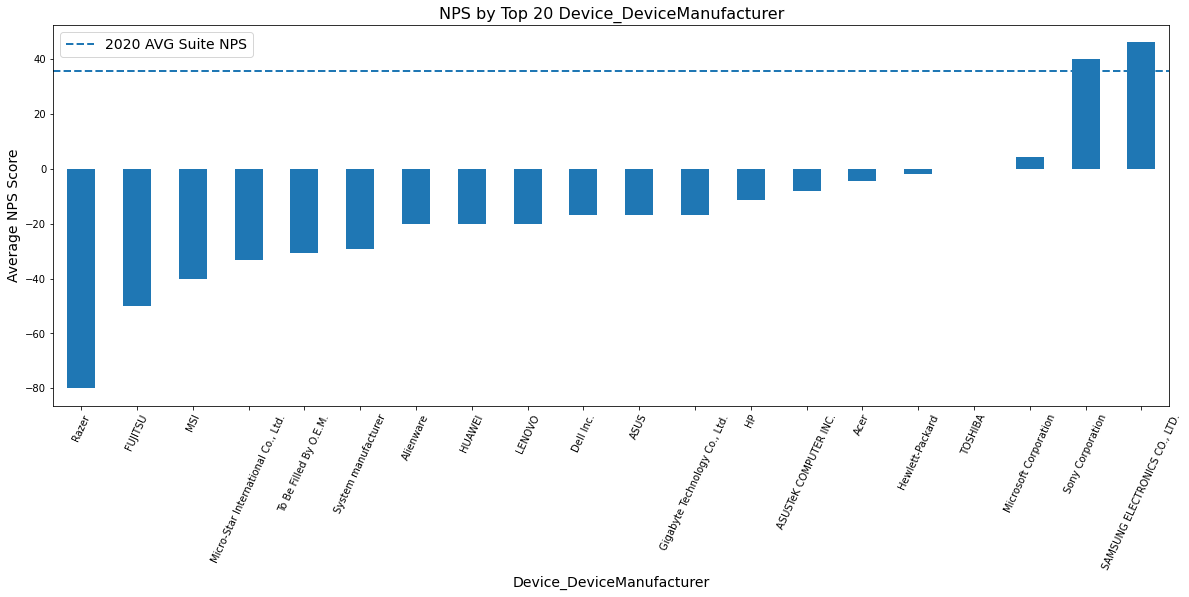

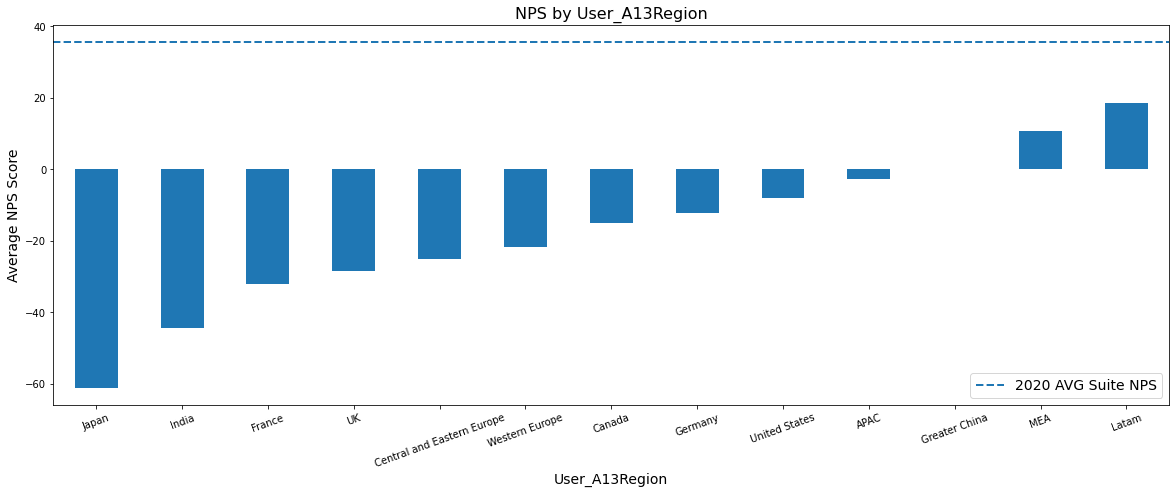

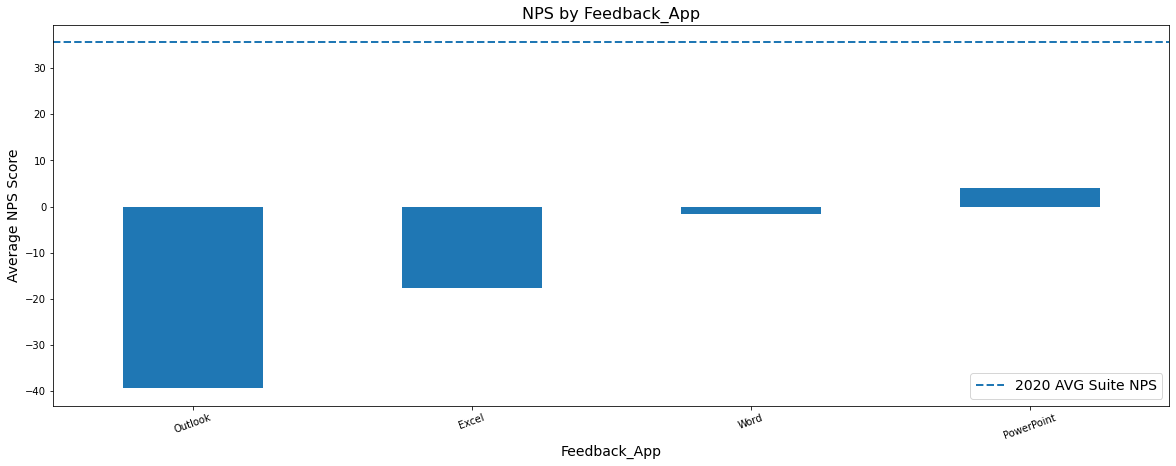

In [225]:
plot_cats(suite_compete_top_10_features, 35.5787584399305, 'suite')

### Suite Compete Numeric Feature Plots

In [1358]:
suite_compete_top_10_features.dtypes

Device_DeviceModel            object
Device_OfficeBuild            object
Device_SysVolSizeMB          float64
Tenant_Region                 object
Device_SysVolFreeSpaceMB     float64
Device_ProcSpeedMHz          float64
Device_DeviceManufacturer     object
User_A13Region                object
User_Consumer_TenureDays     float64
Feedback_App                  object
Feedback_RatingValue           int64
dtype: object

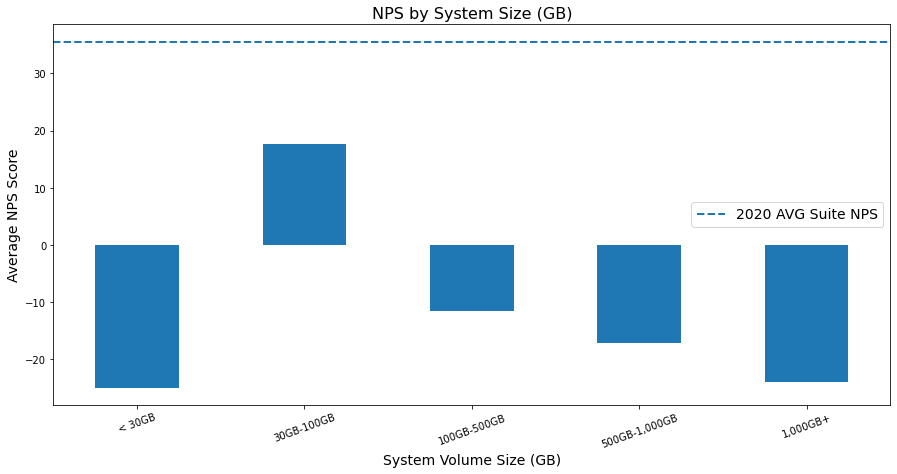

In [75]:
#plotting System Size MB
plot_nums(35.5787584399305, suite_compete_top_10_features, 'Device_SysVolSizeMB', 'suite',
          'NPS by System Size (GB)', 'System Volume Size (GB)', bins = [0, 30000, 100000, 500000, 1000000, 1000000000000000], 
          labels= ['< 30GB', '30GB-100GB', '100GB-500GB', '500GB-1,000GB', '1,000GB+'], method = 'cut')

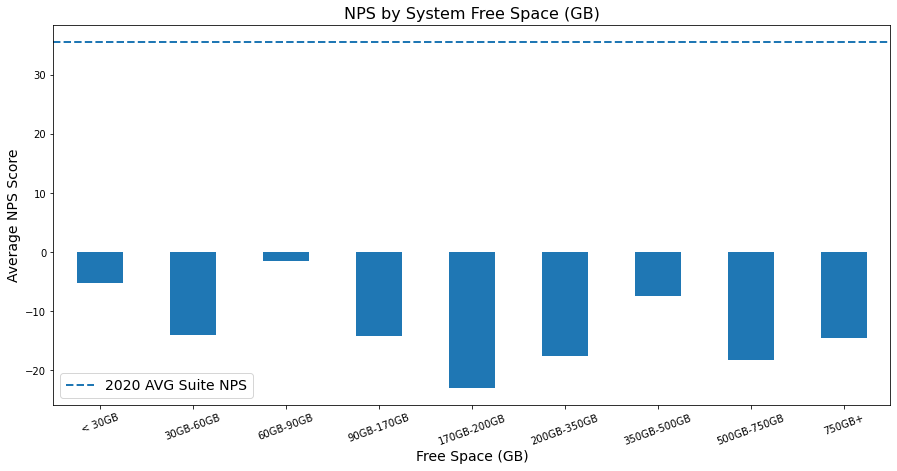

In [81]:
#plotting SysVolFreeSpace
plot_nums(35.5787584399305, suite_compete_top_10_features, 'Device_SysVolFreeSpaceMB','suite', 'NPS by System Free Space (GB)', 'Free Space (GB)',
          bins = [0, 30000, 60000, 90000, 170000, 200000, 350000, 500000, 750000, 10000000000000], 
          labels = ['< 30GB', '30GB-60GB', '60GB-90GB', '90GB-170GB', '170GB-200GB', '200GB-350GB', '350GB-500GB', '500GB-750GB', '750GB+'], method = 'cut')

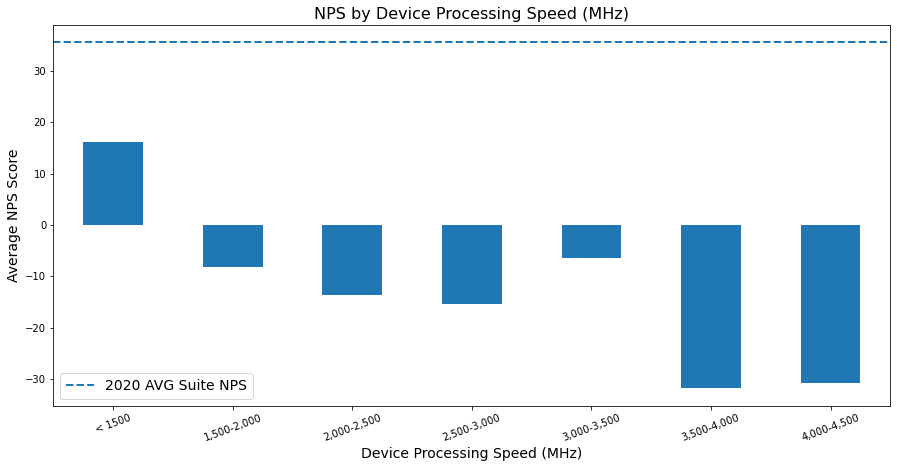

In [110]:
#plotting Device Processing Speed
plot_nums(35.5787584399305, suite_compete_top_10_features, 'Device_ProcSpeedMHz', 'suite', 'NPS by Device Processing Speed (MHz)', 'Device Processing Speed (MHz)', 
         bins = [0, 1500, 2000, 2500, 3000, 3500, 4000, 4500], labels = ['< 1500', '1,500-2,000', '2,000-2,500', '2,500-3,000', '3,000-3,500',
                                                                        '3,500-4,000', '4,000-4,500'], method = 'cut')

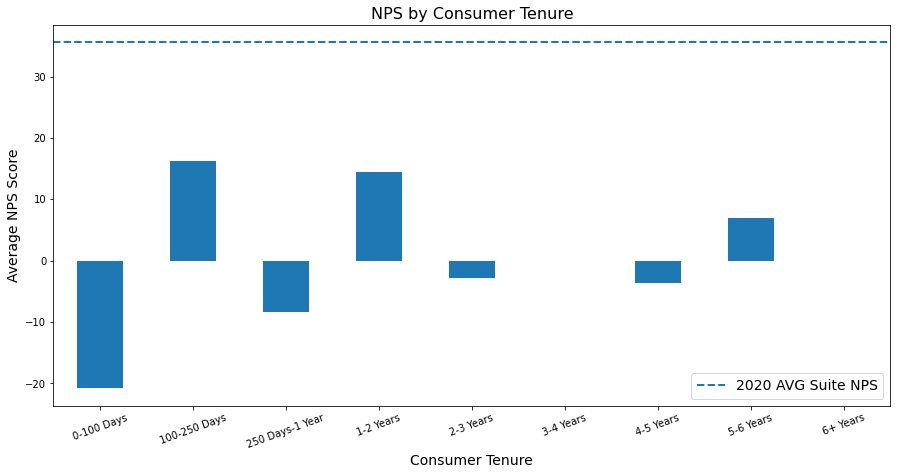

In [111]:
plot_nums(35.5787584399305, suite_compete_top_10_features, 'User_Consumer_TenureDays', 'suite', 'NPS by Consumer Tenure', 'Consumer Tenure', 
          bins = [0, 100, 250, 365, 730, 1095, 1460, 1825, 2190, 2571], labels = ['0-100 Days', '100-250 Days', 
                    '250 Days-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5-6 Years', '6+ Years'], method = 'cut')

In [86]:
def get_build_age(df, subset = None):
    
    '''
    
    This function creates a df that contains the top 20 Office Builds and their respective mean NPS, you can use this df to creat eht barplot below for a presentation
    
    '''
    
    office_build = df[df['NgramThemePredictions'] == subset]
    
    top_builds = pd.DataFrame(office_build['Device_OfficeBuild'].value_counts().nlargest(20)).reset_index().rename(columns = {'index':'build', 'Device_OfficeBuild':'values'})['build']
    
    all_builds = pd.DataFrame(df.groupby('Device_OfficeBuild').Feedback_RatingValue.mean()).reset_index()
    
    top_builds_nps = all_builds[all_builds['Device_OfficeBuild'].isin(top_builds)]
    
    top_builds_nps.reset_index(drop = True, inplace = True)
    
    return top_builds_nps

In [87]:
#get office build age df, look up online
build_age_df= get_build_age(suite, 'compete')
build_age_df

Device_OfficeBuild  Feedback_RatingValue
0    16.0.11425.20202             21.739130
1    16.0.11601.20204             14.258002
2    16.0.11629.20246             19.741935
3    16.0.11727.20244             21.174478
4    16.0.11901.20218             22.684792
5    16.0.11929.20300             24.051677
6    16.0.12026.20264             29.036635
7    16.0.12026.20334             25.050641
8    16.0.12130.20272             25.467100
9    16.0.12130.20390             28.643048
10   16.0.12228.20332             29.247202
11   16.0.12228.20364             29.620353
12   16.0.12325.20298             25.728373
13   16.0.12325.20344             30.499076
14   16.0.12430.20184             29.031130
15   16.0.12430.20264             29.160305
16   16.0.12430.20288             27.965465
17   16.0.12527.20278             32.749054
18   16.0.12624.20382             36.682316
19   16.0.12624.20466             35.080752

In [88]:
months_old = [14, 13, 12, 11, 10, 9, 9, 8, 8, 7, 6, 6, 5, 5, 5, 4, 4, 3, 3, 2]

In [89]:
build_age_df['Months_Old'] = months_old

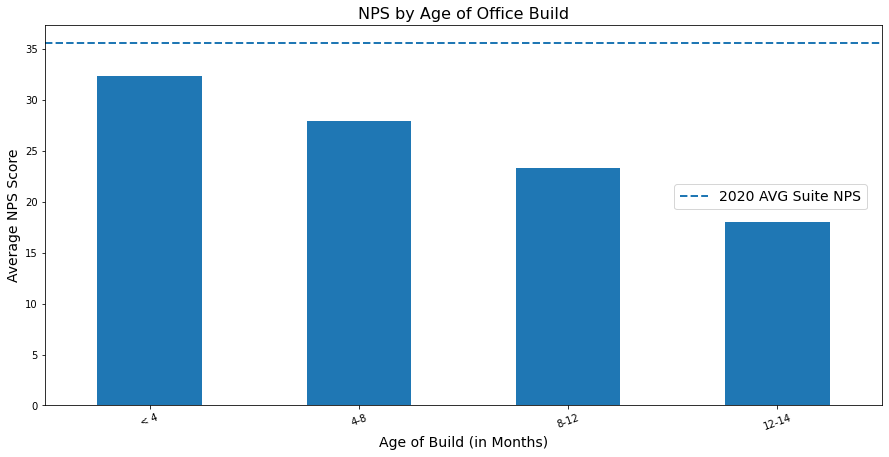

In [135]:
plot_nums(35.5787584399305, build_age_df, 'Months_Old', 'suite', 'NPS by Age of Office Build', 'Age of Build (in Months)', 
          bins = [0, 4, 8, 12, 14], labels = ['< 4', '4-8', '8-12', '12-14'], method = 'cut')
plt.legend(labels = ['2020 AVG Suite NPS'], bbox_to_anchor = (.99, .60), fontsize = 14)

## Plotting Suite Cost Features

### Suite Cost Categorical Features

In [1359]:
suite_cost_top_10_features.dtypes

Device_DeviceModel              object
User_Consumer_TenureDays       float64
Device_SysVolFreeSpaceMB       float64
Device_SysVolSizeMB            float64
Device_OfficeBuild              object
Device_ProcSpeedMHz            float64
Device_DeviceManufacturer       object
Tenant_Region                   object
Device_RamMB                   float64
Device_HorizontalResolution    float64
Feedback_RatingValue             int64
dtype: object

In [138]:
#use this if kernel dies
suite_cost_top_10_features = suite_cost[['Device_DeviceModel', 'User_Consumer_TenureDays', 'Device_SysVolFreeSpaceMB', 'Device_SysVolSizeMB', 'Device_OfficeBuild',
                                        'Device_ProcSpeedMHz', 'Device_DeviceManufacturer', 'Tenant_Region', 'Device_RamMB', 'Device_HorizontalResolution',
                                                'Feedback_RatingValue']]

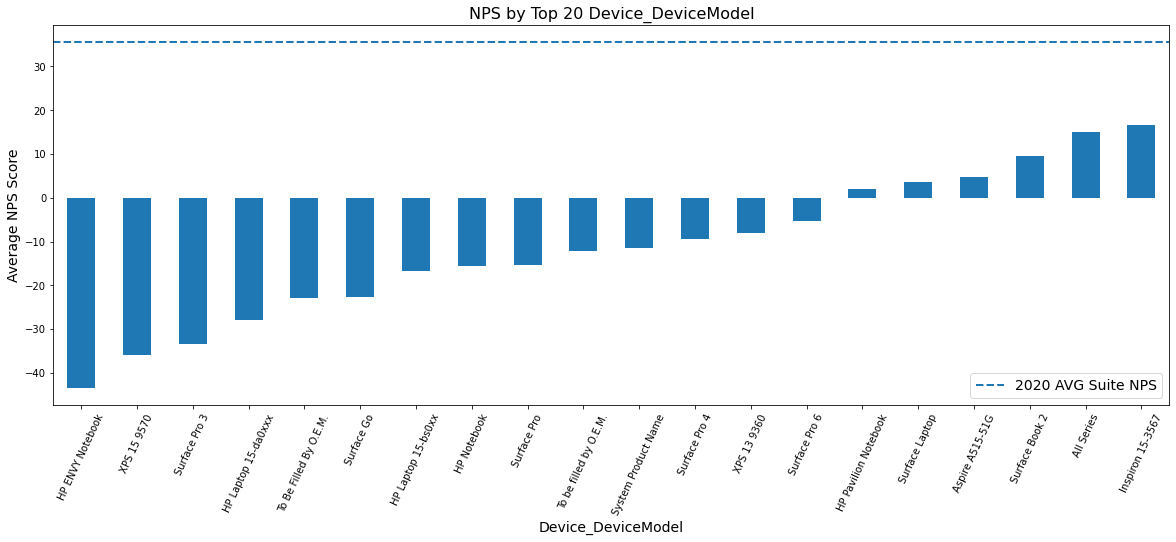

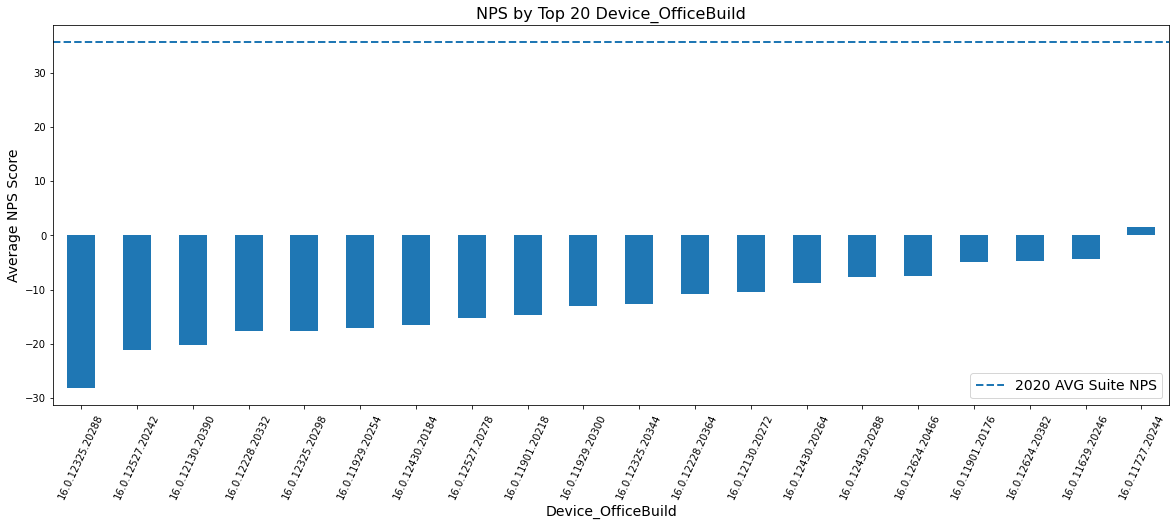

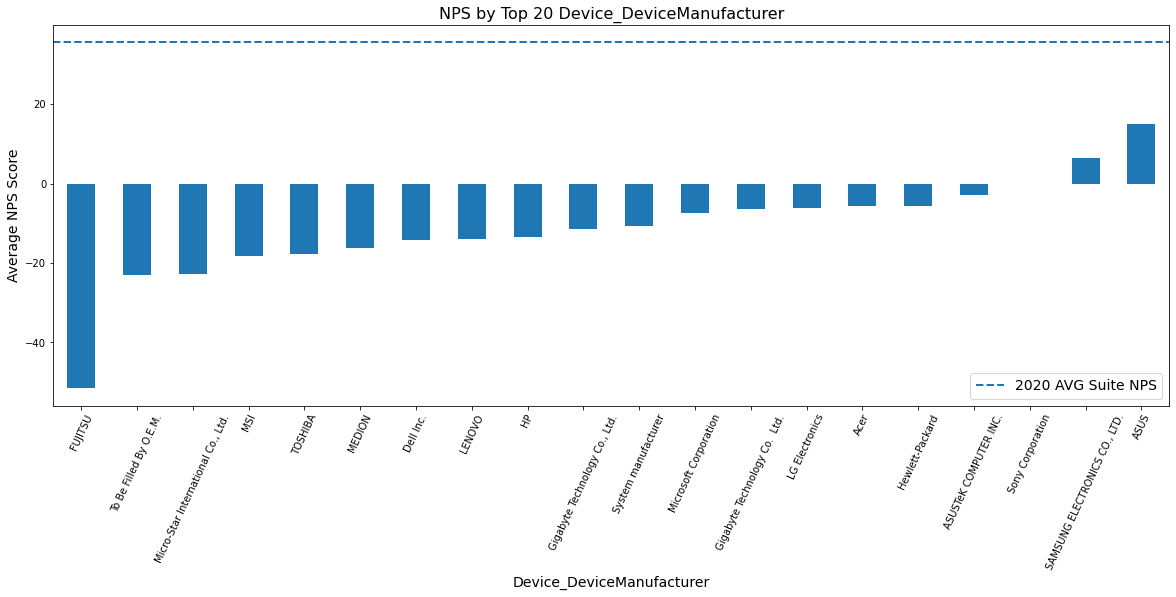

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37117 missing from curre

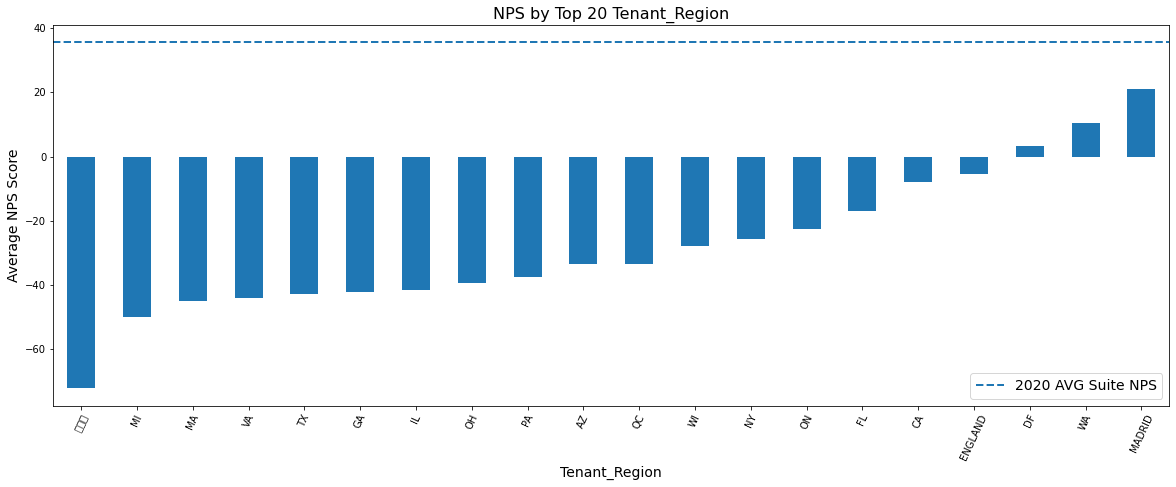

In [139]:
#dropping categorical variables that only have 1 level here
plot_cats(suite_cost_top_10_features, 35.5787584399305, 'suite')

### Suite Cost Numeric Plots

In [568]:
suite_cost_top_10_features.dtypes

Device_DeviceModel              object
User_Consumer_TenureDays       float64
Device_SysVolFreeSpaceMB       float64
Device_SysVolSizeMB            float64
Device_OfficeBuild              object
Device_ProcSpeedMHz            float64
Device_DeviceManufacturer       object
Tenant_Region                   object
Device_RamMB                   float64
Device_HorizontalResolution    float64
Feedback_RatingValue             int64
dtype: object

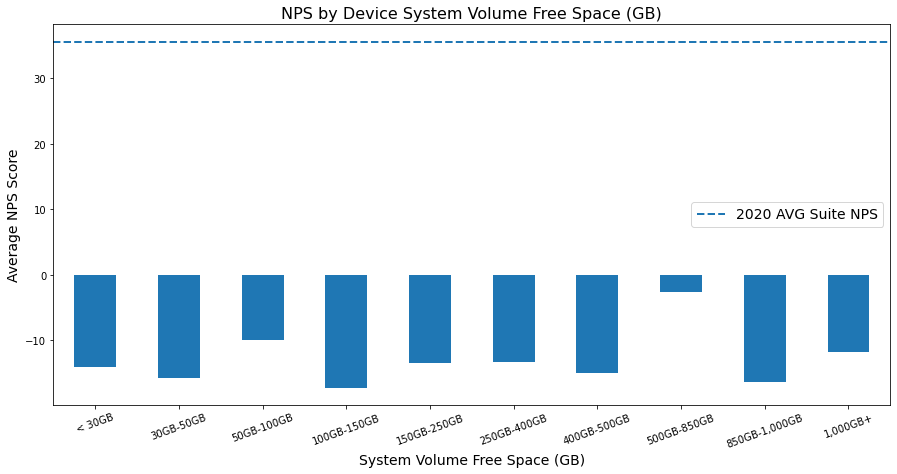

In [242]:
plot_nums(35.5787584399305, suite_cost_top_10_features, 'Device_SysVolFreeSpaceMB', 'suite', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

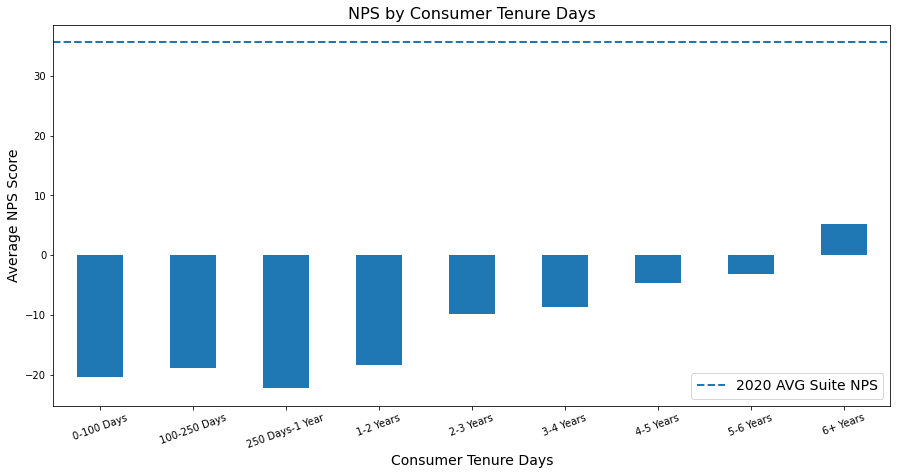

In [142]:
plot_nums(35.5787584399305, suite_cost_top_10_features, 'User_Consumer_TenureDays', 'suite', 'NPS by Consumer Tenure Days', 'Consumer Tenure Days',
          bins = [0, 100, 250, 365, 730, 1095, 1460, 1825, 2190, 2700],
          labels = ['0-100 Days', '100-250 Days', 
                    '250 Days-1 Year', '1-2 Years', '2-3 Years', '3-4 Years', '4-5 Years', '5-6 Years', '6+ Years'], method = 'cut')

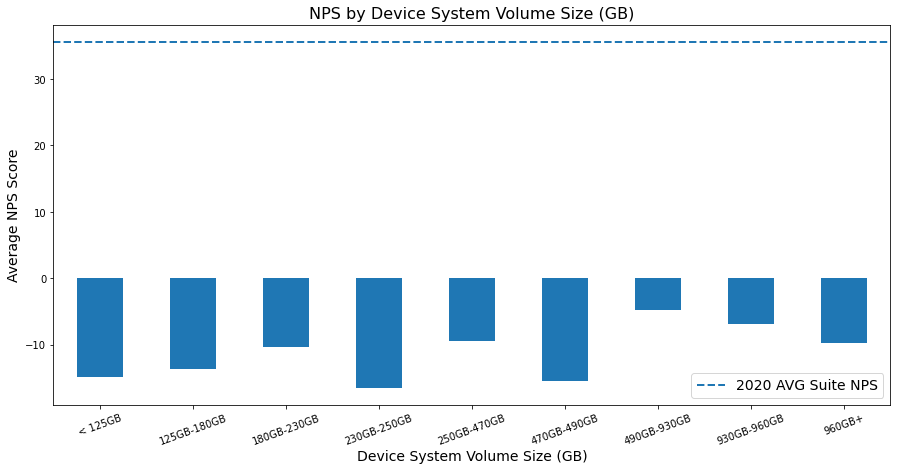

In [143]:
plot_nums(35.5787584399305, suite_cost_top_10_features, 'Device_SysVolSizeMB', 'suite', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

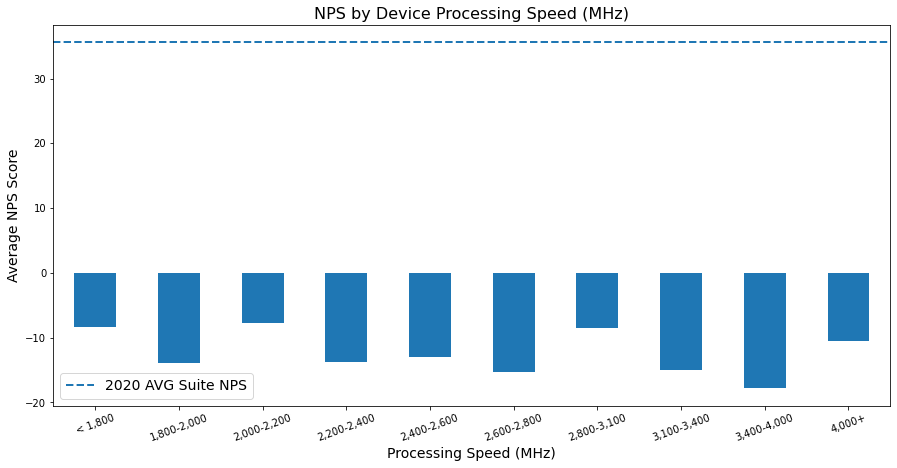

In [144]:
plot_nums(35.5787584399305, suite_cost_top_10_features, 'Device_ProcSpeedMHz', 'suite', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

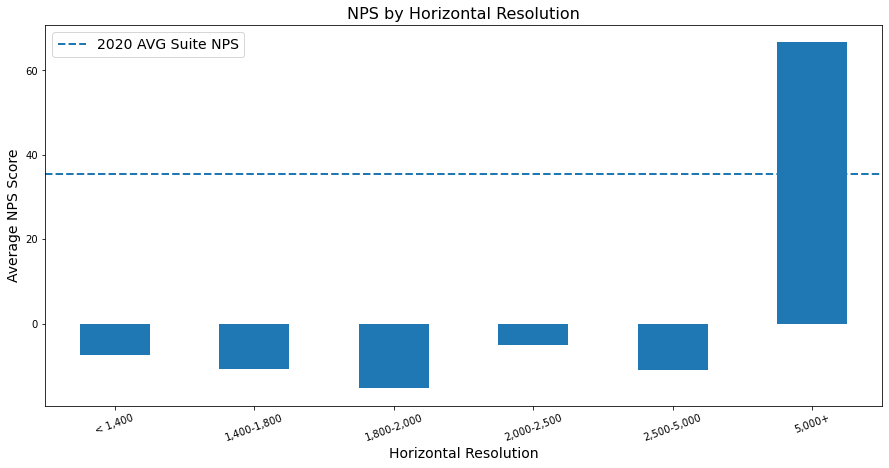

In [145]:
plot_nums(35.5787584399305, suite_cost_top_10_features, 'Device_HorizontalResolution', 'suite', 'NPS by Horizontal Resolution', 'Horizontal Resolution', 
         bins = [0, 1400, 1800, 2000, 2500, 5000, 10000],
          labels = ['< 1,400', '1,400-1,800', '1,800-2,000', '2,000-2,500', '2,500-5,000', '5,000+'], method = 'cut')

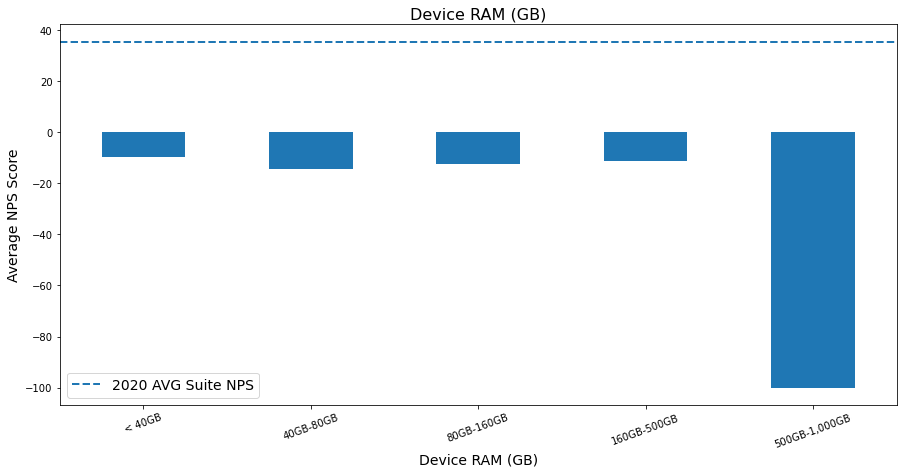

In [146]:
plot_nums(35.5787584399305, suite_cost_top_10_features, 'Device_RamMB', 'suite', 'Device RAM (GB)', 'Device RAM (GB)', bins = [0, 4000, 8000, 16000, 50000, 100000],
          labels = ['< 40GB', '40GB-80GB', '80GB-160GB', '160GB-500GB', '500GB-1,000GB'], method = 'cut')

In [147]:
build_age = get_build_age(suite, 'cost')
build_age

Device_OfficeBuild  Feedback_RatingValue
0    16.0.11629.20246             19.741935
1    16.0.11727.20244             21.174478
2    16.0.11901.20176             29.101358
3    16.0.11901.20218             22.684792
4    16.0.11929.20254             28.022645
5    16.0.11929.20300             24.051677
6    16.0.12130.20272             25.467100
7    16.0.12130.20390             28.643048
8    16.0.12228.20332             29.247202
9    16.0.12228.20364             29.620353
10   16.0.12325.20288             26.103969
11   16.0.12325.20298             25.728373
12   16.0.12325.20344             30.499076
13   16.0.12430.20184             29.031130
14   16.0.12430.20264             29.160305
15   16.0.12430.20288             27.965465
16   16.0.12527.20242             27.597812
17   16.0.12527.20278             32.749054
18   16.0.12624.20382             36.682316
19   16.0.12624.20466             35.080752

In [148]:
months_old = [12, 11, 11, 10, 10, 9, 8, 7, 6, 6, 5, 5, 5, 5, 4, 4, 3, 3, 3, 2]

In [149]:
build_age['Months_Old'] = months_old

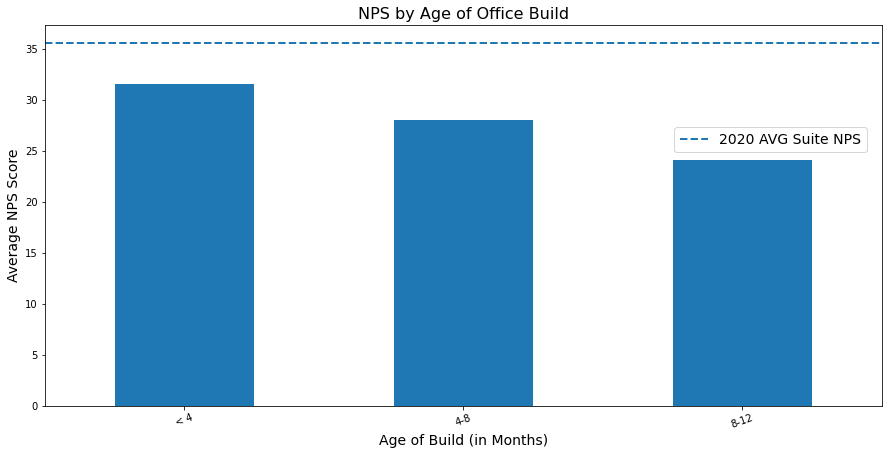

In [157]:
plot_nums(35.5787584399305, build_age, 'Months_Old', 'suite', 'NPS by Age of Office Build', 'Age of Build (in Months)', 
          bins = [0, 4, 8, 12], labels = ['< 4', '4-8', '8-12'], method = 'cut')
plt.legend(labels = ['2020 AVG Suite NPS'], fontsize = 14, bbox_to_anchor = (.99, .75))

# Feature Importance for Suite Separated by Consumer, Commercial Edu, and Commercial Non-Edu

## Suite Cost Consumer

In [1367]:
suite_cost_consumer_top_10_features.dtypes

Device_DeviceModel                   object
User_Consumer_TenureDays            float64
Device_SysVolFreeSpaceMB            float64
Device_SysVolSizeMB                 float64
Device_OfficeBuild                   object
Device_ProcSpeedMHz                 float64
User_A13Region                       object
Device_DeviceManufacturer            object
Device_RamMB                        float64
User_Consumer_ProductDisplayName     object
Feedback_RatingValue                  int64
dtype: object

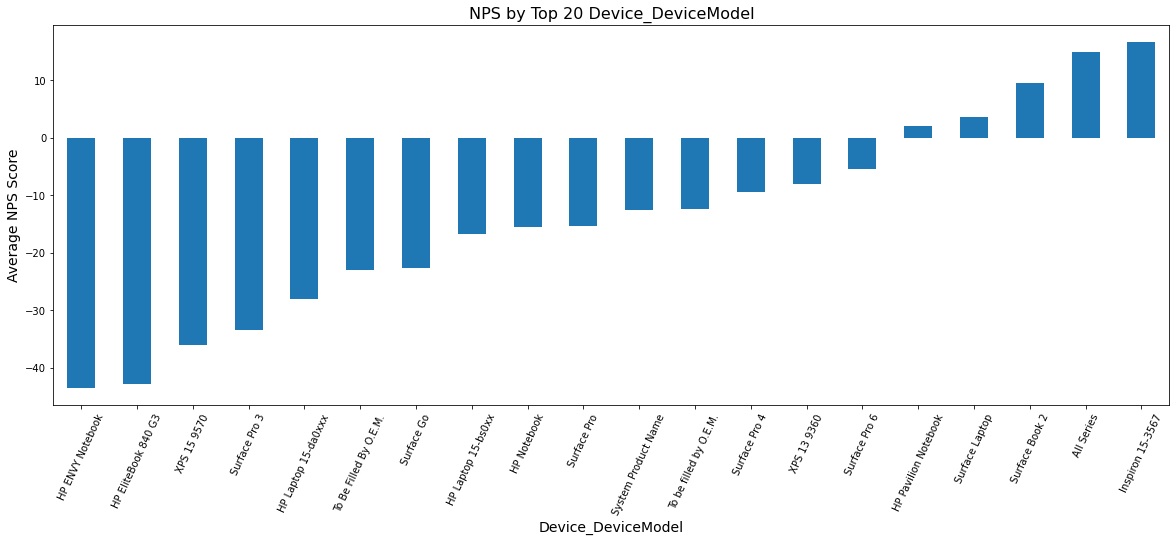

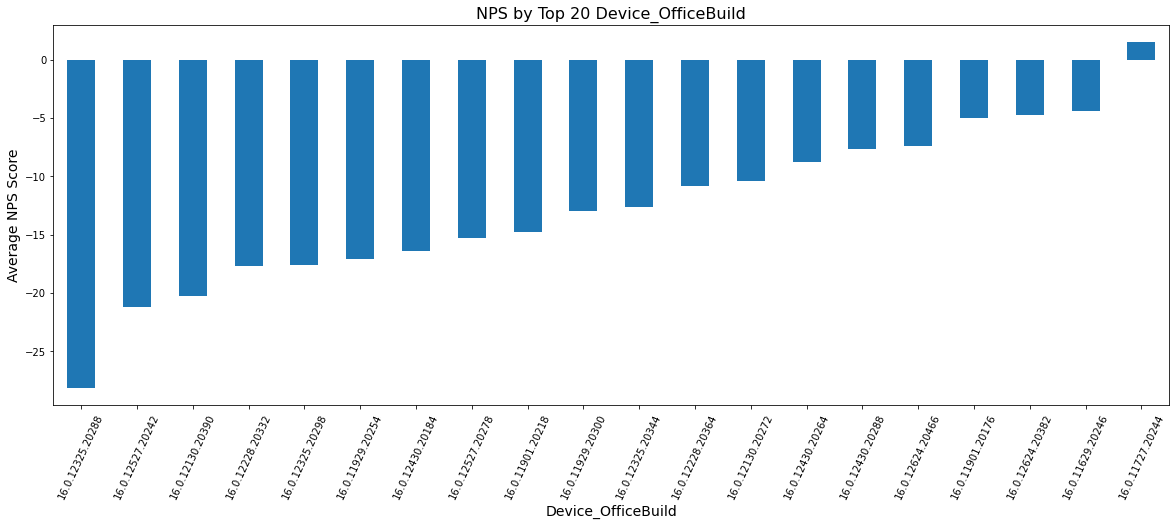

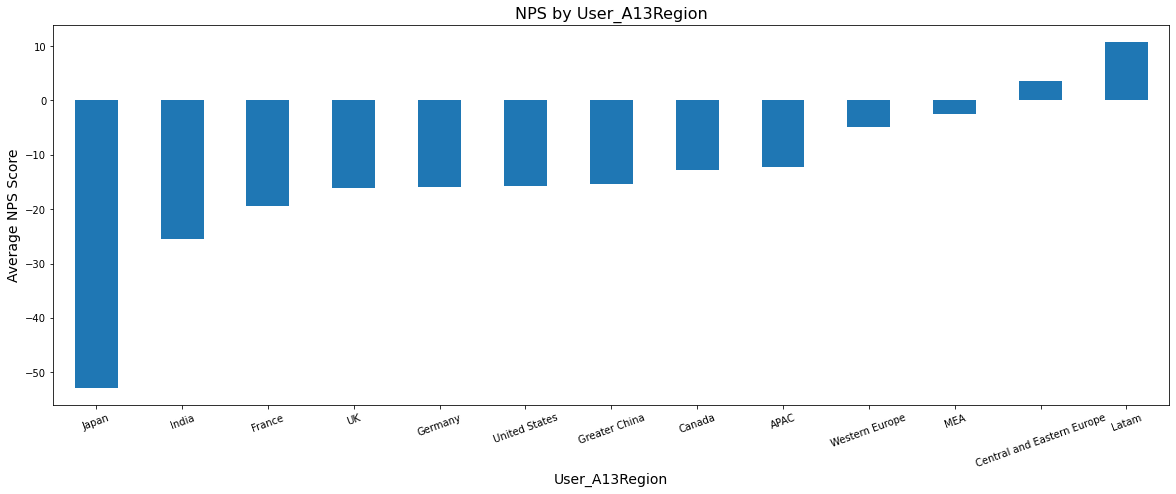

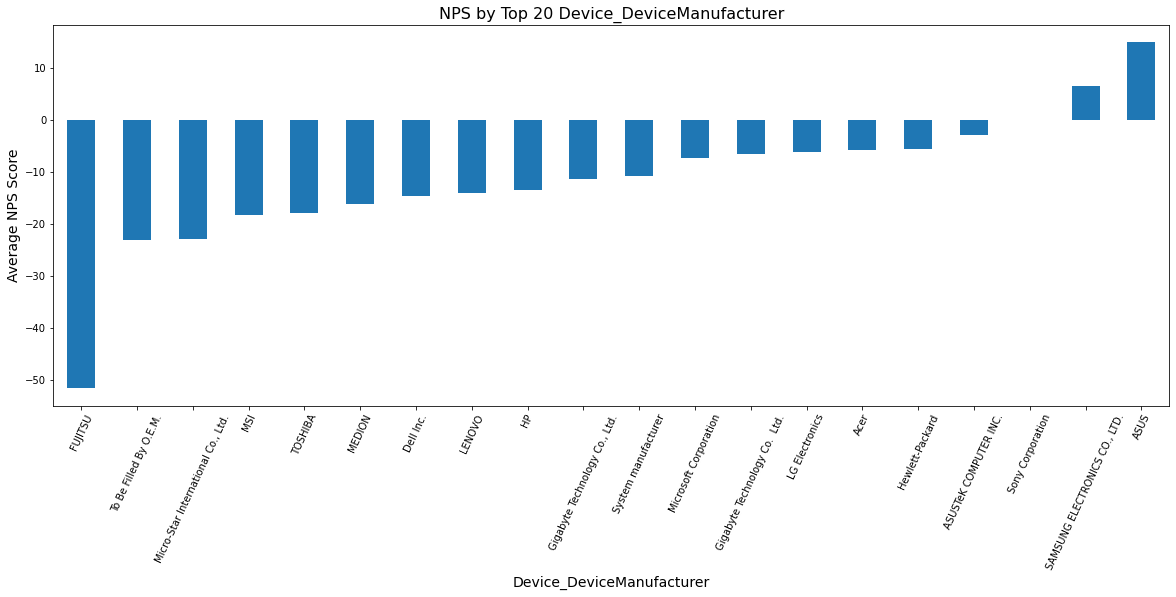

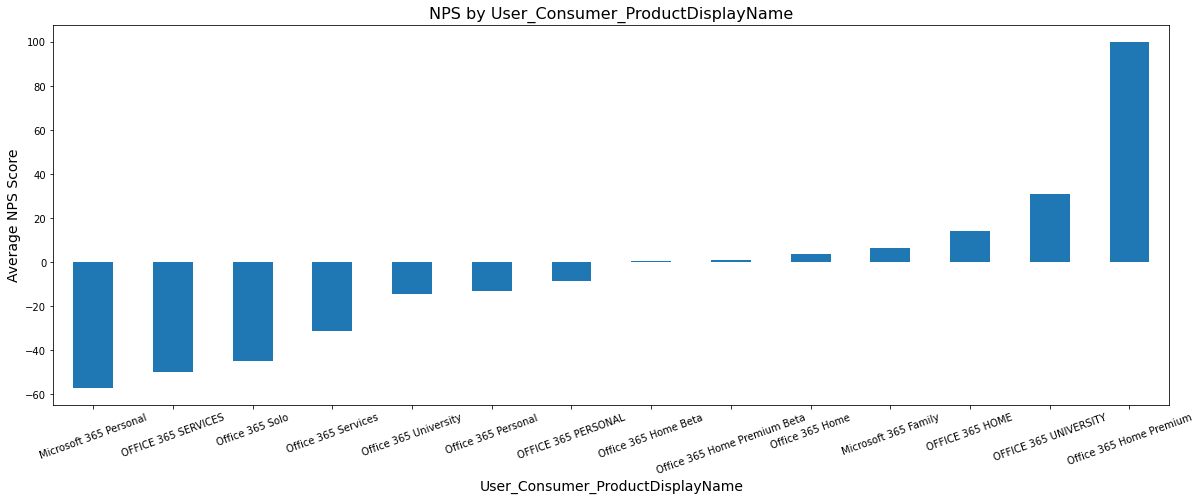

In [1368]:
plot_cats(suite_cost_consumer_top_10_features)

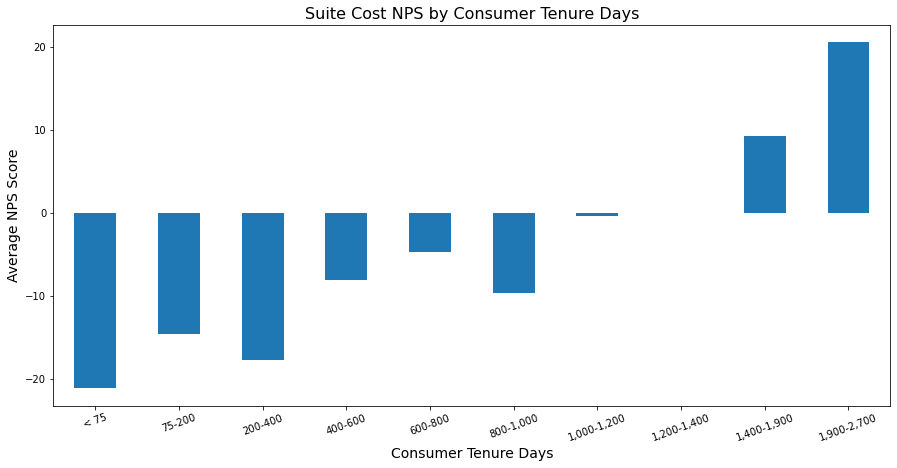

In [584]:
plot_nums(suite_cost_consumer_top_10_features, 'User_Consumer_TenureDays', 'Suite Cost NPS by Consumer Tenure Days', 'Consumer Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

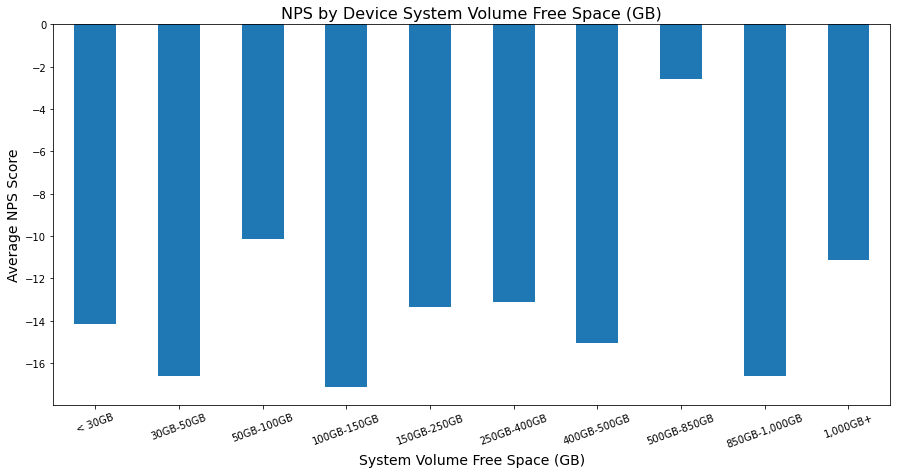

In [586]:
plot_nums(suite_cost_consumer_top_10_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

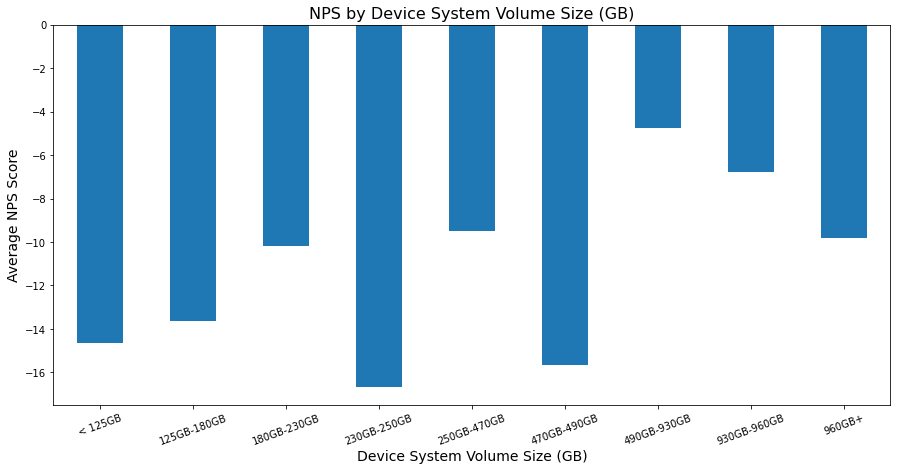

In [587]:
plot_nums(suite_cost_consumer_top_10_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

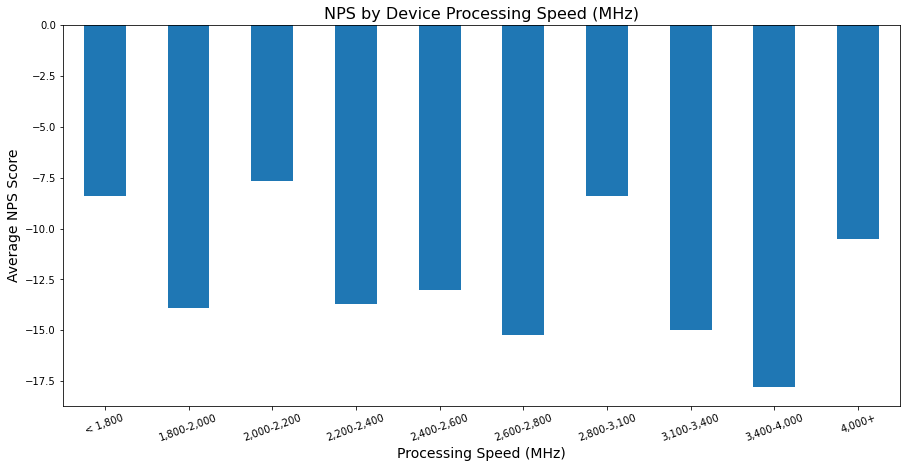

In [588]:
plot_nums(suite_cost_consumer_top_10_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

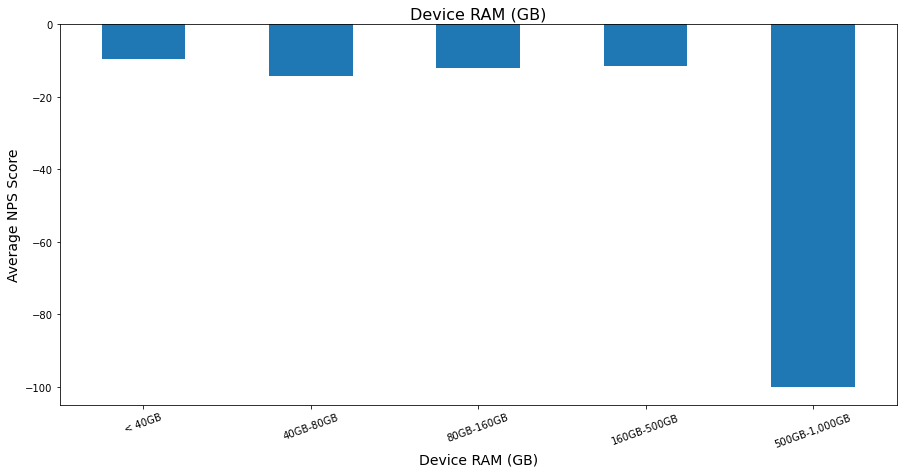

In [589]:
plot_nums(suite_cost_consumer_top_10_features, 'Device_RamMB', 'Device RAM (GB)', 'Device RAM (GB)', bins = [0, 4000, 8000, 16000, 50000, 100000],
          labels = ['< 40GB', '40GB-80GB', '80GB-160GB', '160GB-500GB', '500GB-1,000GB'], method = 'cut')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   33.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 28.3min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed: 30.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 30.6min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 32.8min remaining:  7.2min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 34.2min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 34.4min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

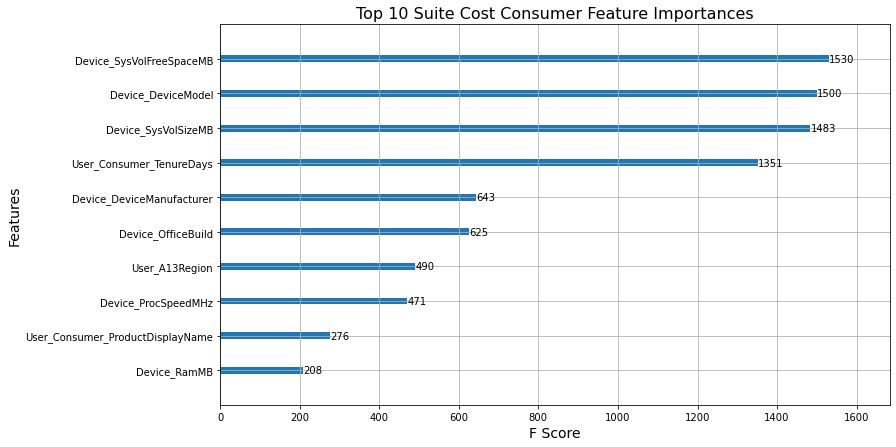

In [1369]:
suite_cost_consumer_feats, suite_cost_consumer_model = find_important_features(suite_cost_consumer_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                              suite_cost_consumer_top_10_features['Feedback_RatingValue'], model ='xgboost', encode = True)

plt.figure(figsize = (12, 10))
ax = plot_importance(suite_cost_consumer_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 Suite Cost Consumer Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

## Suite Cost Commercial Edu

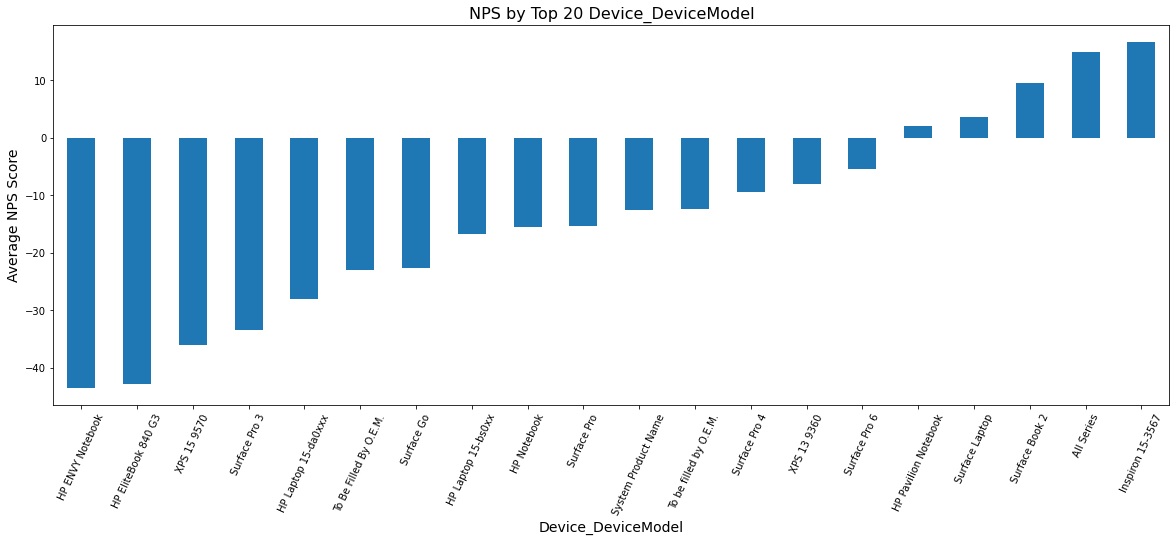

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37117 missing from curre

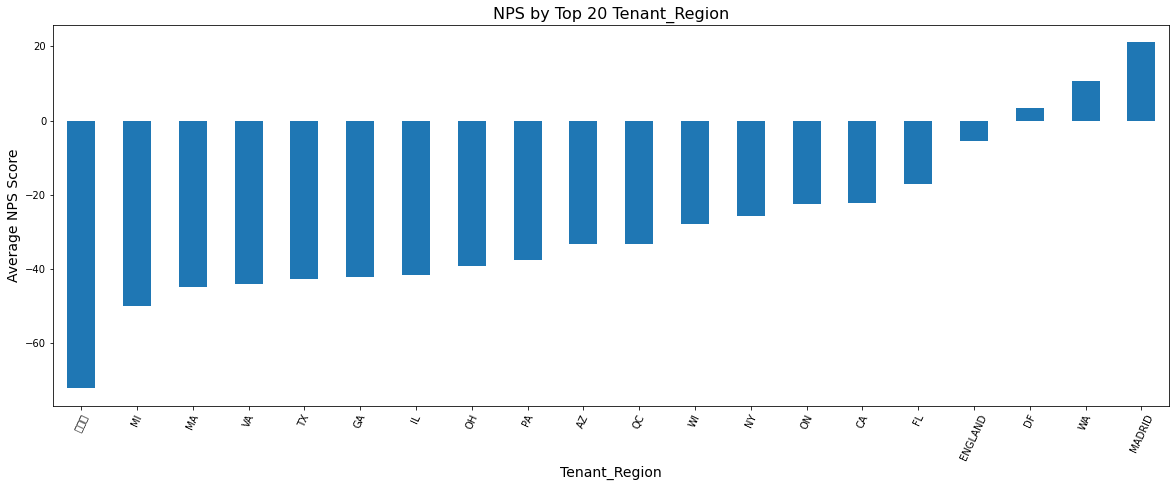

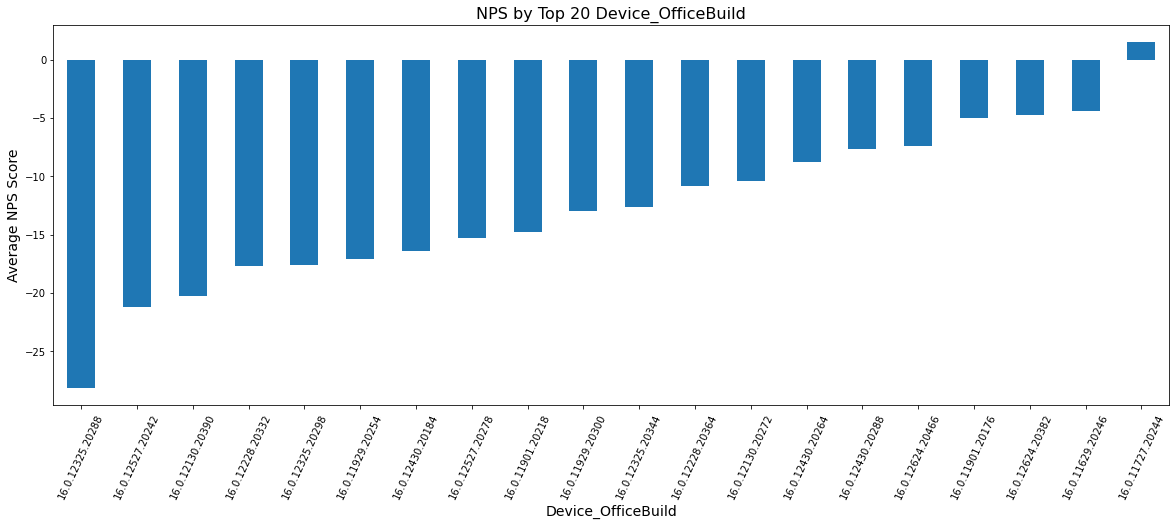

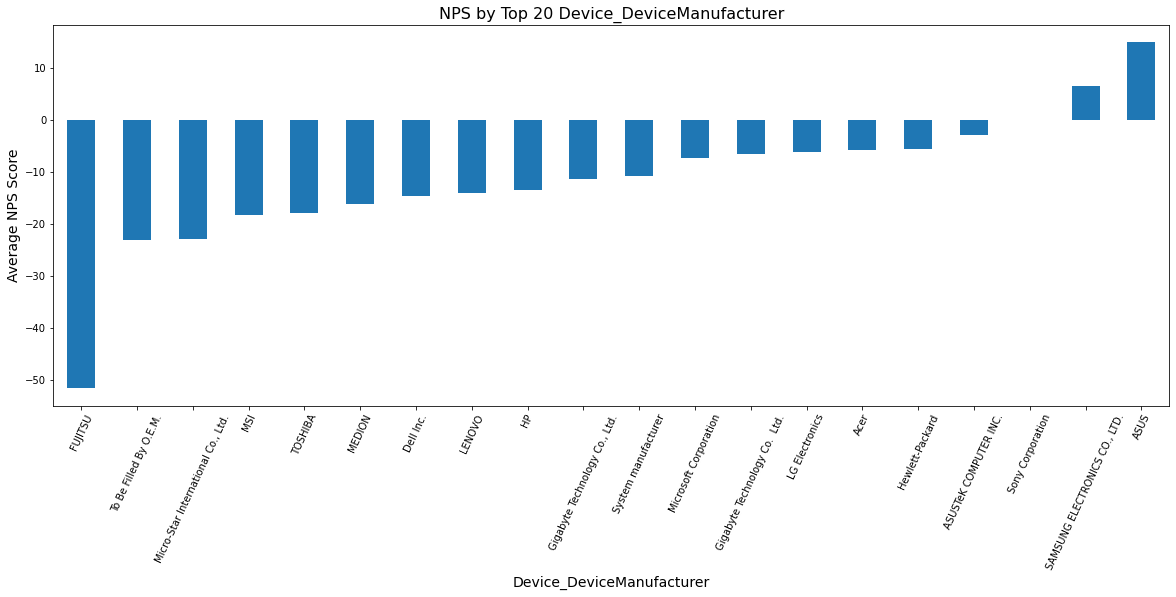

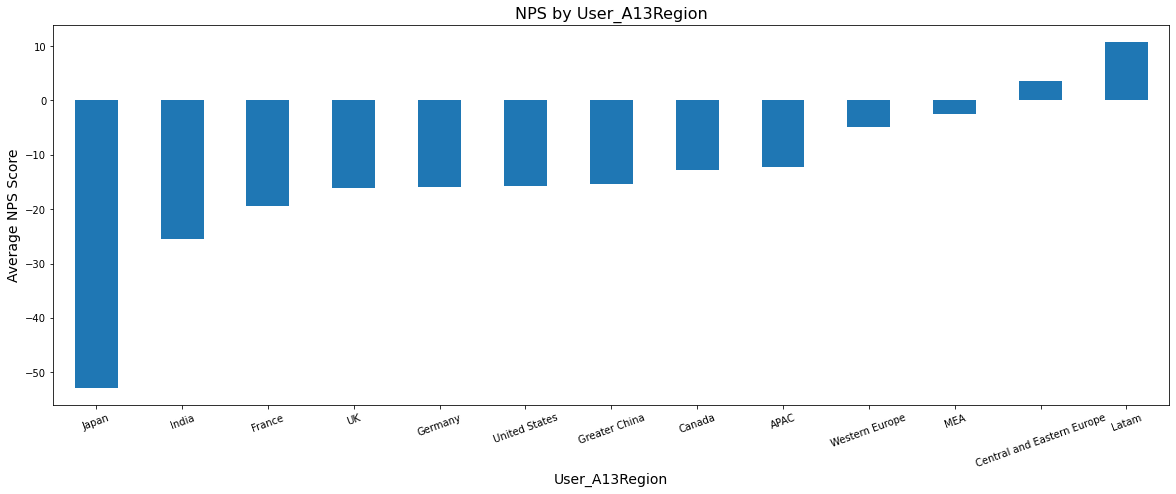

In [1690]:
plot_cats(suite_cost_commercial_edu_top_10_features)

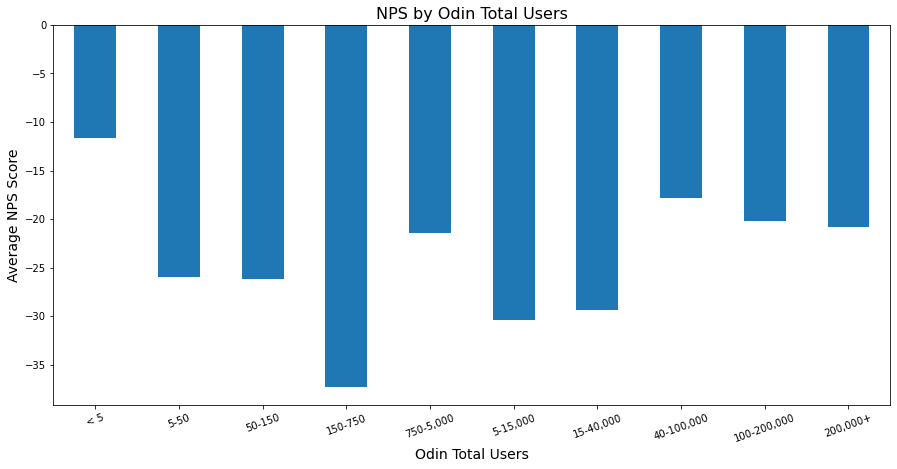

In [1695]:
plot_nums(suite_cost_commercial_edu_top_10_features, 'Tenant_Odin_TotalUsers', 'NPS by Odin Total Users', 'Odin Total Users', 
          bins = [0, 5, 50, 150, 750, 5000, 15000, 40000, 100000, 200000, 10000000000000],
          labels = ['< 5', '5-50', '50-150', '150-750', '750-5,000', '5-15,000', '15-40,000', '40-100,000', '100-200,000', '200,000+'], method = 'cut')

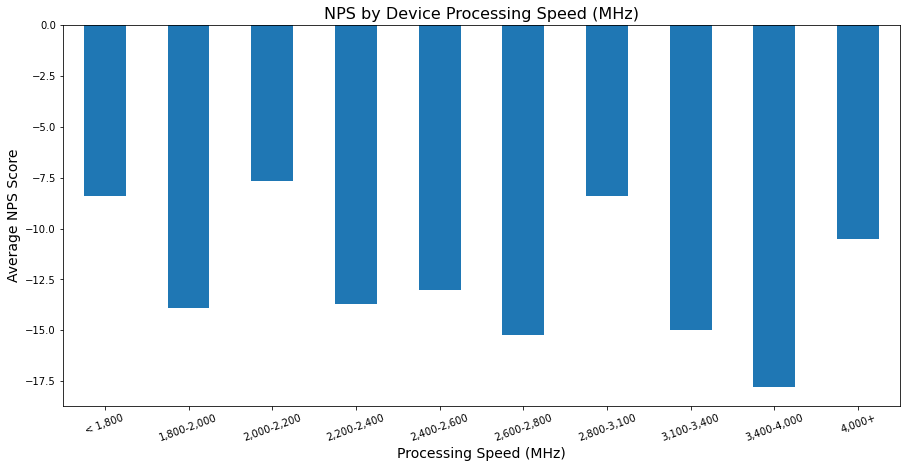

In [594]:
plot_nums(suite_cost_commercial_edu_top_10_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

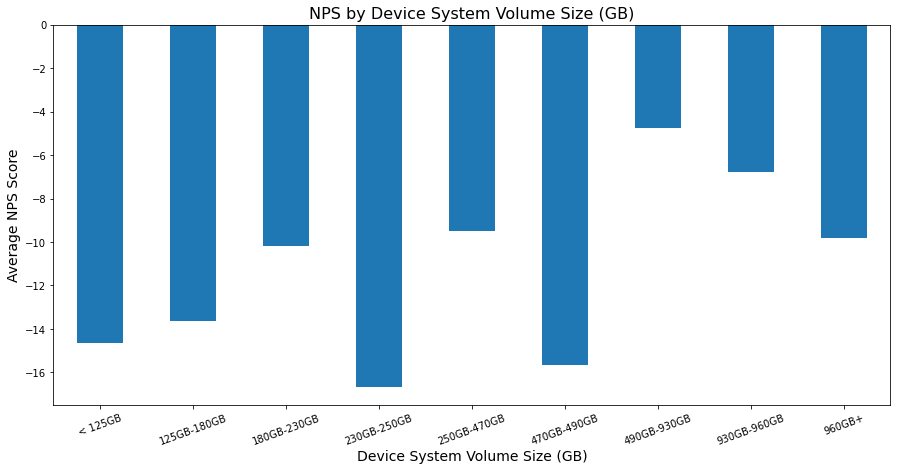

In [595]:
plot_nums(suite_cost_commercial_edu_top_10_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

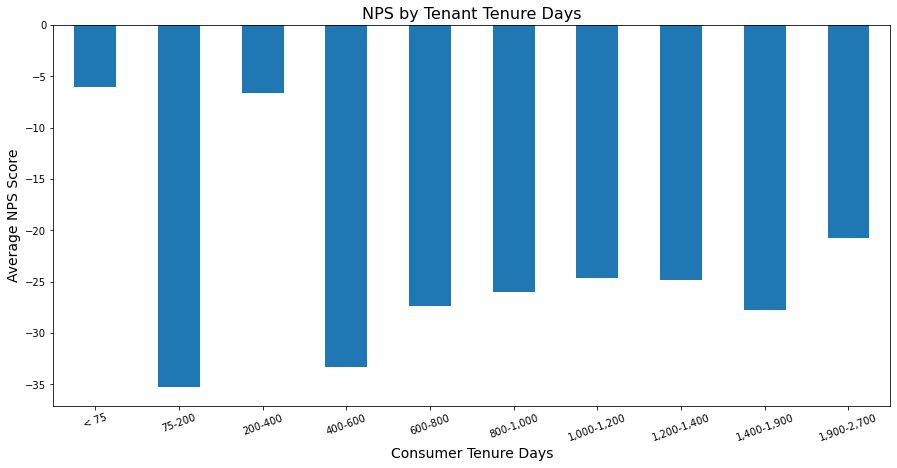

In [599]:
plot_nums(suite_cost_commercial_edu_top_10_features, 'Tenant_Tenure', 'NPS by Tenant Tenure Days', 'Consumer Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

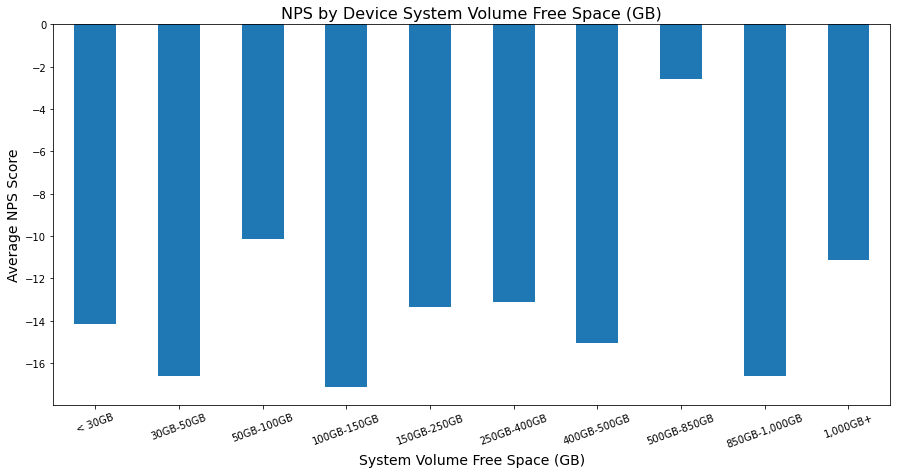

In [600]:
plot_nums(suite_cost_commercial_edu_top_10_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   14.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   23.1s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  3.6min remaining:   46.8s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  4.1min remaining:   15.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  4.2min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

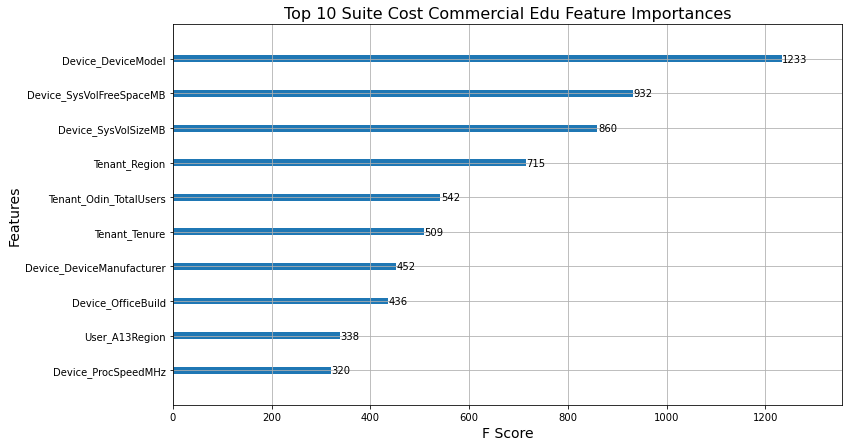

In [1697]:
suite_cost_commedu_feats, suite_cost_commedu_model = find_important_features(suite_cost_commercial_edu_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                              suite_cost_commercial_edu_top_10_features['Feedback_RatingValue'], model ='xgboost', encode = True)

plt.figure(figsize = (12, 10))
ax = plot_importance(suite_cost_commedu_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 Suite Cost Commercial Edu Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

## Suite Cost Commercial Non-Edu

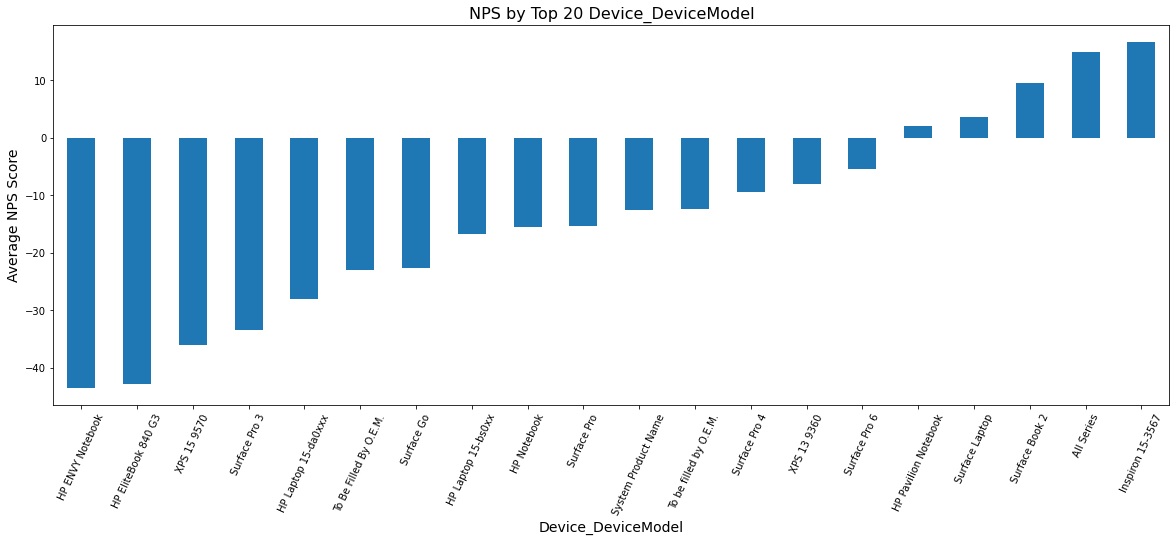

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37117 missing from curre

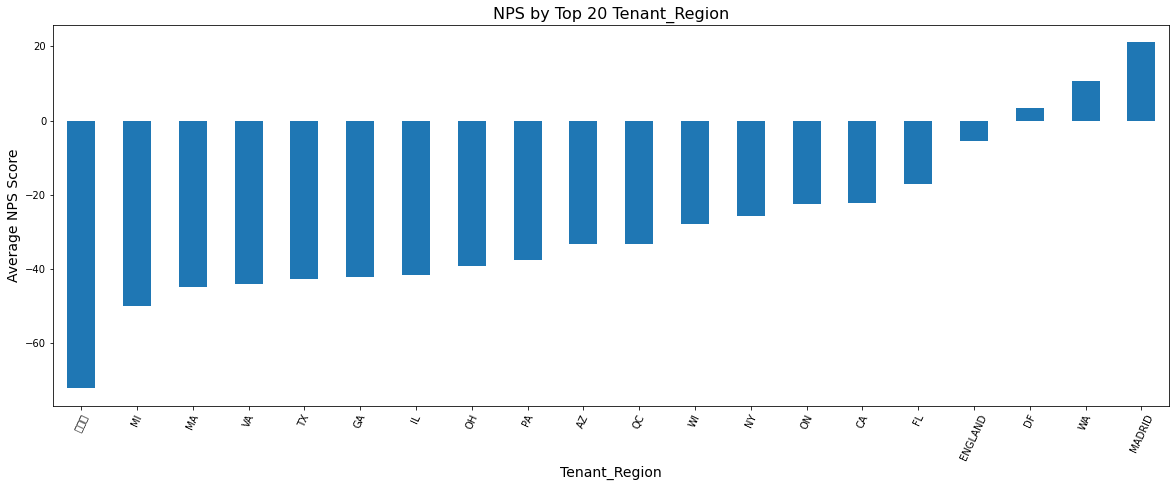

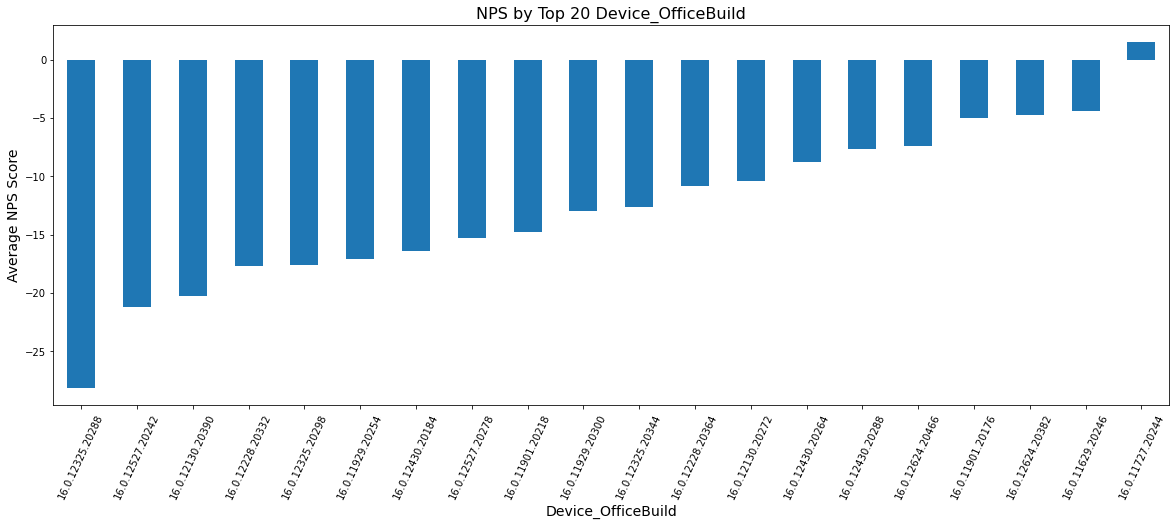

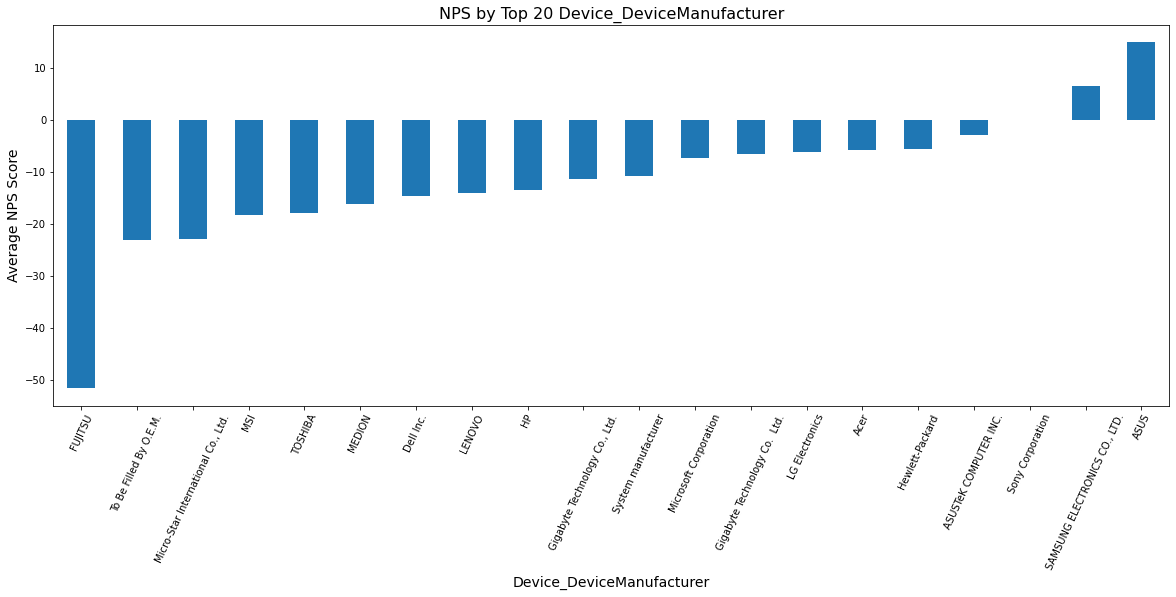

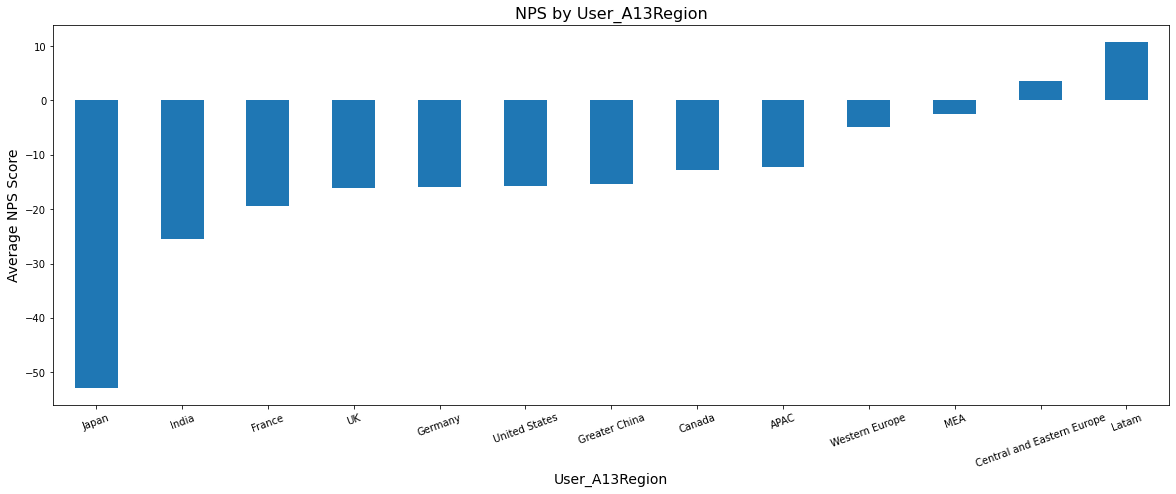

In [626]:
plot_cats(suite_cost_commercial_nonedu_important_features)

In [627]:
suite_cost_commercial_nonedu_important_features.dtypes

Device_DeviceModel            object
Tenant_Region                 object
Device_OfficeBuild            object
Device_SysVolSizeMB          float64
Device_SysVolFreeSpaceMB     float64
Tenant_Tenure                float64
Device_DeviceManufacturer     object
Device_ProcSpeedMHz          float64
User_A13Region                object
Tenant_Odin_TotalUsers       float64
Feedback_RatingValue           int64
dtype: object

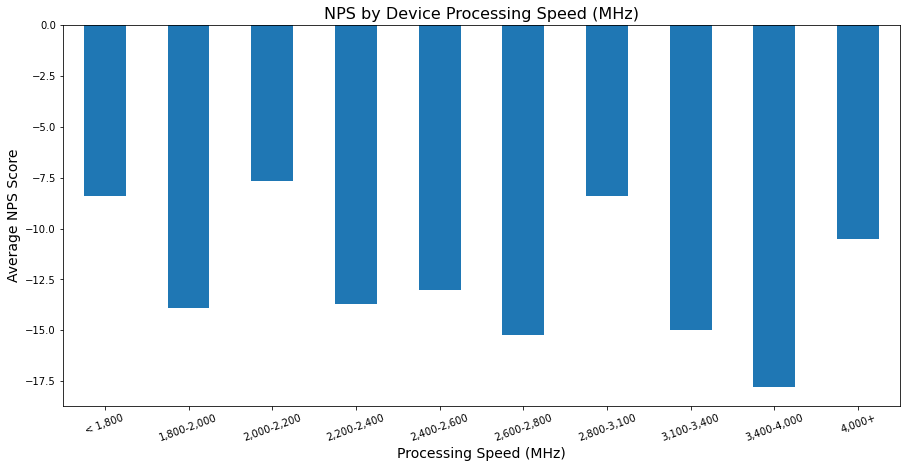

In [628]:
plot_nums(suite_cost_commercial_nonedu_important_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

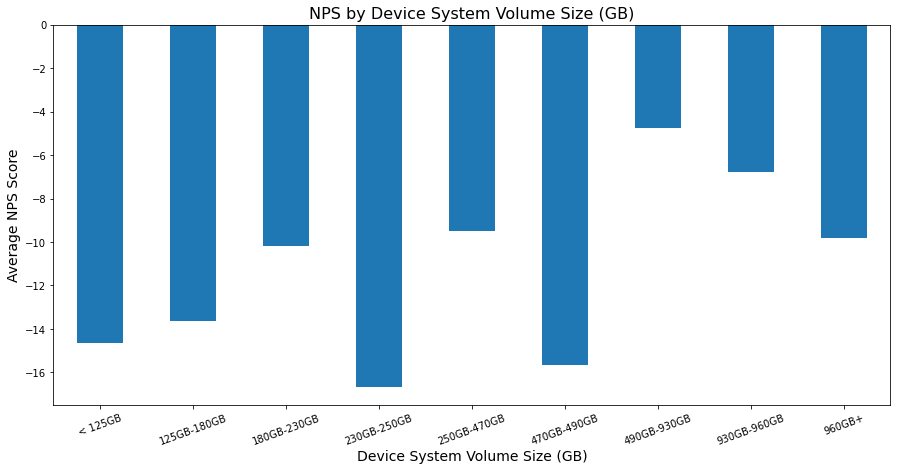

In [629]:
plot_nums(suite_cost_commercial_nonedu_important_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

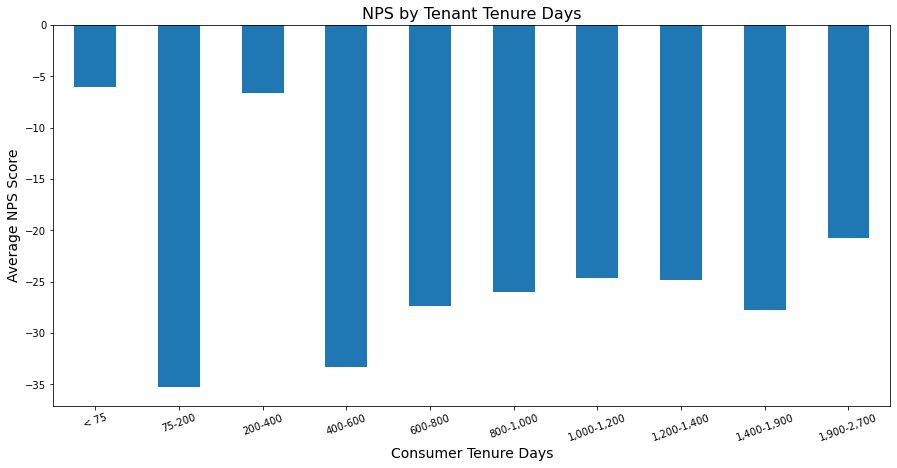

In [630]:
plot_nums(suite_cost_commercial_nonedu_important_features, 'Tenant_Tenure', 'NPS by Tenant Tenure Days', 'Consumer Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

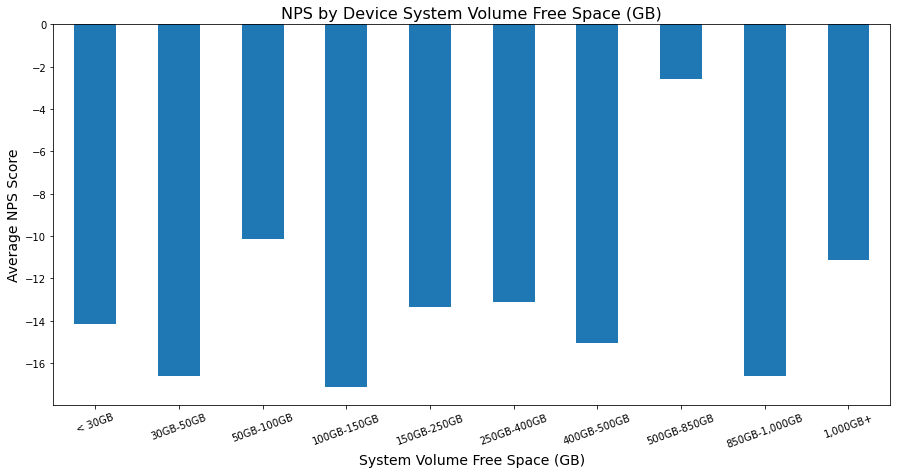

In [631]:
plot_nums(suite_cost_commercial_nonedu_important_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

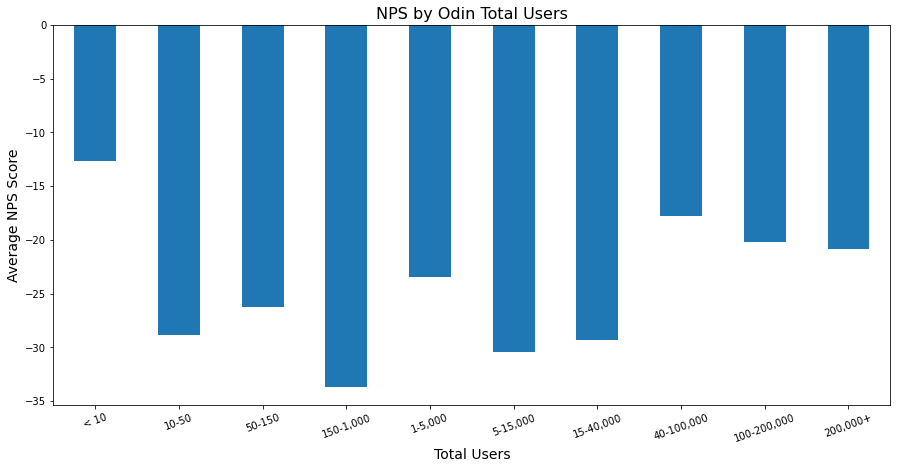

In [636]:
plot_nums(suite_cost_commercial_nonedu_important_features, 'Tenant_Odin_TotalUsers', 'NPS by Odin Total Users', 'Total Users', 
          bins = [0, 10, 50, 150, 1000, 5000, 15000, 40000, 100000, 200000, 1000000000],
          labels = ['< 10', '10-50', '50-150', '150-1,000', '1-5,000', '5-15,000', '15-40,000', '40-100,000', '100-200,000', '200,000+'], method = 'cut')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   30.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  6.4min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  8.9min remaining:  2.0min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 11.0min remaining:   42.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.2min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

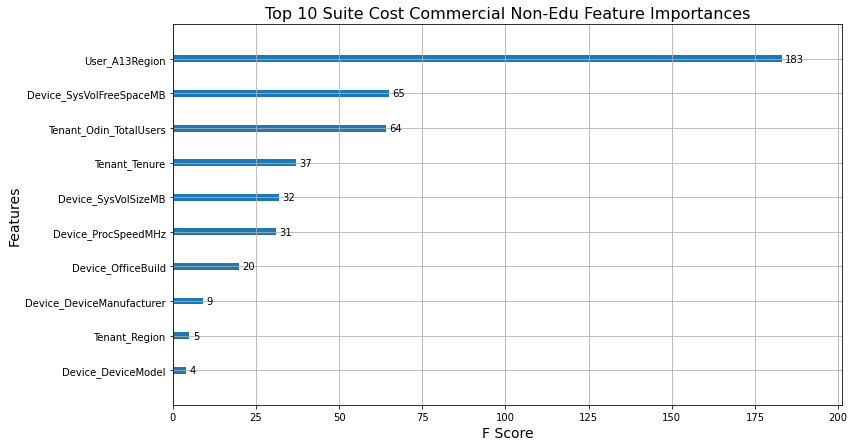

In [648]:
suite_cost_nonedu_feats, suite_cost_nonedu_model = find_important_features(suite_cost_commercial_nonedu_important_features.drop('Feedback_RatingValue', axis = 1),
                                                                              suite_cost_commercial_nonedu_important_features['Feedback_RatingValue'], model ='xgboost', encode = True)

plt.figure(figsize = (12, 10))
ax = plot_importance(suite_cost_nonedu_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 Suite Cost Commercial Non-Edu Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

## Suite Compete Consumer

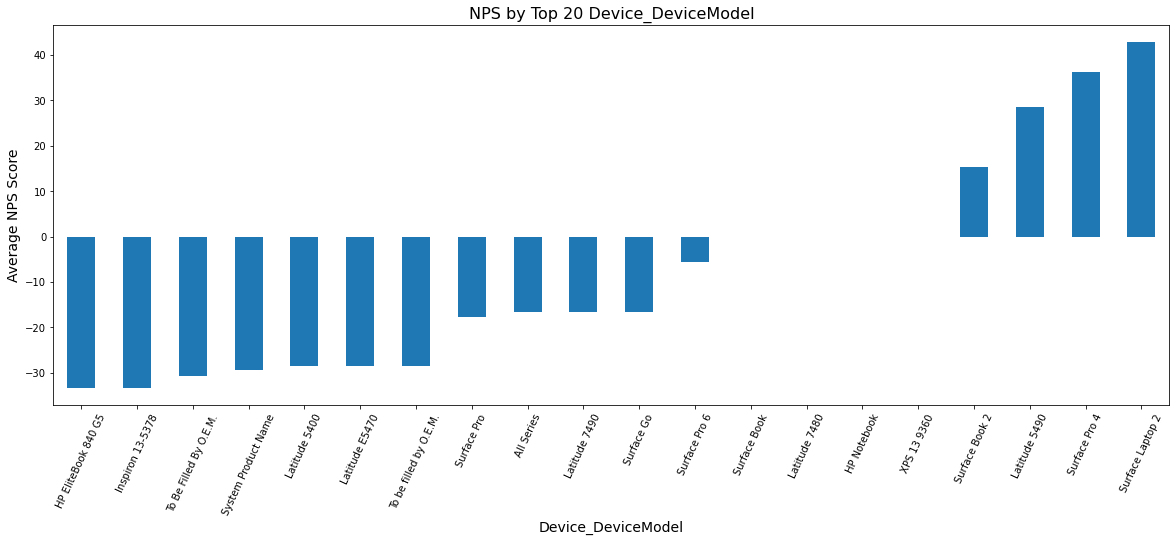

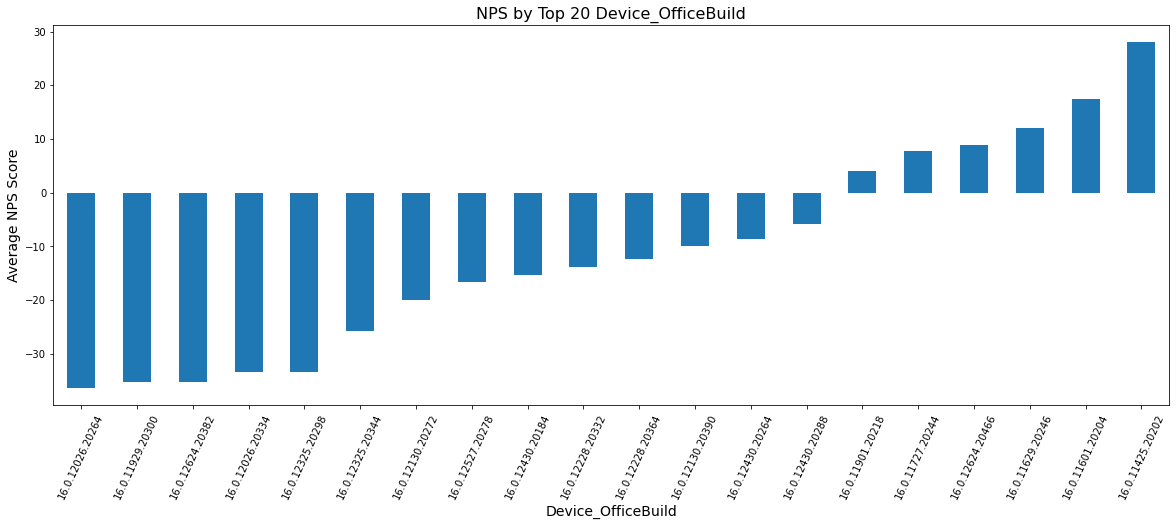

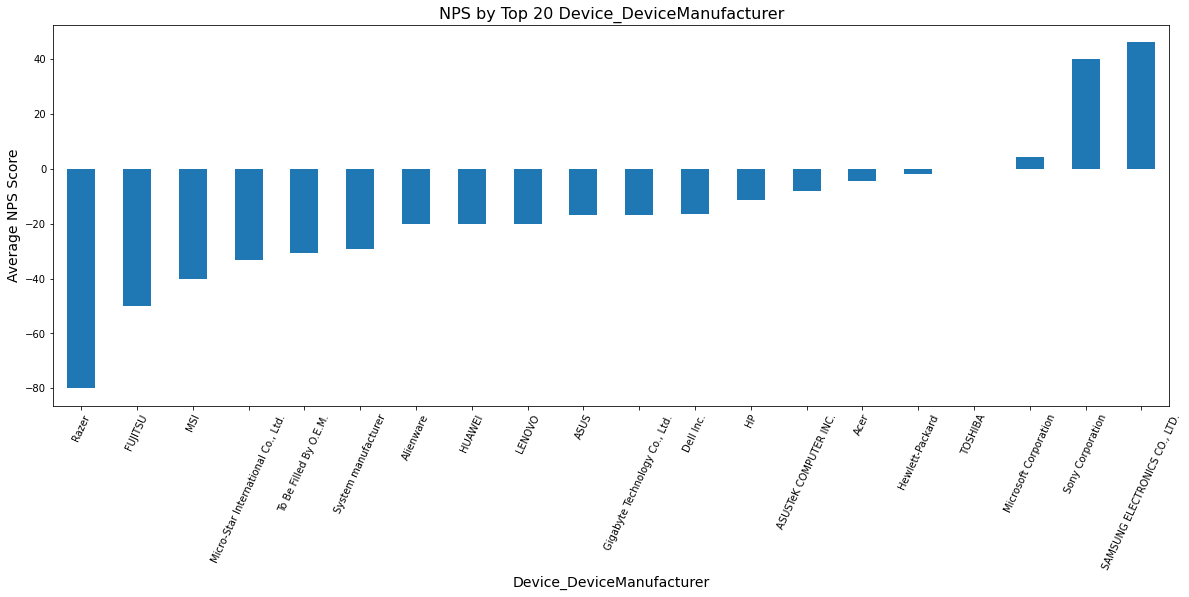

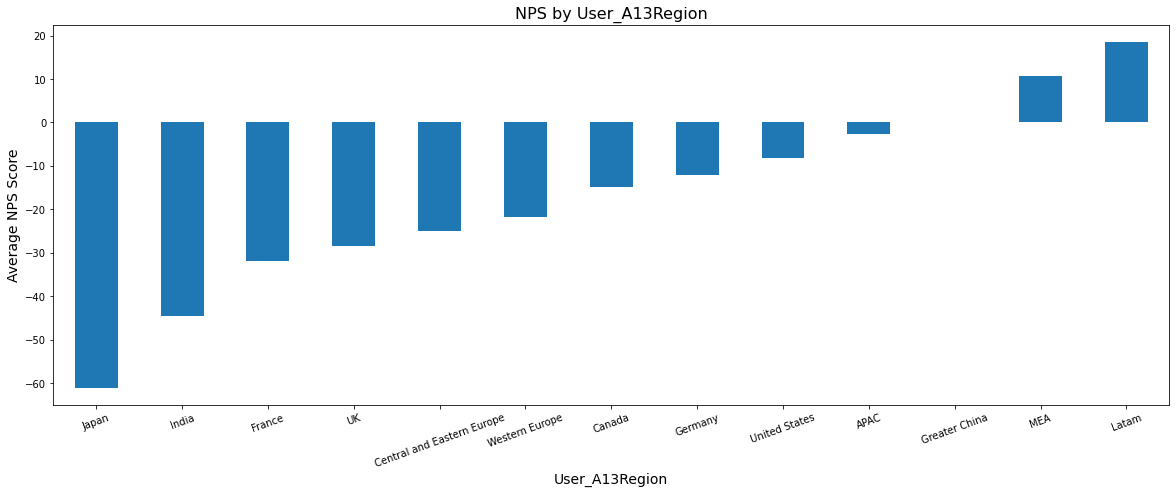

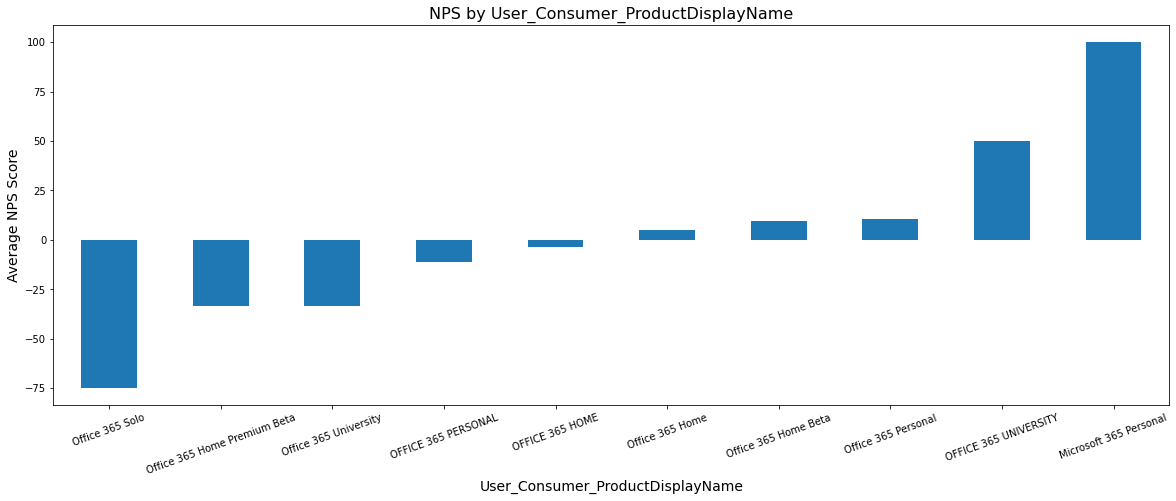

In [638]:
plot_cats(suite_compete_consumer_important_features)

In [639]:
suite_compete_consumer_important_features.dtypes

Device_DeviceModel                   object
Device_OfficeBuild                   object
Device_SysVolFreeSpaceMB            float64
Device_SysVolSizeMB                 float64
User_Consumer_TenureDays            float64
Device_ProcSpeedMHz                 float64
Device_DeviceManufacturer            object
User_A13Region                       object
User_Consumer_ProductDisplayName     object
Device_HorizontalResolution         float64
Feedback_RatingValue                  int64
dtype: object

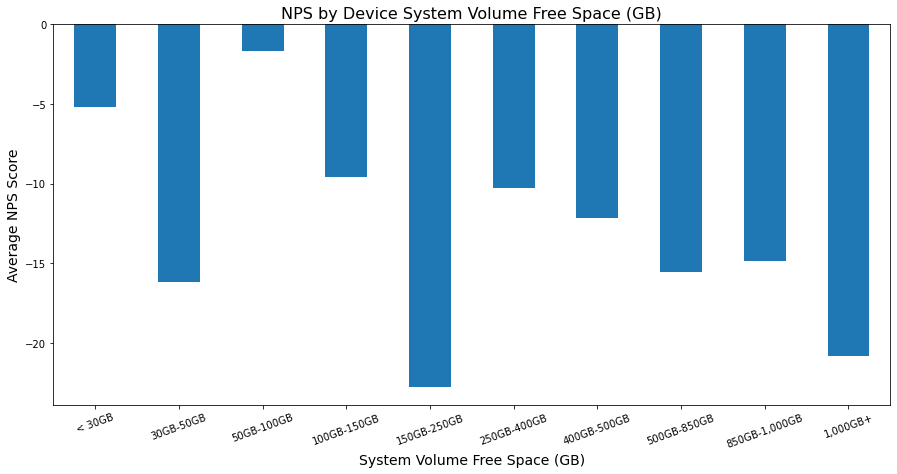

In [641]:
plot_nums(suite_compete_consumer_important_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

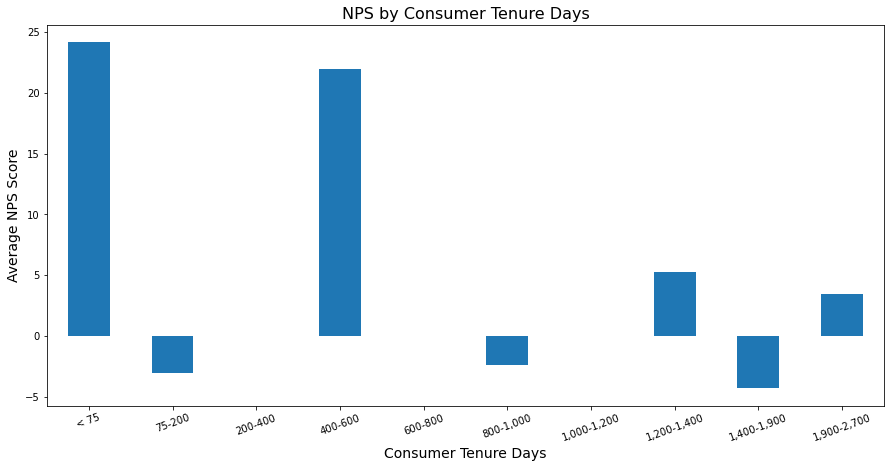

In [642]:
plot_nums(suite_compete_consumer_important_features, 'User_Consumer_TenureDays', 'NPS by Consumer Tenure Days', 'Consumer Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

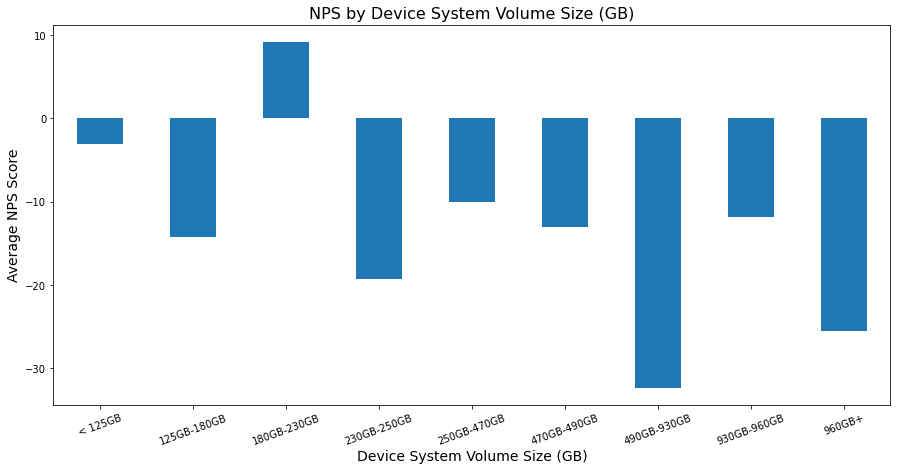

In [643]:
plot_nums(suite_compete_consumer_important_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

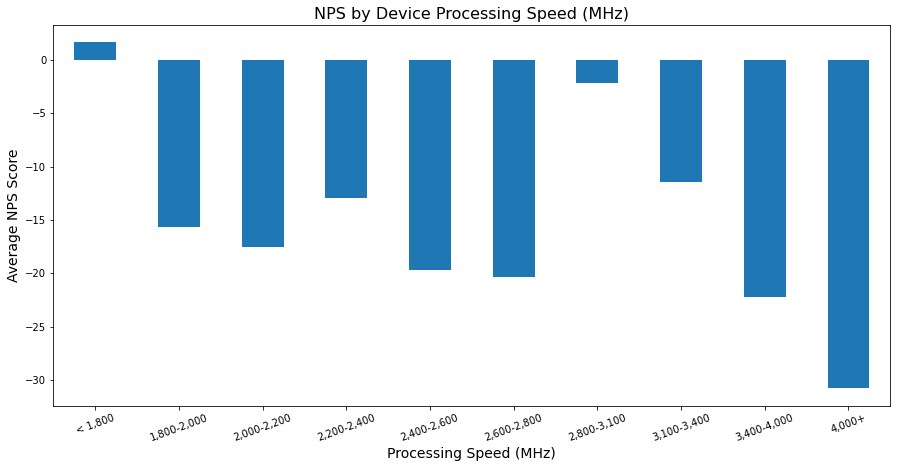

In [644]:
plot_nums(suite_compete_consumer_important_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

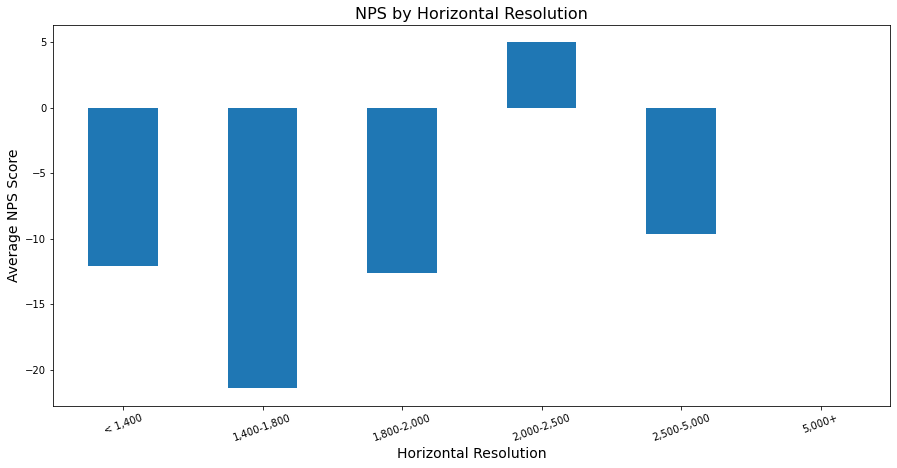

In [645]:
plot_nums(suite_compete_consumer_important_features, 'Device_HorizontalResolution', 'NPS by Horizontal Resolution', 'Horizontal Resolution', 
         bins = [0, 1400, 1800, 2000, 2500, 5000, 10000],
          labels = ['< 1,400', '1,400-1,800', '1,800-2,000', '2,000-2,500', '2,500-5,000', '5,000+'], method = 'cut')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   16.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   25.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   28.6s remaining:    6.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   31.2s remaining:    1.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   31.7s finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

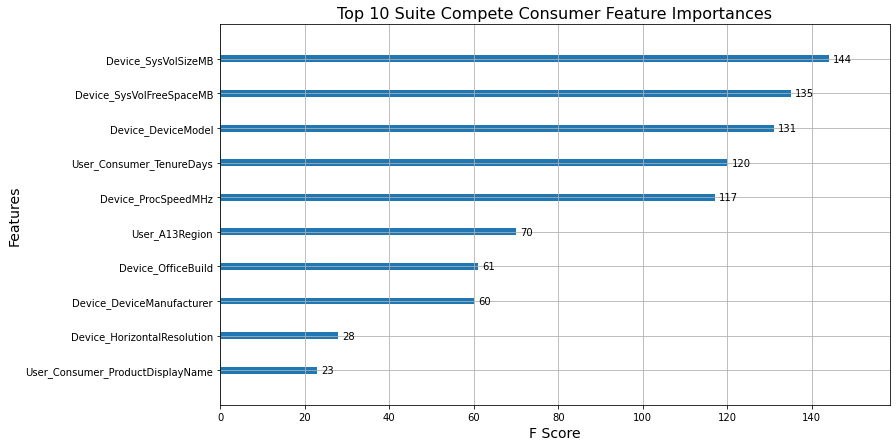

In [649]:
suite_compete_consumer_feats, suite_compete_consumer_model = find_important_features(suite_compete_consumer_important_features.drop('Feedback_RatingValue', axis = 1),
                                                                              suite_compete_consumer_important_features['Feedback_RatingValue'], model ='xgboost', encode = True)

plt.figure(figsize = (12, 10))
ax = plot_importance(suite_compete_consumer_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 Suite Compete Consumer Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

## Suite Compete Commercial Edu

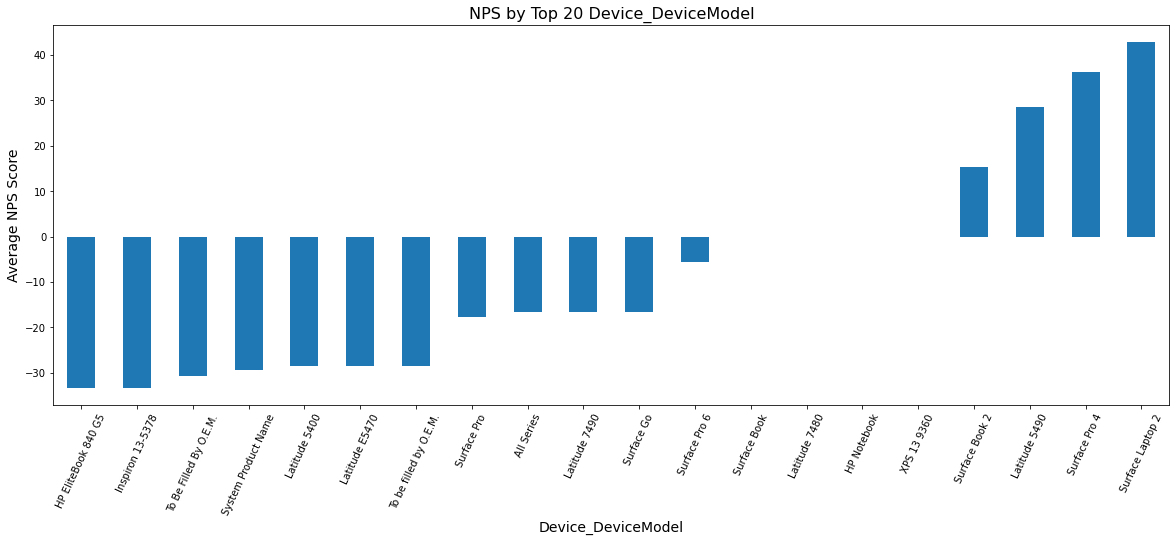

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37117 missing from curre

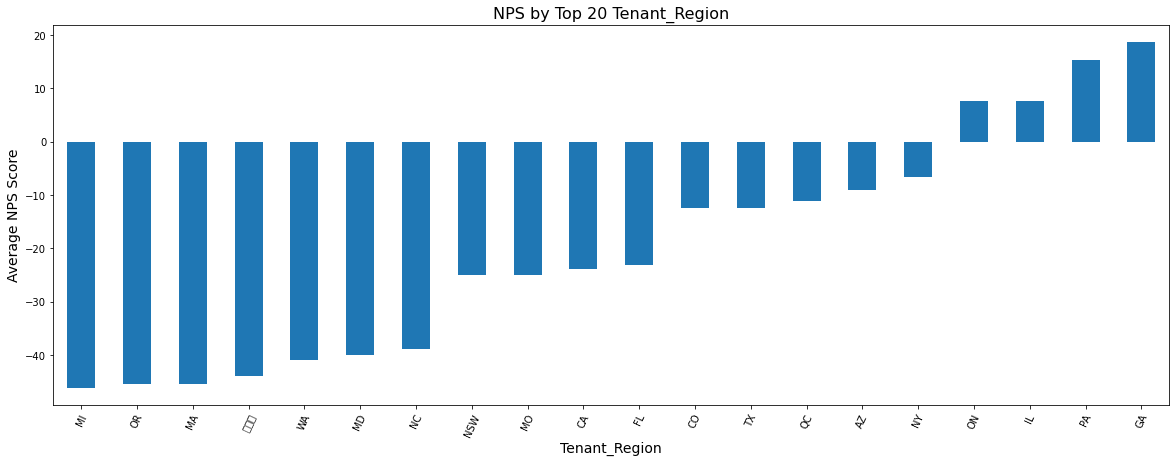

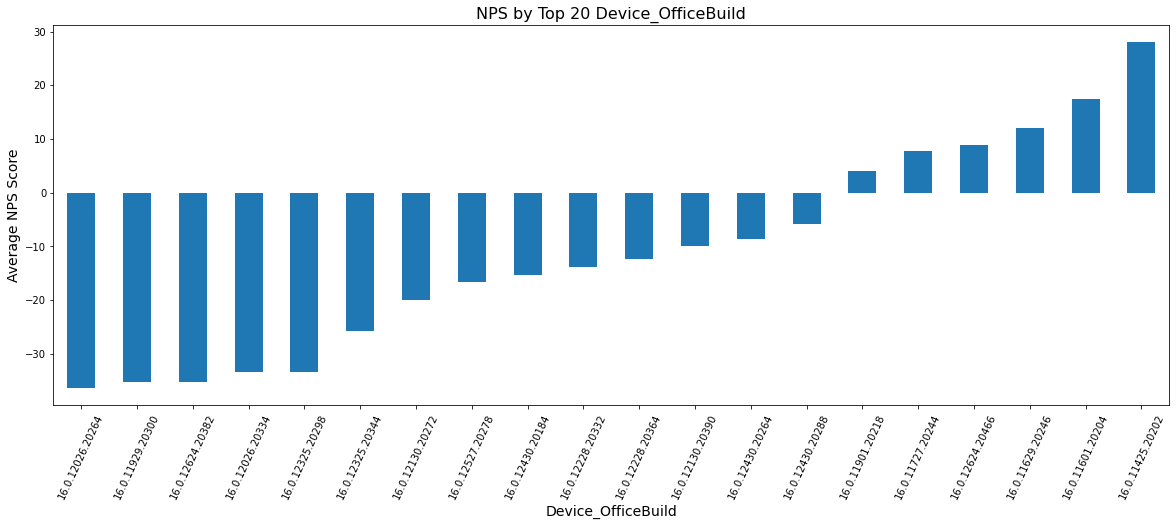

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 22522 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 30436 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 36939 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 29992 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 65306 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 12477 missing from c

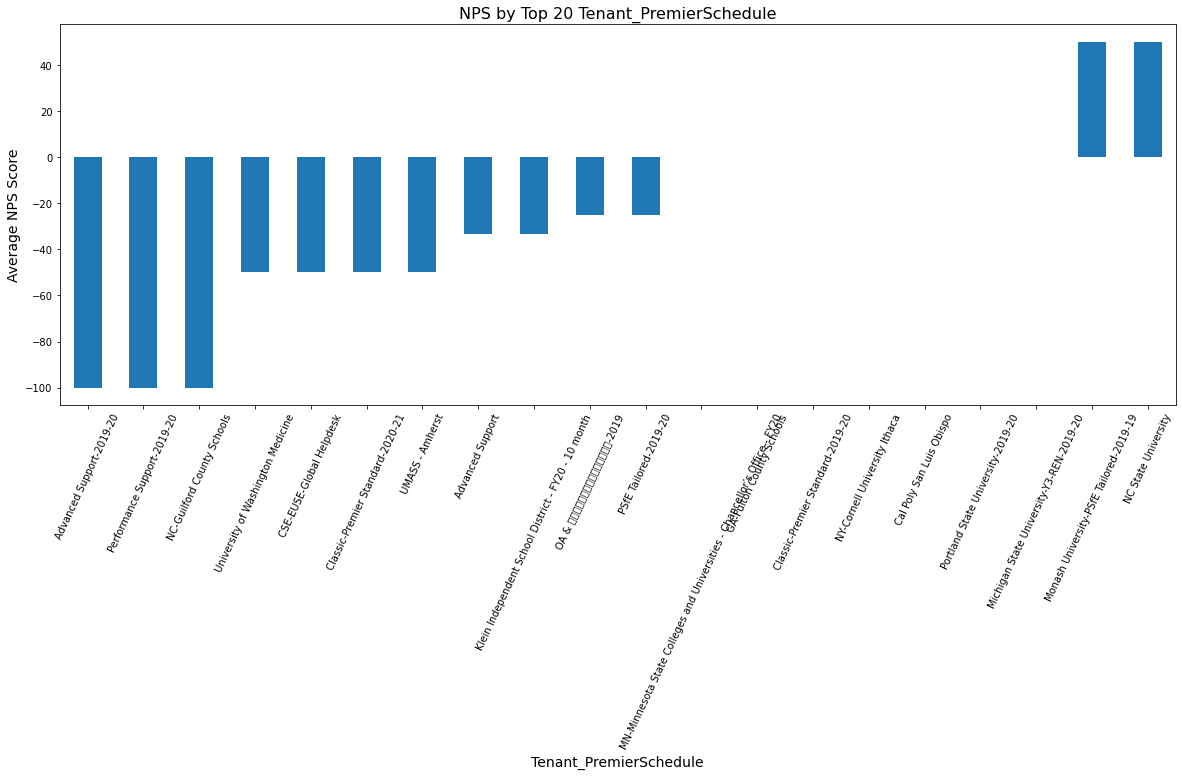

In [650]:
plot_cats(suite_compete_commercial_edu_important_features)

In [652]:
suite_compete_commercial_edu_important_features.dtypes

Device_DeviceModel            object
Tenant_Region                 object
Device_OfficeBuild            object
Tenant_PremierSchedule        object
Tenant_Tenure                float64
Device_SysVolSizeMB          float64
Tenant_LYOEnabledUsers       float64
Tenant_EXOEnabledUsers       float64
Device_SysVolFreeSpaceMB     float64
Tenant_PaidAvailableUnits    float64
Feedback_RatingValue           int64
dtype: object

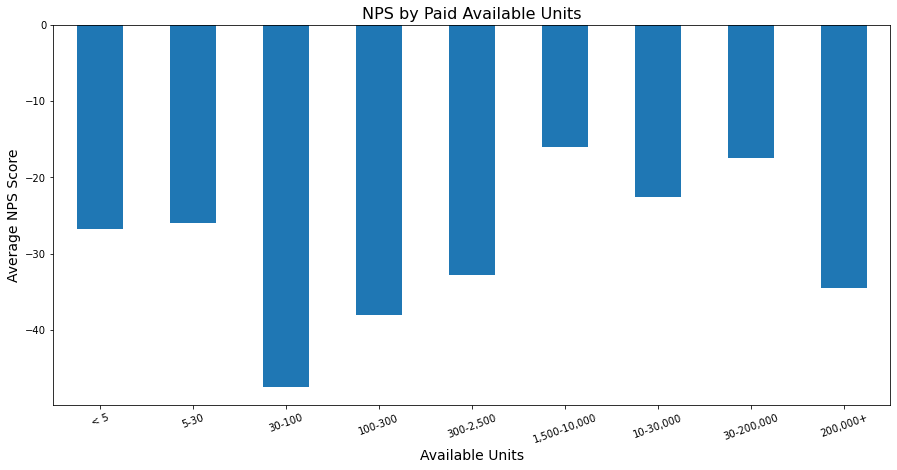

In [666]:
plot_nums(suite_compete_commercial_edu_important_features, 'Tenant_PaidAvailableUnits', 'NPS by Paid Available Units', 'Available Units', 
          bins = [0, 5, 30, 100, 300, 2500, 10000, 30000, 200000, 10000000000000000],
          labels = ['< 5', '5-30', '30-100', '100-300', '300-2,500', '1,500-10,000', '10-30,000', '30-200,000', '200,000+'], method = 'cut')

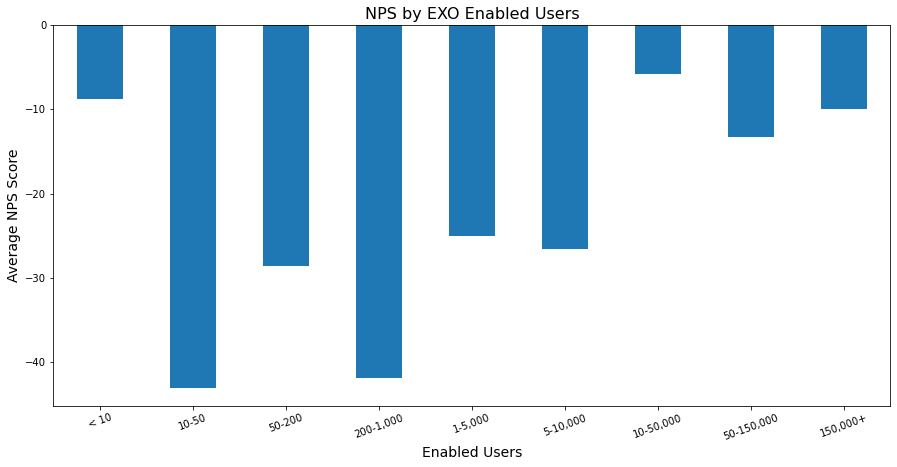

In [664]:
plot_nums(suite_compete_commercial_edu_important_features, 'Tenant_EXOEnabledUsers', 'NPS by EXO Enabled Users', 'Enabled Users', 
          bins = [0, 10, 50, 200, 1000, 5000, 10000, 50000, 150000, 10000000000000],
          labels = ['< 10', '10-50', '50-200', '200-1,000', '1-5,000', '5-10,000', '10-50,000', '50-150,000', '150,000+'], method = 'cut')

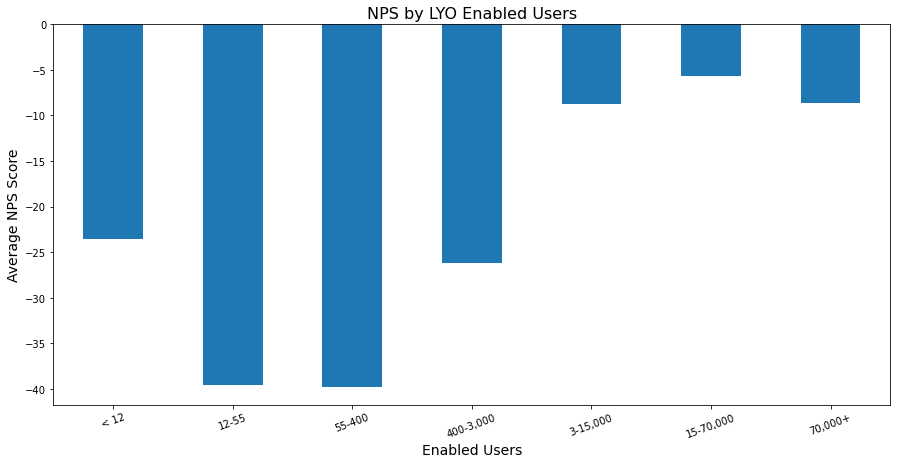

In [662]:
plot_nums(suite_compete_commercial_edu_important_features, 'Tenant_LYOEnabledUsers', 'NPS by LYO Enabled Users', 'Enabled Users', 
          bins = [0, 12, 55, 400, 3000, 15000, 70000, 1000000000000],
          labels = ['< 12', '12-55', '55-400', '400-3,000','3-15,000', '15-70,000', '70,000+'], method = 'cut')

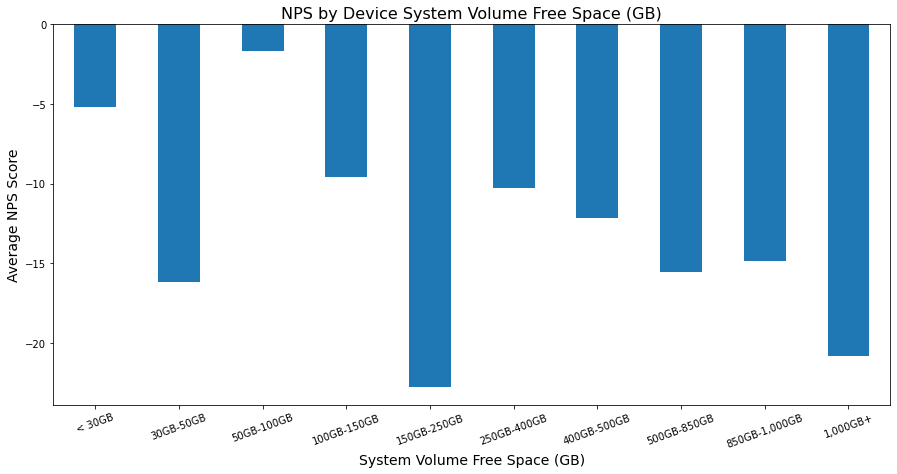

In [653]:
plot_nums(suite_compete_commercial_edu_important_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

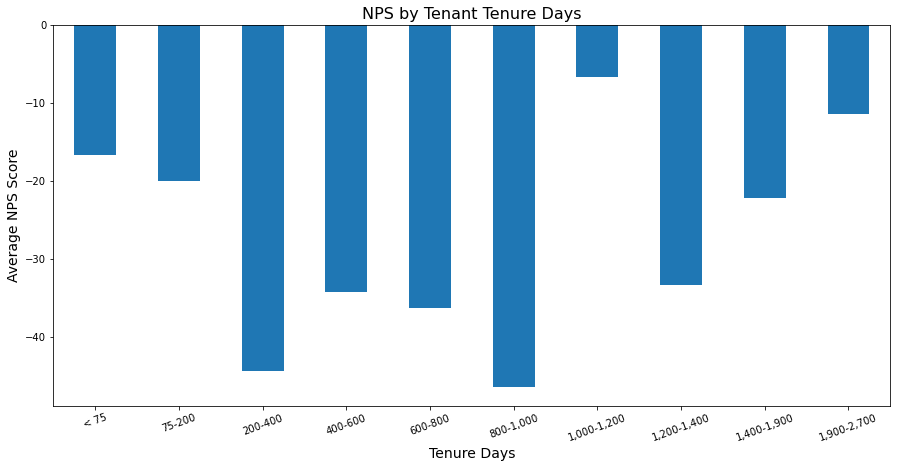

In [657]:
plot_nums(suite_compete_commercial_edu_important_features, 'Tenant_Tenure', 'NPS by Tenant Tenure Days', 'Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

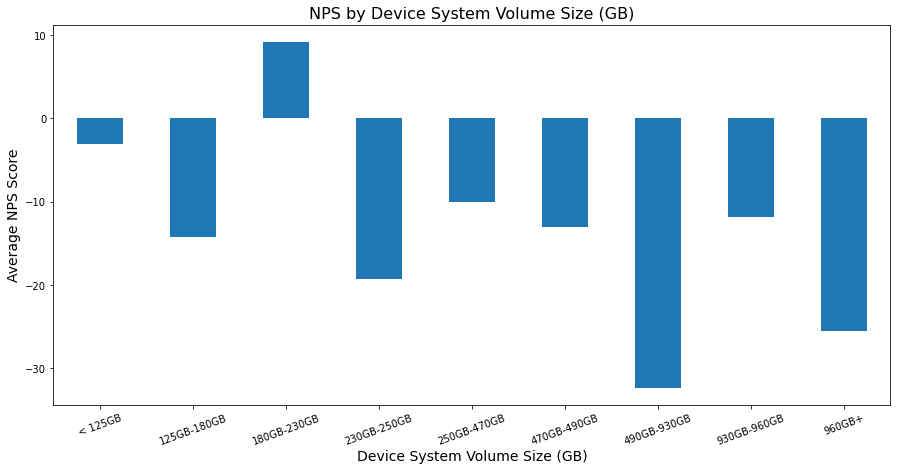

In [658]:
plot_nums(suite_compete_commercial_edu_important_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.7s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   16.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   35.2s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   50.0s remaining:   10.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.1min remaining:    4.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.1min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

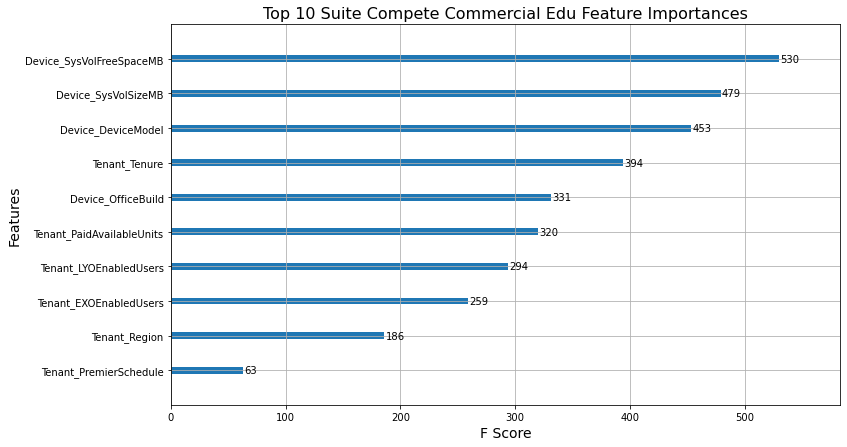

In [684]:
suite_compete_commedu_feats, suite_compete_commedu_model = find_important_features(suite_compete_commercial_edu_important_features.drop('Feedback_RatingValue', axis = 1),
                                                                              suite_compete_commercial_edu_important_features['Feedback_RatingValue'], model ='xgboost', encode = True)

plt.figure(figsize = (12, 10))
ax = plot_importance(suite_compete_commedu_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 Suite Compete Commercial Edu Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

## Suite Compete Commercial Non-Edu

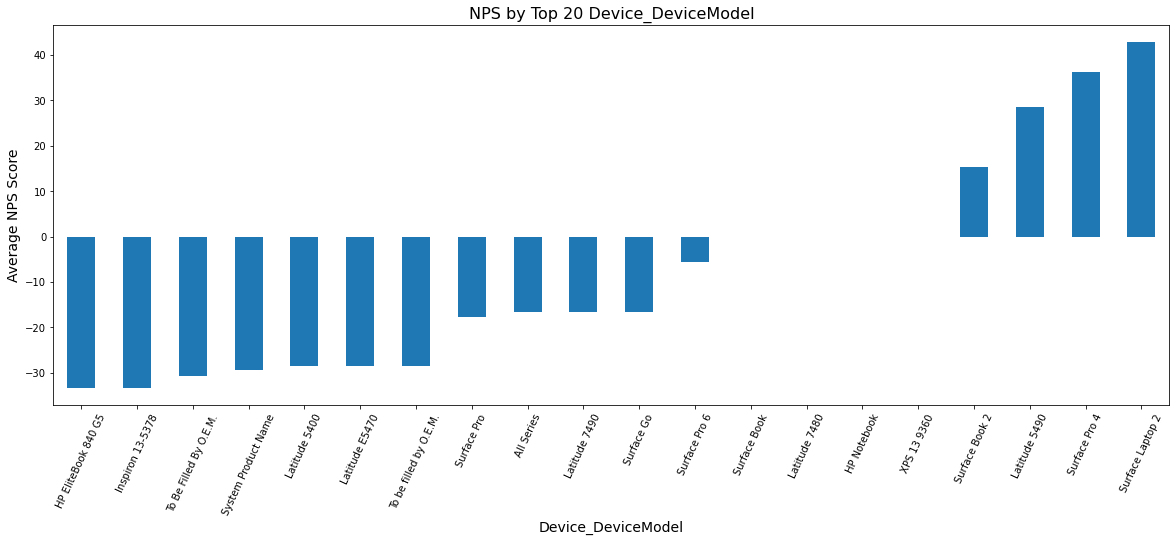

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37117 missing from curre

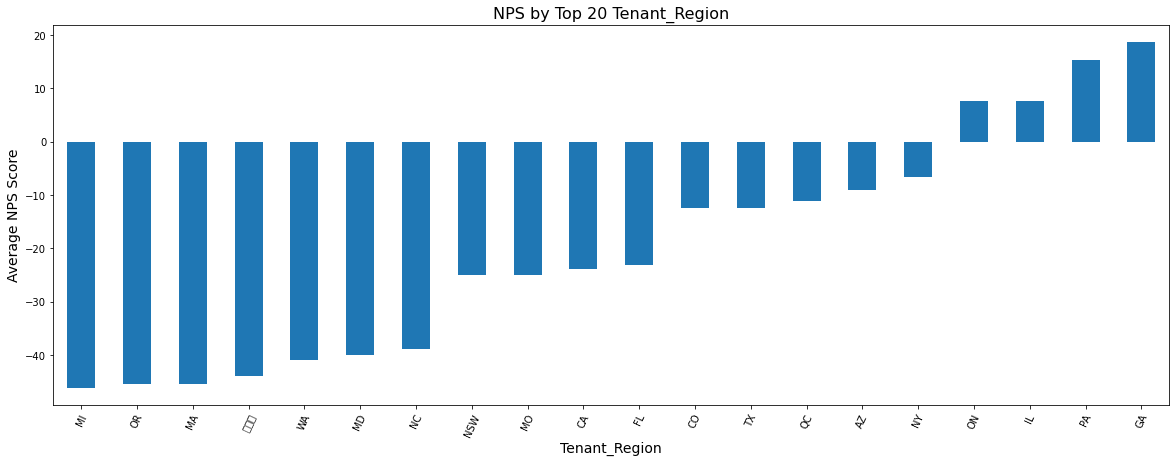

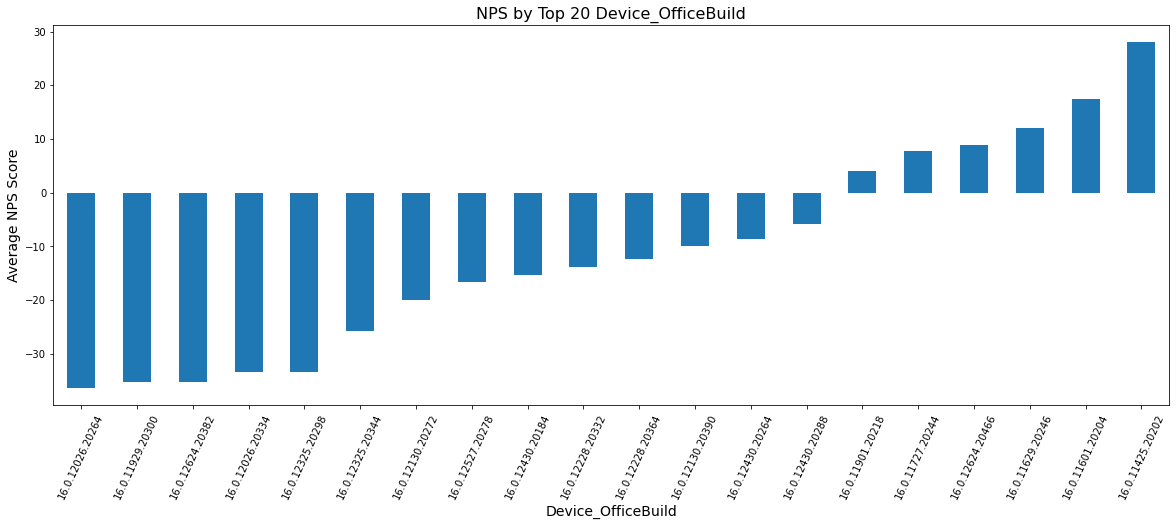

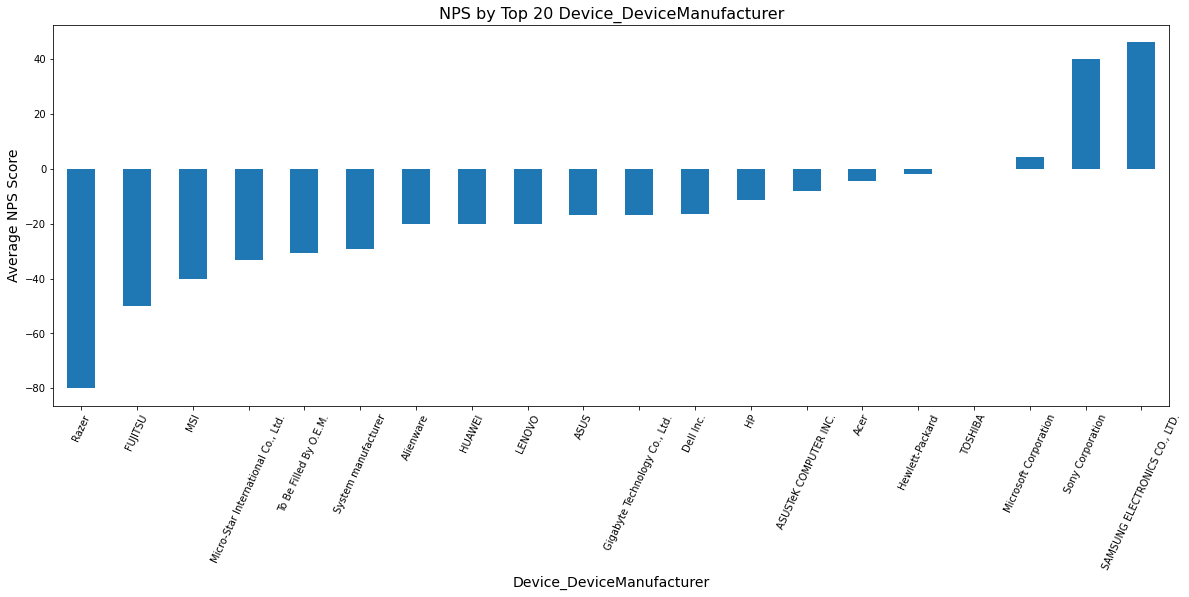

In [669]:
plot_cats(suite_compete_commercial_nonedu_important_features) 

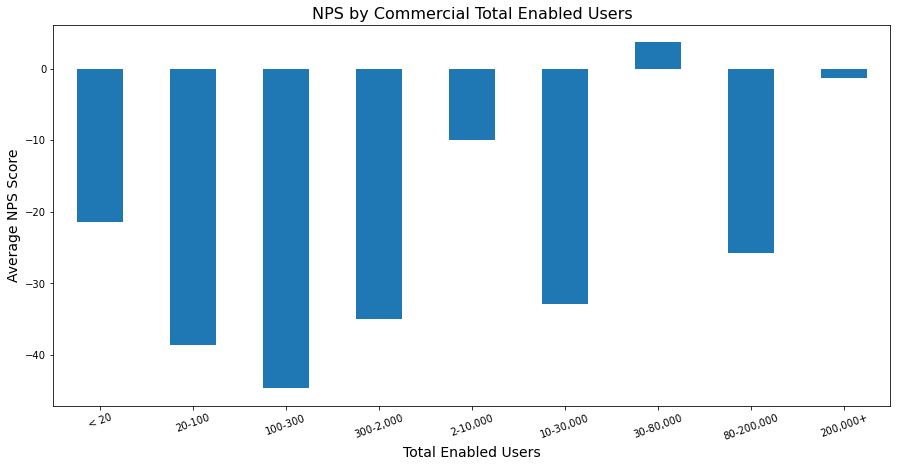

In [681]:
plot_nums(suite_compete_commercial_nonedu_important_features, 'User_Commercial_TotalEnabledUsers', 'NPS by Commercial Total Enabled Users', 'Total Enabled Users', 
          bins = [0, 20, 100, 300, 2000, 10000, 30000, 80000, 200000, 1000000000000],
          labels = ['< 20', '20-100', '100-300', '300-2,000', '2-10,000', '10-30,000', '30-80,000', '80-200,000', '200,000+'], method = 'cut')

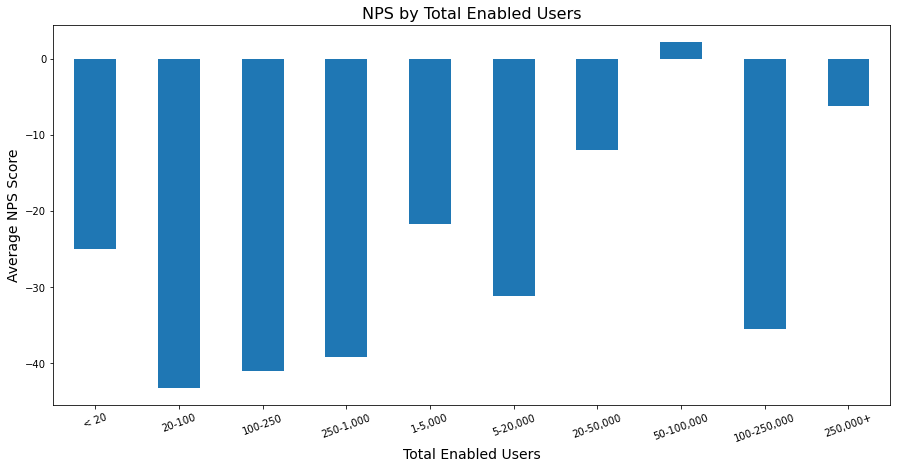

In [678]:
plot_nums(suite_compete_commercial_nonedu_important_features, 'Tenant_TotalEnabledUsers', 'NPS by Total Enabled Users', 'Total Enabled Users', 
          bins = [0, 20, 100, 250, 1000, 5000, 20000, 50000, 100000, 250000, 100000000000000],
          labels = ['< 20', '20-100', '100-250', '250-1,000', '1-5,000', '5-20,000', '20-50,000', '50-100,000', '100-250,000', '250,000+'], method = 'cut')

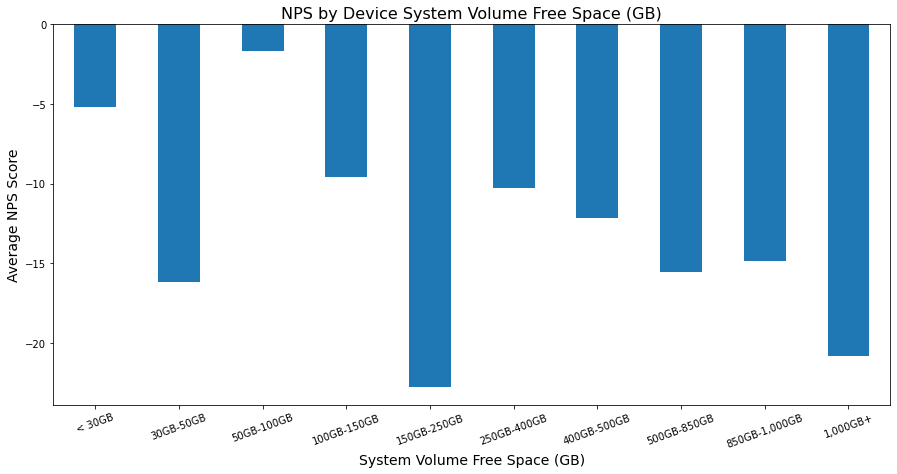

In [671]:
plot_nums(suite_compete_commercial_nonedu_important_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

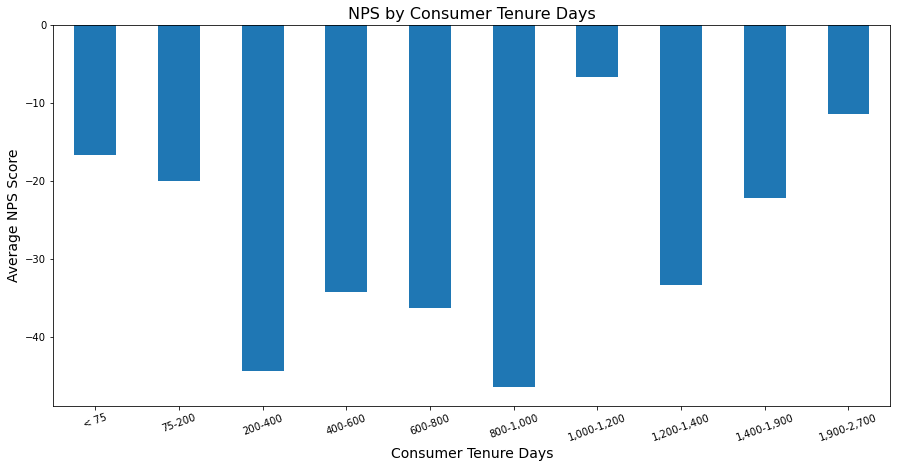

In [674]:
plot_nums(suite_compete_commercial_nonedu_important_features, 'Tenant_Tenure', 'NPS by Consumer Tenure Days', 'Consumer Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

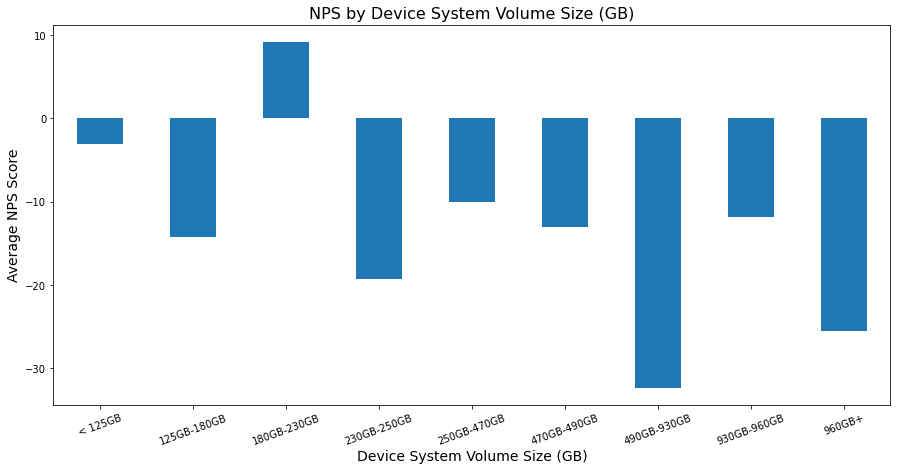

In [675]:
plot_nums(suite_compete_commercial_nonedu_important_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

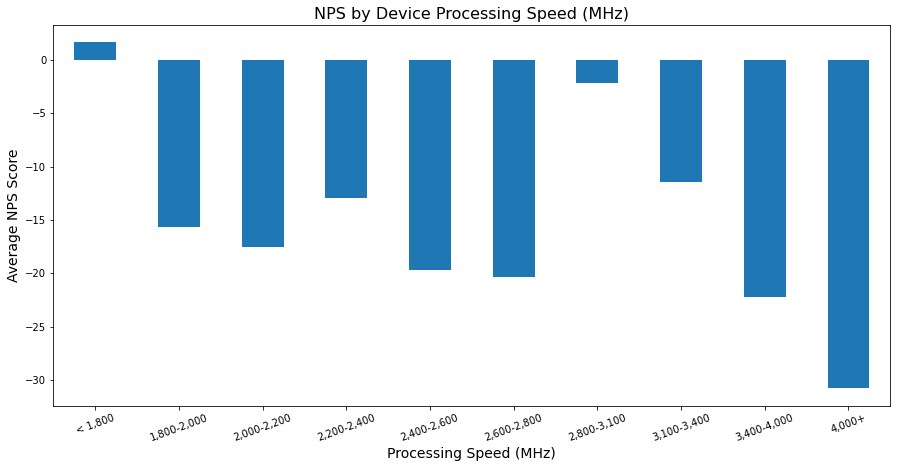

In [676]:
plot_nums(suite_compete_commercial_nonedu_important_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   21.7s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.7s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   53.8s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.0min remaining:   13.4s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.1min remaining:    4.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.2min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

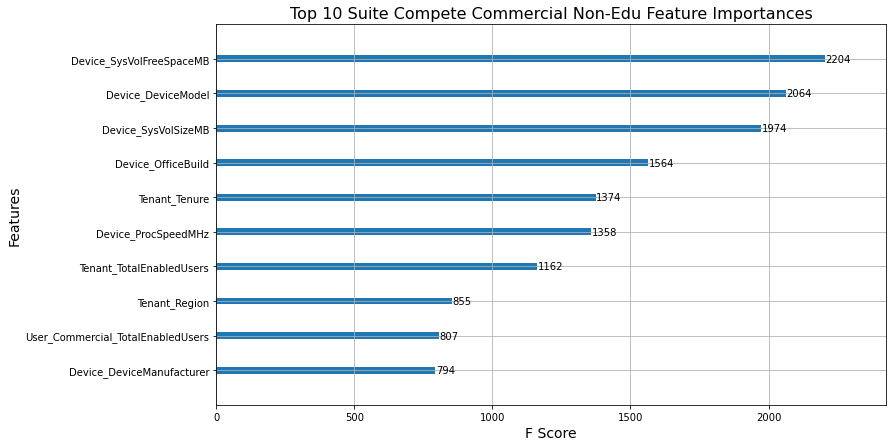

In [683]:
suite_compete_nonedu_feats, suite_compete_nonedu_model = find_important_features(suite_compete_commercial_nonedu_important_features.drop('Feedback_RatingValue', axis = 1),
                                                                              suite_compete_commercial_nonedu_important_features['Feedback_RatingValue'], model ='xgboost', encode = True)

plt.figure(figsize = (12, 10))
ax = plot_importance(suite_compete_nonedu_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 Suite Compete Commercial Non-Edu Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

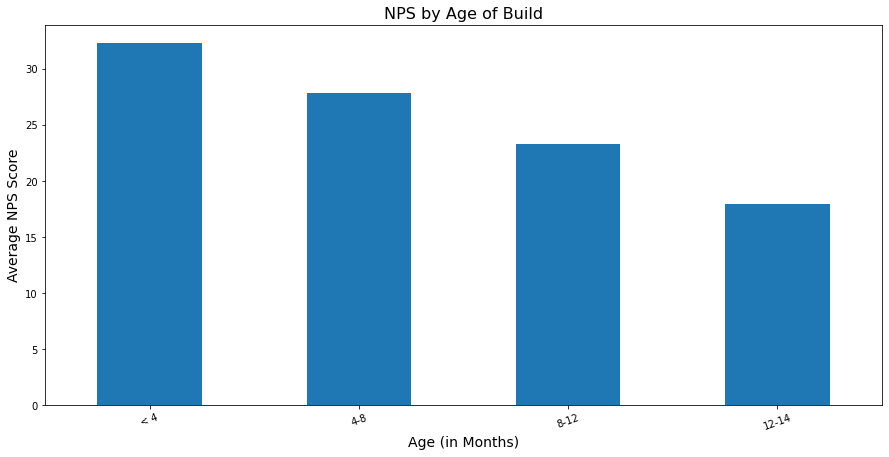

In [1473]:
plot_nums(top_builds_nps, 'Months_Old', 'NPS by Age of Build', 'Age (in Months)', bins = [0, 4, 8, 12, 14], labels = ['< 4', '4-8', '8-12', '12-14'], method = 'cut')

# App Driver Analysis

In [179]:
#read in all data from kusto and ngramthemes and concatenate together, doing this in chunks makes it easier for the data to fit into memory
ngrams = pd.read_csv('App_NgramThemePredictions_Subsvals.csv')
df = pd.read_csv('app_other_vars_100.csv', chunksize = 10000)
df2 = pd.read_csv('app_other_vars_200.csv', chunksize = 10000)
df3 = pd.read_csv('app_other_vars_300.csv', chunksize = 10000)
df4 = pd.read_csv('app_other_vars_400.csv', chunksize = 10000)
df5 = pd.read_csv('app_other_vars_500.csv', chunksize = 10000)

#create list for dfs
dfs=[df, df2, df3, df4, df5]

#create empty list for data to be fed into
chunks = []

#loop through dfs and merge based on feedback id, keeping only those cases that match
for df in dfs:
    for chunk in df:
        chunk = ngrams.merge(chunk, how= 'inner', on = 'Feedback_ID')
        chunks.append(chunk)
    
app = pd.concat(chunks)

#drop and duplicated rows
app.drop_duplicates(subset = ['Feedback_ID'], inplace = True)

In [1371]:
#this should be the same shape as the app dataset that Chris uploaded
app.shape

(35152, 327)

In [187]:
app.to_csv('merged_final_app_driver_data.csv', index = False)

In [392]:
pwd

'C:\\Users\\fulto\\Desktop\\Driver Analysis\\Suite and App'

In [393]:
os.chdir('C:\\Users\\fulto\\Desktop\\Driver Analysis')
app = pd.read_csv('merged_final_app_driver_data.csv')

C:\Users\fulto\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (23,55,65,67,77,78,81,82,83,84,86,87,88,89,91,108,109,140,162,186,188,190,191,192,193,198,199,200,203,205,207,212,217,218,219,220,221,224,226,227,239,240,241,242,243,247) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [394]:
app.NgramThemePredictions.value_counts()

cost            19163
compete         15069
compete,cost      920
Name: NgramThemePredictions, dtype: int64

In [395]:
#get rid of _x introduced in the merge
app.rename(columns = {'Feedback_App_x':'Feedback_App'}, inplace = True)
app.rename(columns = {'Feedback_Rating_x':'Feedback_Rating'}, inplace = True)

In [257]:
#separate into cost and compete dfs
app_cost = app[app['NgramThemePredictions'] == 'cost']
app_compete = app[app['NgramThemePredictions'] == 'compete']

In [258]:
#remove columns with mostly missing data for both data sets
app_cost = remove_completely_missing_columns(app_cost)
app_compete = remove_completely_missing_columns(app_compete)

shape before deleting missing columns: (19163, 327)
shape after deleting missing columns: (19163, 60)
shape before deleting missing columns: (15069, 327)
shape after deleting missing columns: (15069, 243)


In [259]:
#drop everything that doesn't have a corresponding app
app_cost.dropna(subset = ['Feedback_App'], inplace = True)

In [260]:
#imputing missing values - different filler function from suite, only using one "filler" here
def fill_na(df, feature, filler, method = None):
    
    '''
    
    this function fills in missing values with your method of choice (depending on expanding function and specifying method)
    
    '''
    
    if method == 'mode':
    
        df[feature] = df.groupby([filler])[f'{feature}'].transform(lambda x: x.replace(np.nan, x.value_counts().index[0]))
        
    if method == 'mean':
        
        df[feature] = df.groupby([filler])[f'{feature}'].transform(lambda x: x.replace(np.nan, x.mean()))
        
    return df

#create list of columns with missing values
cost_missing_cols = []

for idx, row in pd.DataFrame(app_cost.isna().sum()).iterrows():
    if row[0] > 0:
        cost_missing_cols.append(idx)

#get compete missing columns 
compete_missing_cols = []

for idx, row in pd.DataFrame(app_compete.isna().sum()).iterrows():
    if row[0] > 0:
        compete_missing_cols.append(idx)
        
#fill nas with mode of grouped region and feedback source
for col in cost_missing_cols:
    if app_cost[col].dtype != 'O':
        try:
            app_cost = fill_na(app_cost, col, 'Feedback_App_x', method = 'mean')
        except:
            pass
#needed to pass errors since some of the groupbys were creating nas
for col in compete_missing_cols:
    if app_compete[col].dtype != 'O':
        try:
            app_compete = fill_na(app_compete, col, 'Feedback_Source', method = 'mode')
        except:
            pass
        
#fill remaining nas with mode of suite compete columns 
app_compete[compete_missing_cols] = app_compete[compete_missing_cols].fillna(app_compete.mode().iloc[0])

#fill remaining nas in suite cost with mode of column
app_cost[cost_missing_cols] = app_cost[cost_missing_cols].fillna(app_cost.mode().iloc[0])

In [261]:
app_cost = throw_out_useless_features(app_cost)
app_compete = throw_out_useless_features(app_compete)

Shape before: (19157, 60)
Shape after throwing them out: (19157, 27)
Shape before: (15069, 243)
Shape after throwing them out: (15069, 157)


In [262]:
app_cost.drop('Feedback_Rating', axis = 1, inplace = True)
app_compete.drop('Feedback_Rating', axis = 1, inplace = True)

In [1707]:
#get feature importances through random forest
app_cost_important_features = find_important_features(app_cost.drop('Feedback_RatingValue', axis = 1), app_cost['Feedback_RatingValue'], model = 'random forest', encode = True)
app_compete_important_features = find_important_features(app_compete.drop('Feedback_RatingValue', axis = 1), app_compete['Feedback_RatingValue'], model = 'random forest', 
                                                        encode = True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   31.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  1.6min remaining:   21.6s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  1.8min remaining:    6.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   34.3s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   43.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  2.3min remaining:   30.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  3.4min remaining:   12.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  3.8min finished


In [1708]:
#take top 10 features from feature importances -- using same function written for suite analysis
app_cost_top_10_features = get_top_10_feats(app_cost_important_features, app_or_suite = app, subset = 'cost')
app_compete_top_10_features = get_top_10_feats(app_compete_important_features, app_or_suite = app, subset = 'compete')

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   57.2s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 13.2min remaining:  2.9min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 17.2min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 17.9min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

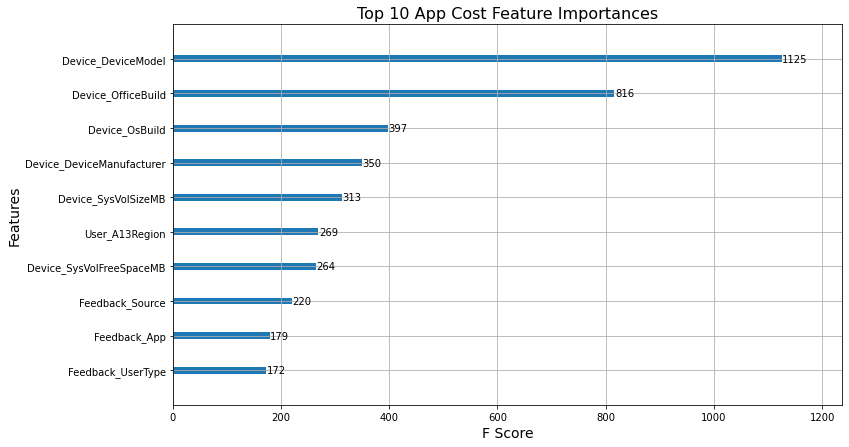

In [1709]:
#run data through xgboost for final feature importances
app_cost_top_features, app_cost_model = find_important_features(app_cost_top_10_features.drop('Feedback_RatingValue', axis = 1), 
                                                         app_cost_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)
plt.figure(figsize = (12, 10))
ax = plot_importance(app_cost_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 App Cost Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  4.0min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 10.0min remaining:  2.2min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 10.5min remaining:   40.2s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 11.3min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

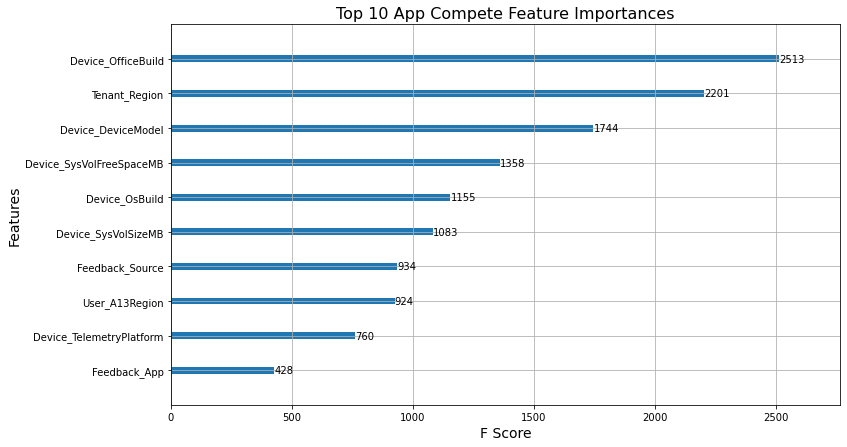

In [1710]:
app_compete_top_features, app_compete_model = find_important_features(app_compete_top_10_features.drop('Feedback_RatingValue', axis = 1), 
                                                                      app_compete_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)
plt.figure(figsize = (12, 10))
ax = plot_importance(app_compete_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 App Compete Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

In [482]:
#plotting these feature importances with a % of time used
app_compete_feats = ['Device_OfficeBuild', 'Tenant_Region', 'Device_DeviceModel', 'Device_SysVolFreeSpaceMB', 'Device_OsBuild', 'Device_SysVolSizeMB', 'Feedback_Source',
                    'User_A13Region', 'Device_TelemetryPlatform', 'Feedback_App']
app_compete_splits = [2513, 2201, 1744, 1358, 1155, 1083, 934, 924, 760, 428]

app_cost_feats = ['Device_DeviceModel', 'Device_OfficeBuild', 'Device_OsBuild', 'Device_DeviceManufacturer', 'Device_SysVolSizeMB', 'User_A13Region', 'Device_SysVolFreeSpaceMB',
                 'Feedback_Source', 'Feedback_App', 'Feedback_UserType']
app_cost_splits = [1125, 816, 397, 350, 313, 269, 264, 220, 179, 172]

app_compete_feats_importances = pd.DataFrame({'features':app_compete_feats, 'splits':app_compete_splits, 'split_%':[x/sum(app_compete_splits) for x in app_compete_splits]})
app_cost_feats_importances = pd.DataFrame({'features':app_cost_feats, 'splits':app_cost_splits, 'split_%':[x/sum(app_cost_splits) for x in app_cost_splits]})

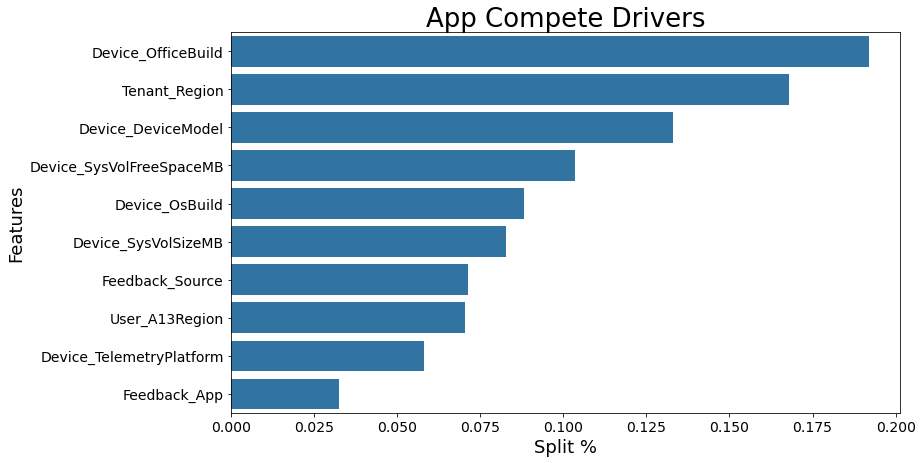

In [483]:
#plot barplots for feature importances
plt.figure(figsize = (12, 7))
sns.barplot(y = 'features', x = 'split_%', data = app_compete_feats_importances, color = 'tab:blue')
plt.title('App Compete Drivers', fontsize = 26)
plt.xlabel('Split %', fontsize = 18)
plt.ylabel('Features', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

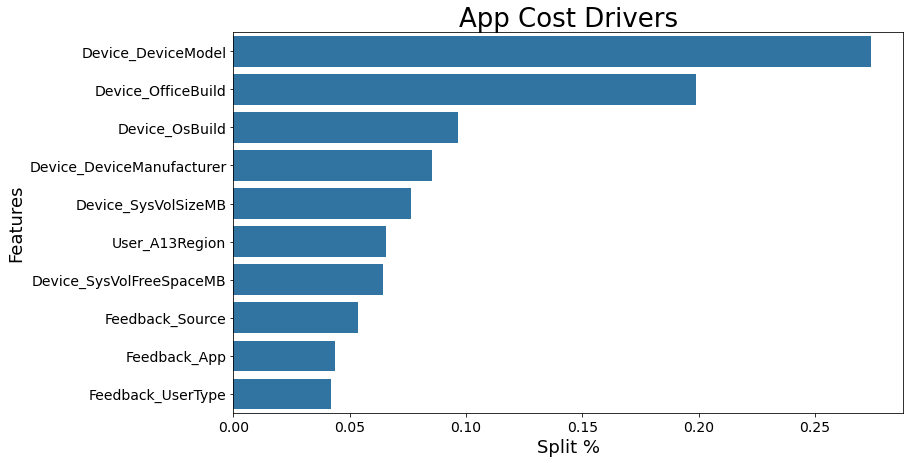

In [484]:
#plot barplots for feature importances
plt.figure(figsize = (12, 7))
sns.barplot(y = 'features', x = 'split_%', data = app_cost_feats_importances, color = 'tab:blue')
plt.title('App Cost Drivers', fontsize = 26)
plt.xlabel('Split %', fontsize = 18)
plt.ylabel('Features', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14);

## App Cost Plots

In [187]:
# Getting NPS average for all apps -- this is the SQL query I used in Kusto
SELECT DATEPART(year, Feedback_DateTime) AS year, AVG(CAST(Feedback_RatingValue AS FLOAT)) AS avg_nps
FROM EndUserAppNPS()
GROUP BY DATEPART(year, Feedback_DateTime)
 ORDER BY year

In [188]:
def get_app_office_builds(df):
    
    '''
    
    this function returns a dataframe with the app build numbers and their corresponding mean NPS scores, use this to look up app build numbers online to get the age of the build
    
    '''
    
    top_app_builds = pd.DataFrame(df['Device_OfficeBuild'].value_counts().nlargest(20)).reset_index().rename(columns = {'index':'build'})['build']
    
    build_nps = pd.DataFrame(app_cost.groupby(['Device_OfficeBuild', 'Feedback_App']).Feedback_RatingValue.mean()).reset_index()
    
    top_builds_app = build_nps[build_nps['Device_OfficeBuild'].isin(top_app_builds)]
    
    top_builds_app = top_builds_app.drop_duplicates(subset = 'Device_OfficeBuild')
    
    return top_builds_app

In [190]:
top_builds_app_cost = get_app_office_builds(app_cost)

__Some of these builds I could not find online at all, so I trimmed the set to the ones that I was able to find__

In [191]:
top_builds_app_cost = top_builds_app_cost.iloc[2:, :]

In [192]:
top_builds_app_cost = top_builds_app_cost.iloc[:12,:]

In [195]:
age_months = [16, 15, 14, 13, 12, 9, 6, 6, 5, 4, 3, 2]

In [196]:
top_builds_app_cost['Months_Old'] = age_months

In [197]:
top_builds_app_cost

Device_OfficeBuild Feedback_App  Feedback_RatingValue  Months_Old
192   16.0.11328.20080        Excel              6.250000          16
220   16.0.11425.20132        Excel             21.276596          15
276   16.0.11601.20074        Excel             11.363636          14
330   16.0.11629.20124        Excel             12.903226          13
369   16.0.11727.20104        Excel             30.000000          12
485   16.0.12026.20174        Excel              7.692308           9
600   16.0.12228.20364        Excel             22.222222           6
629   16.0.12325.20174        Excel              5.263158           6
680   16.0.12430.20120        Excel             -9.090909           5
725   16.0.12527.20090        Excel             30.000000           4
741   16.0.12527.20278        Excel            -15.000000           3
790   16.0.12624.20466        Excel            -22.222222           2

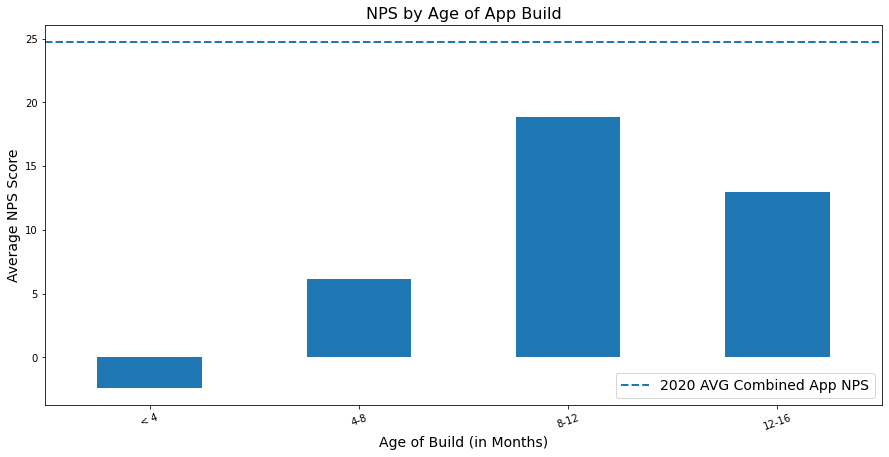

In [201]:
plot_nums(24.7200777301251, top_builds_app_cost, 'Months_Old', 'app', 'NPS by Age of App Build', 'Age of Build (in Months)', 
          bins = [0, 4, 8, 12, 16], labels = ['< 4', '4-8', '8-12', '12-16'], method = 'cut')
plt.legend(labels = ['2020 AVG Combined App NPS'], fontsize = 14)

In [213]:
#use this if the kernel dies to subset app
app_cost_top_10_features = app_cost[['Device_DeviceModel', 'Device_OfficeBuild', 'Device_OsBuild', 'Device_DeviceManufacturer', 'Device_SysVolSizeMB', 
                                     'User_A13Region', 'Device_SysVolFreeSpaceMB',
                    'Feedback_Source', 'Feedback_App', 'Feedback_UserType', 'Feedback_RatingValue']]

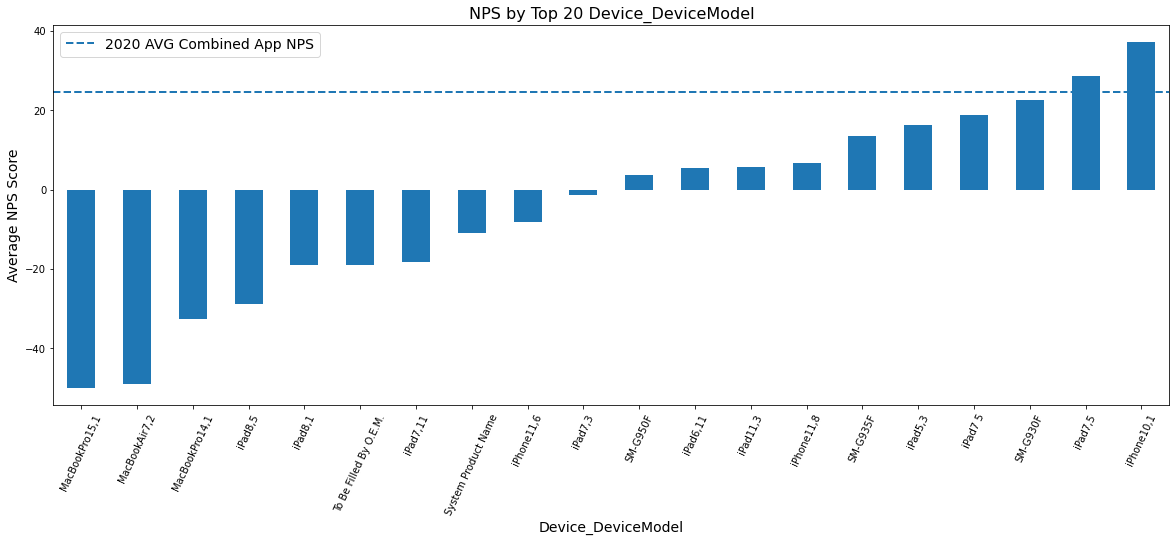

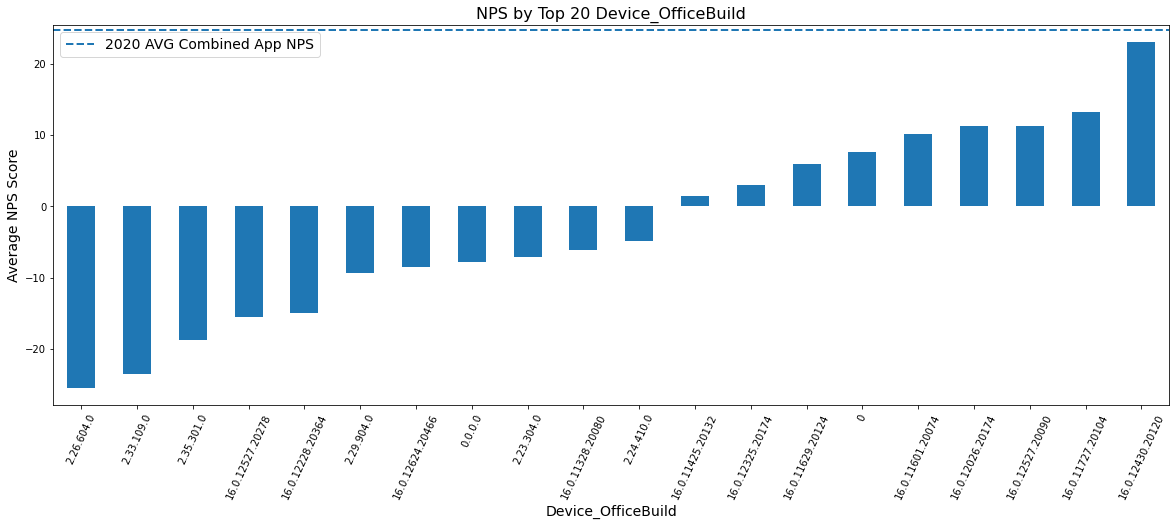

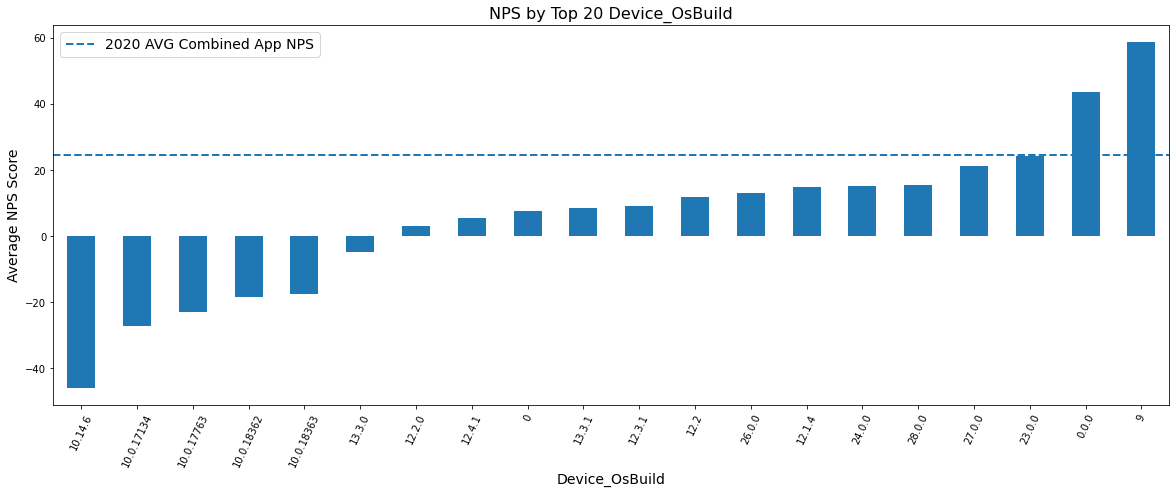

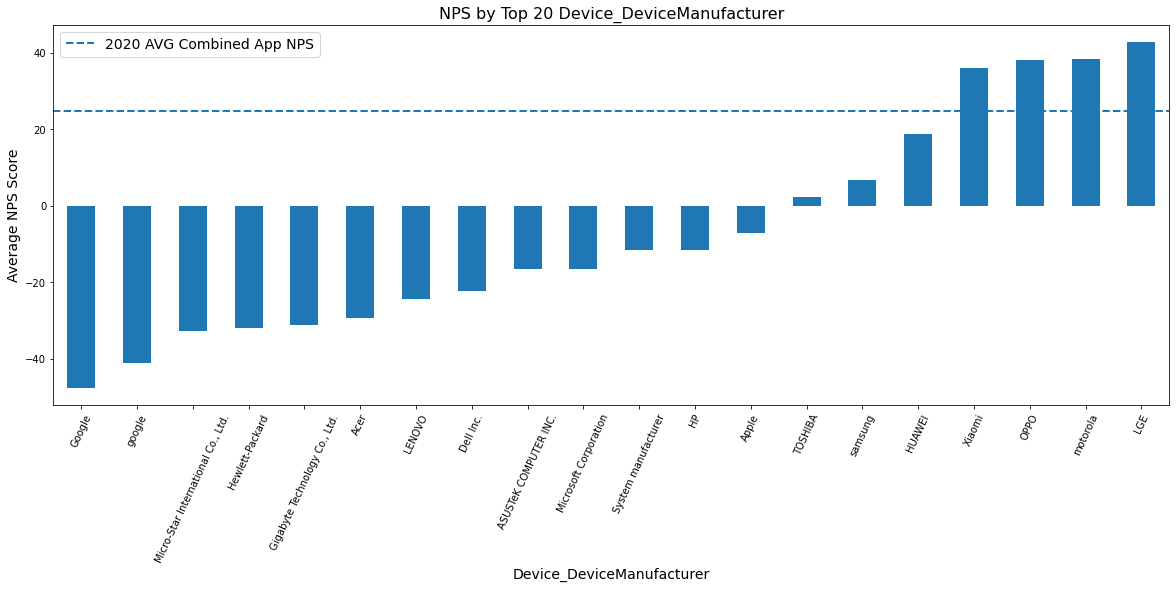

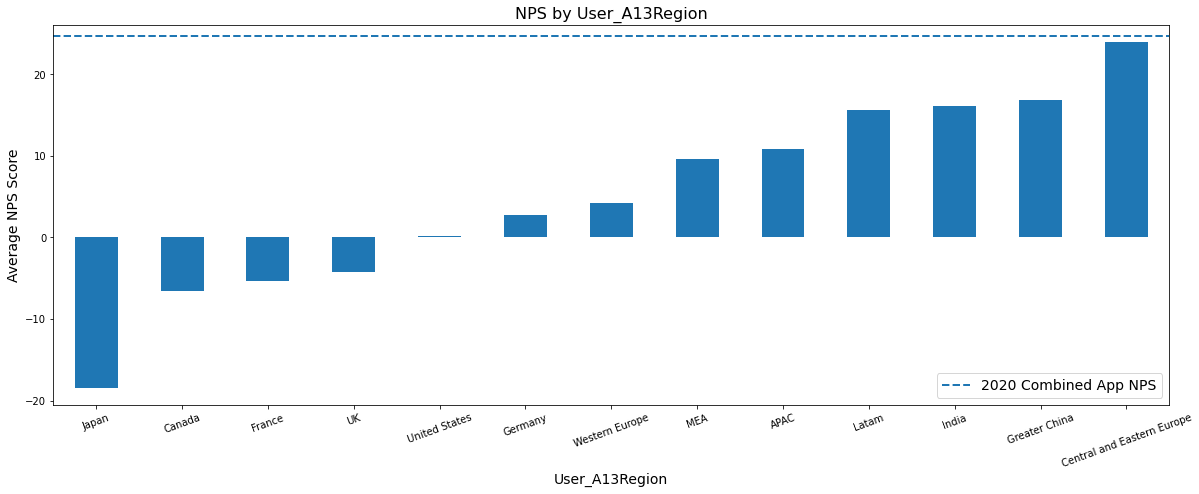

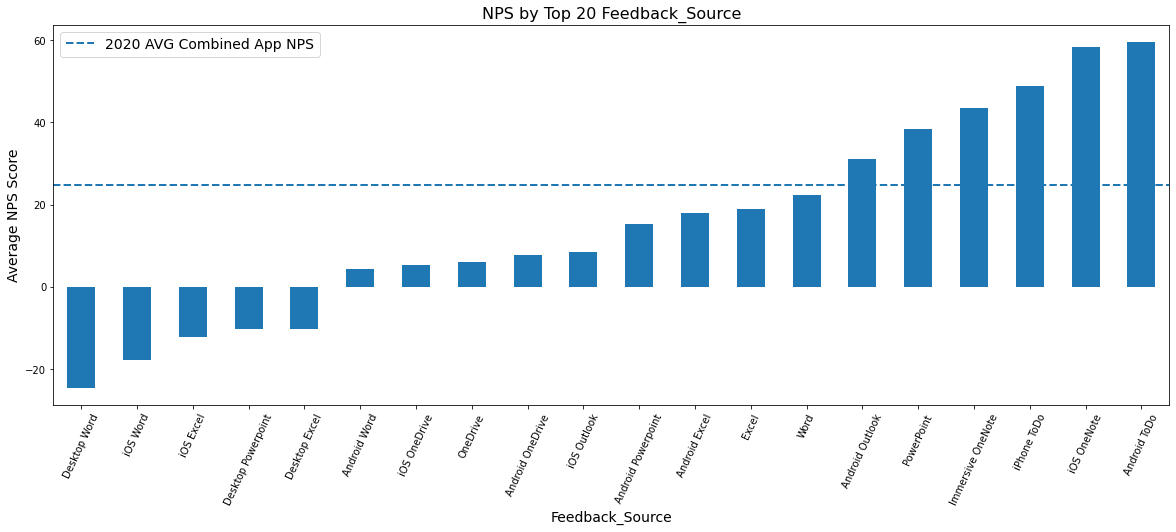

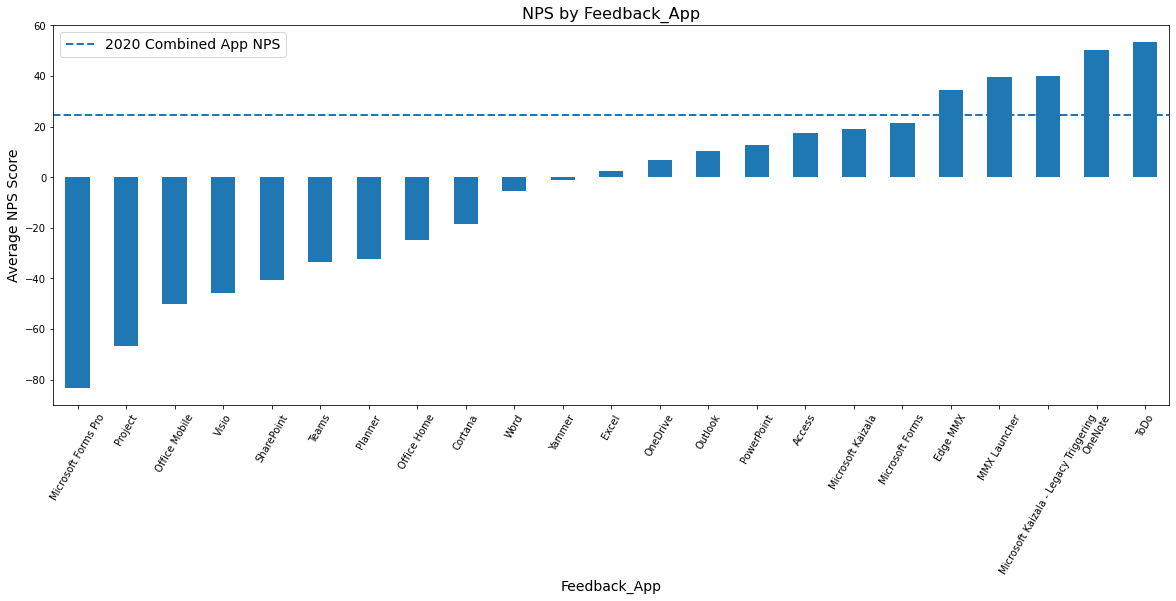

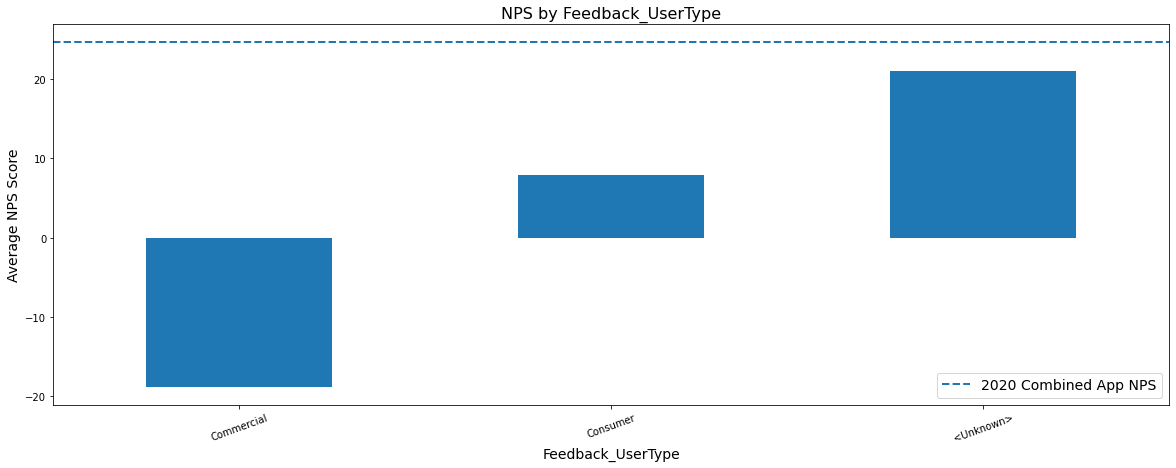

In [226]:
plot_cats(app_cost_top_10_features, 24.7200777301251, 'app')

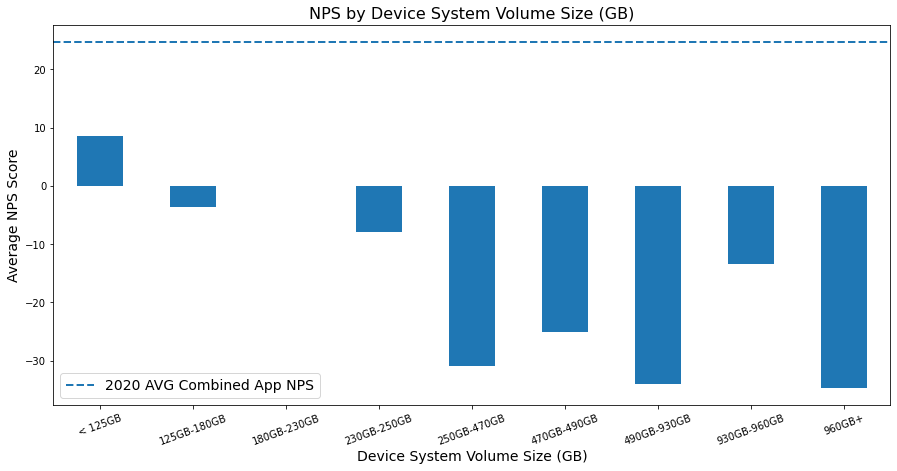

In [244]:
plot_nums(24.7200777301251, app_cost_top_10_features, 'Device_SysVolSizeMB', 'app', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')
plt.legend(labels = ['2020 AVG Combined App NPS'], fontsize = 14)

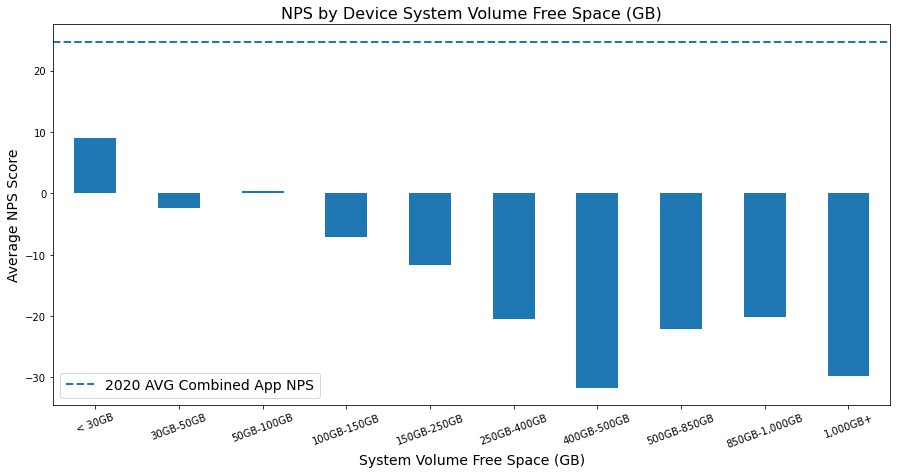

In [245]:
plot_nums(24.7200777301251, app_cost_top_10_features, 'Device_SysVolFreeSpaceMB', 'app',  'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')
plt.legend(labels = ['2020 AVG Combined App NPS'], fontsize = 14)

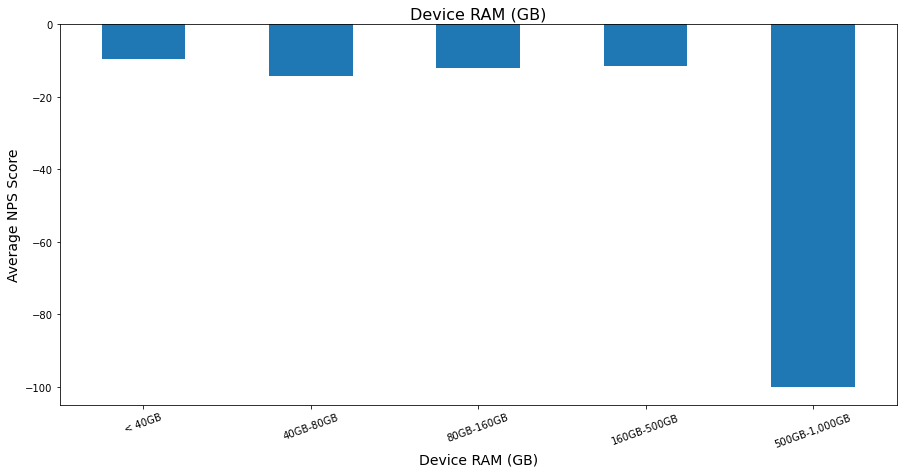

In [737]:
plot_nums(app_cost_top_10_features, 'Device_RamMB', 'Device RAM (GB)', 'Device RAM (GB)', bins = [0, 4000, 8000, 16000, 50000, 100000],
          labels = ['< 40GB', '40GB-80GB', '80GB-160GB', '160GB-500GB', '500GB-1,000GB'], method = 'cut')

## App Compete Plots

In [1559]:
#find app build numbers, finding the ones that don't begin with "16.0" is really difficult, I have yet to find any 
get_app_office_builds(app_compete)

Device_OfficeBuild     Feedback_App  Feedback_RatingValue
0                     0          Cortana            -25.000000
2               0.0.0.0  Microsoft Forms             21.428571
600    16.0.12228.20364            Excel             22.222222
741    16.0.12527.20278            Excel            -15.000000
780    16.0.12624.20382           Access           -100.000000
934         16.24.414.0            Excel              0.000000
947         16.26.609.0            Excel            -41.666667
1199            3.0.107          Outlook             10.810811
1208             3.0.18          Outlook             29.166667
1209             3.0.22          Outlook             15.789474
1210             3.0.26          Outlook             15.789474
1215             3.0.46          Outlook             22.549020
1223             3.0.73          Outlook             29.629630
1224             3.0.76          Outlook             30.357143
1228             3.0.88          Outlook             19.512195
1230             3.0.92          Outlook             30.000000
1231             3.0.98          Outlook             48.000000
1313             4.0.74          Outlook             49.056604
1335             4.16.1          Outlook              8.823529
1349              4.3.1          Outlook              5.405405

In [248]:
#use if the kernel dies
app_compete_top_10_features = app_compete[['Device_OfficeBuild', 'Tenant_Region', 'Device_DeviceModel', 'Device_SysVolFreeSpaceMB', 'Device_OsBuild', 
                                          'Device_SysVolSizeMB', 'Feedback_Source', 'User_A13Region', 'Device_TelemetryPlatform', 'Feedback_App', 'Feedback_RatingValue']]

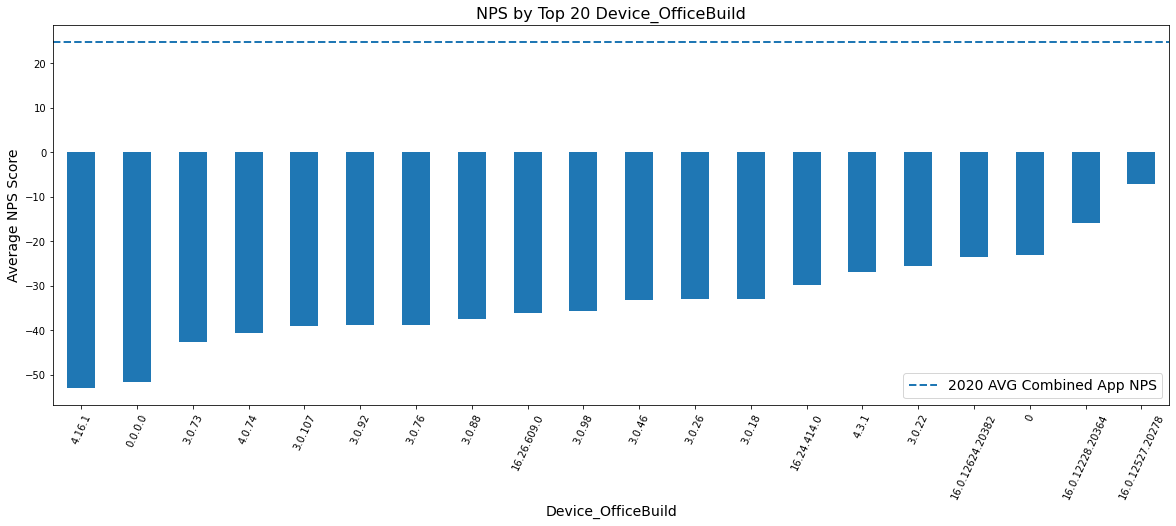

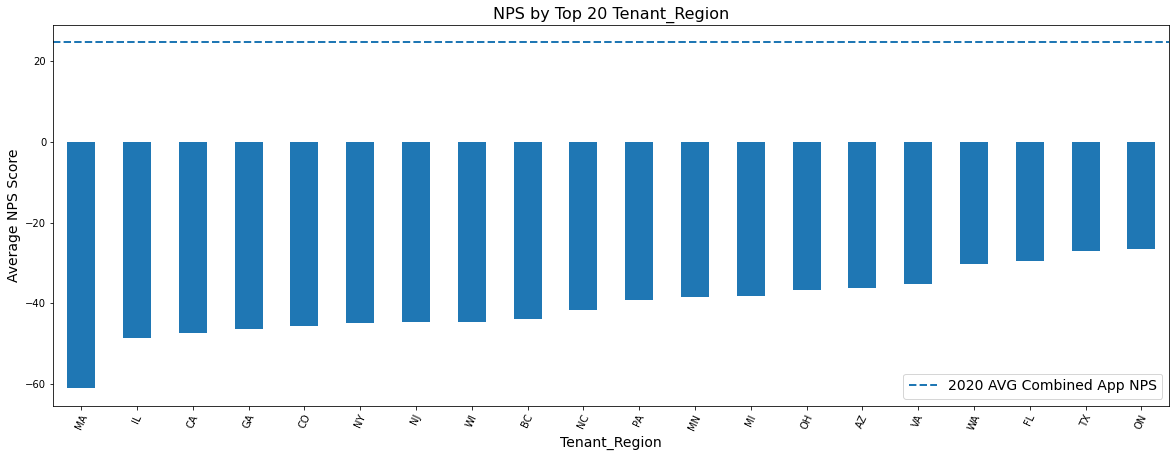

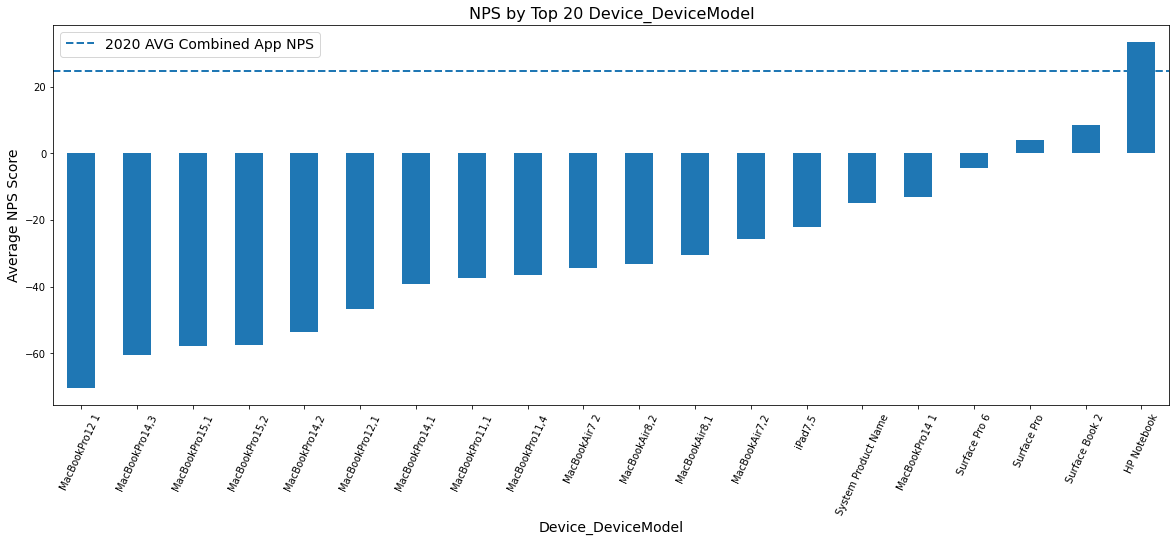

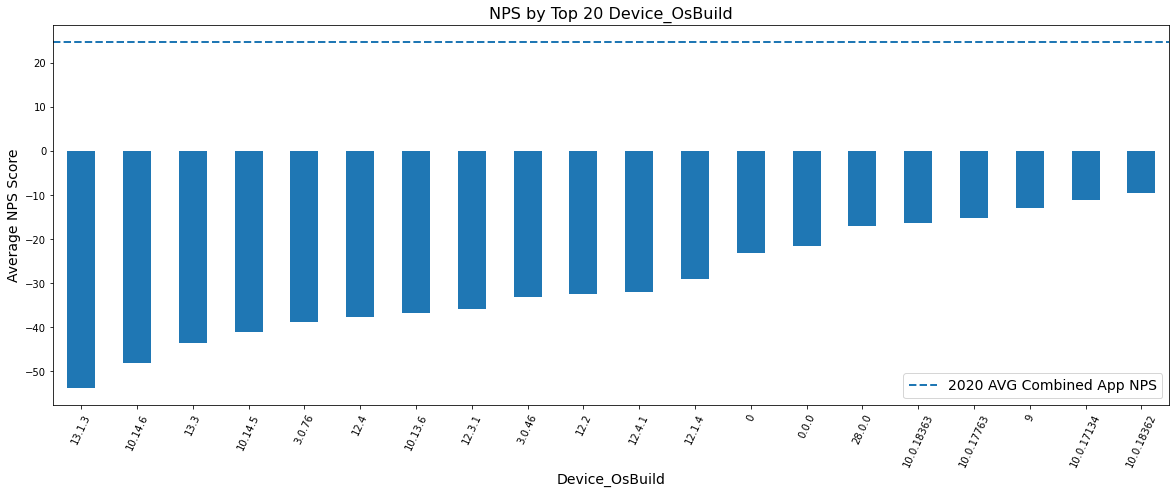

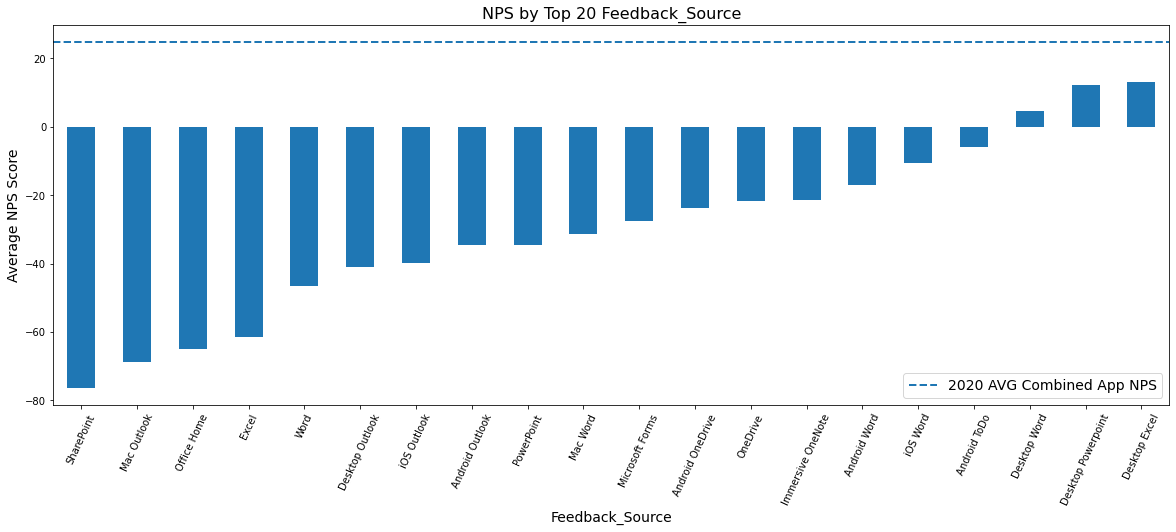

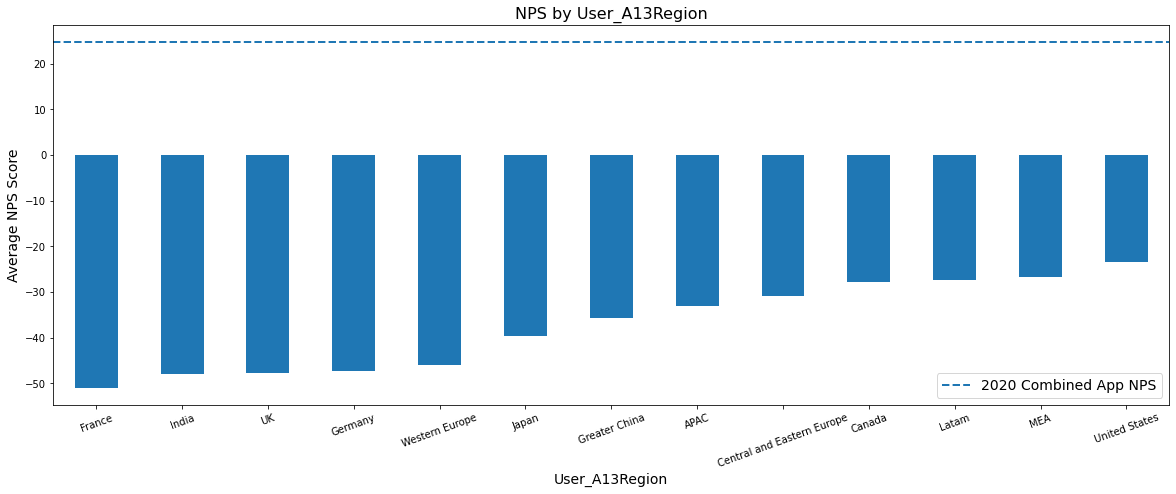

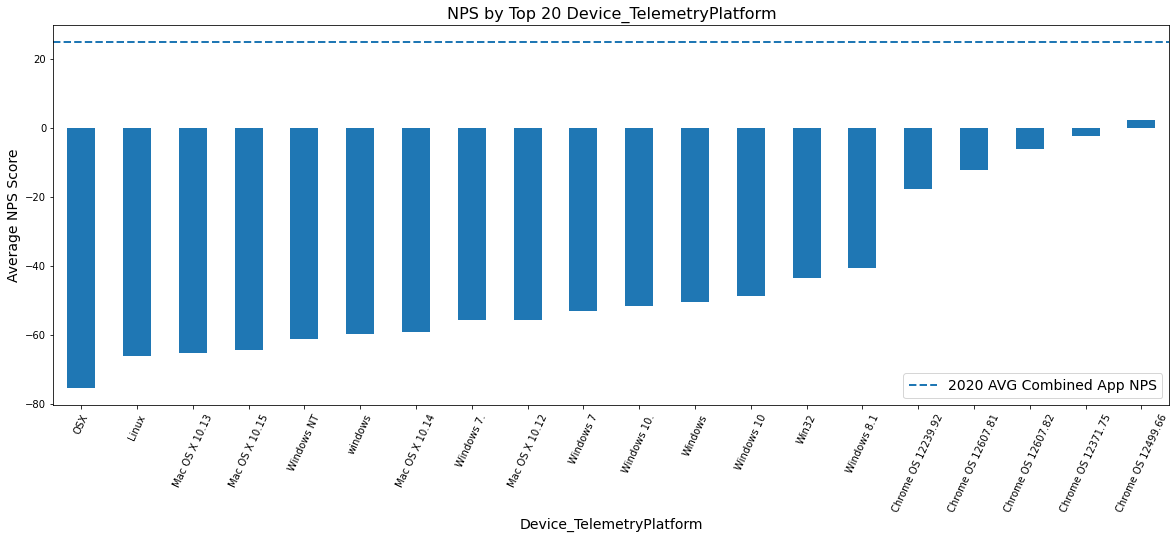

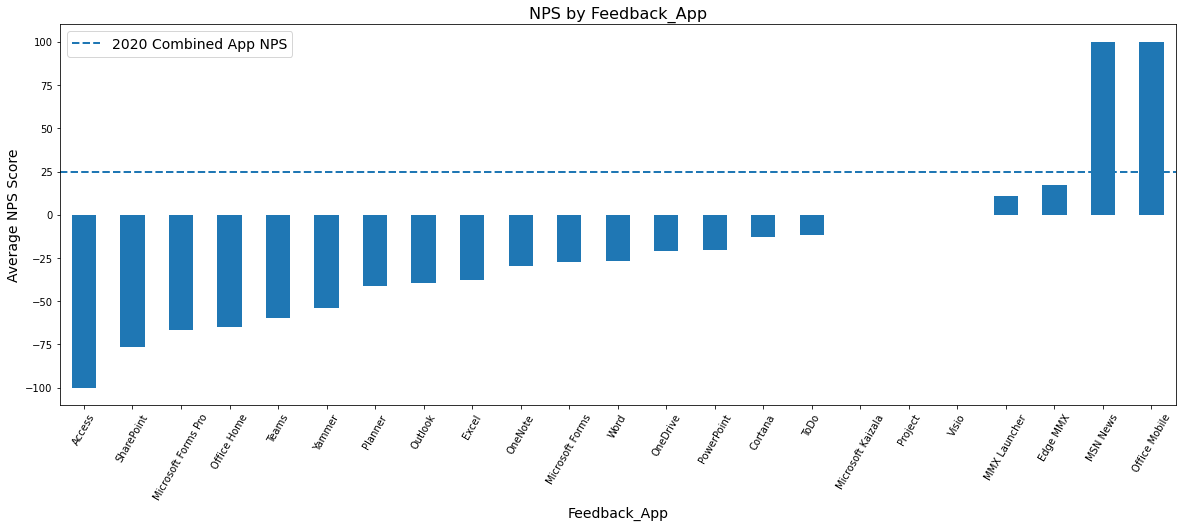

In [249]:
plot_cats(app_compete_top_10_features, 24.7200777301251, 'app')

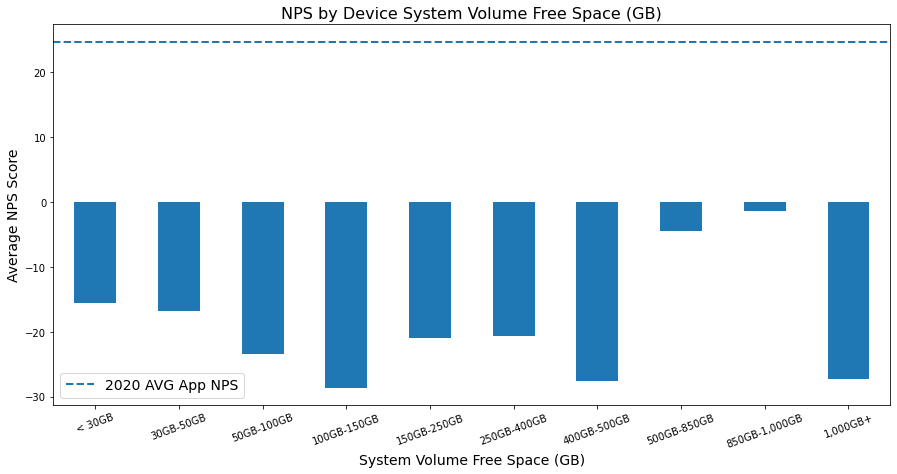

In [263]:
plot_nums(24.7200777301251, app_compete_top_10_features, 'Device_SysVolFreeSpaceMB', 'app', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

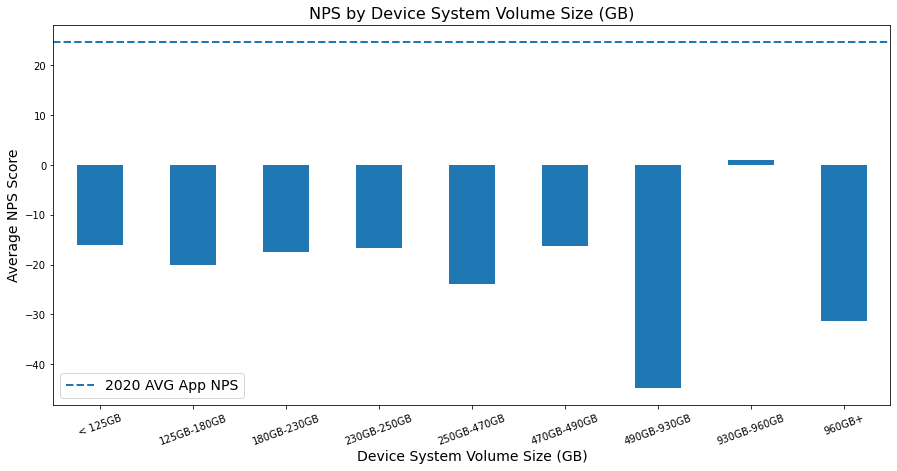

In [264]:
plot_nums(24.7200777301251, app_compete_top_10_features, 'Device_SysVolSizeMB', 'app', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

# App Cost/Compete Split by Consumer, Commercial Edu, and Commercial Non-Edu

In [360]:
#separate into cost and compete dfs
app_cost = app[app['NgramThemePredictions'] == 'cost']
app_compete = app[app['NgramThemePredictions'] == 'compete']

In [361]:
#get rid of _x that was introducted in the merge
app_cost.columns = [c.replace('_x', '') for c in app_cost.columns]
app_compete.columns = [c.replace('_x', '') for c in app_compete.columns]

#drop feedback_rating, not sure how its still there but hell - also, feedback_app and feedback_source are the same thing, so drop one of them
app_cost.drop(['Feedback_Rating', 'Feedback_Source'], axis = 1, inplace = True)
app_compete.drop(['Feedback_Rating', 'Feedback_Source'], axis = 1, inplace = True)

C:\Users\fulto\anaconda3\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [362]:
#create consumer df
app_cost_consumer = app_cost[app_cost['Feedback_UserType'] == 'Consumer']

#create commercial df and split it by edu
app_cost_commercial_e = app_cost[(app_cost['Feedback_UserType'] == 'Commercial') & (app_cost['User_Commercial_HasEducation'] == 1.0)]
app_cost_commercial_n = app_cost[(app_cost['User_Commercial_HasEducation'] == 0.0) & (app_cost['Feedback_UserType'] == 'Commercial')]

In [363]:
#remove columns with mostly missing data
app_cost_consumer = remove_completely_missing_columns(app_cost_consumer)
app_cost_commercial_e = remove_completely_missing_columns(app_cost_commercial_e)
app_cost_commercial_n = remove_completely_missing_columns(app_cost_commercial_n)

shape before deleting missing columns: (7299, 325)
shape after deleting missing columns: (7299, 60)
shape before deleting missing columns: (1754, 325)
shape after deleting missing columns: (1754, 262)
shape before deleting missing columns: (1566, 325)
shape after deleting missing columns: (1566, 259)


In [364]:
#create compete dfs as well
#create consumer df
app_compete_consumer = app_compete[app_compete['Feedback_UserType'] == 'Consumer']

#create commercial df and split it by edu
app_compete_commercial_e = app_compete[(app_compete['Feedback_UserType'] == 'Commercial') & (app_compete['User_Commercial_HasEducation'] == 1.0)]
app_compete_commercial_n = app_compete[(app_compete['User_Commercial_HasEducation'] == 0.0) & (app_compete['Feedback_UserType'] == 'Commercial')]

#remove columns with mostly missing data
app_compete_consumer = remove_completely_missing_columns(app_compete_consumer)
app_compete_commercial_e = remove_completely_missing_columns(app_compete_commercial_e)
app_compete_commercial_n = remove_completely_missing_columns(app_compete_commercial_n)

shape before deleting missing columns: (2351, 325)
shape after deleting missing columns: (2351, 80)
shape before deleting missing columns: (2968, 325)
shape after deleting missing columns: (2968, 258)
shape before deleting missing columns: (2836, 325)
shape after deleting missing columns: (2836, 258)


In [1572]:
#get consumer missing columns 
cost_consumer_missing_cols = []

for idx, row in pd.DataFrame(app_cost_consumer.isna().sum()).iterrows():
    if row[0] > 0:
        cost_consumer_missing_cols.append(idx)
        
#get commercial edu columns
cost_commedu_missing_cols = []

for idx, row in pd.DataFrame(app_cost_commercial_e.isna().sum()).iterrows():
    if row[0] > 0:
        cost_commedu_missing_cols.append(idx)
        
#get nonedu missings
cost_nonedu_missing_cols = []

for idx, row in pd.DataFrame(app_cost_commercial_n.isna().sum()).iterrows():
    if row[0] > 0:
        cost_nonedu_missing_cols.append(idx)
        
#get compete missing columns 
compete_consumer_missing_cols = []

for idx, row in pd.DataFrame(app_compete_consumer.isna().sum()).iterrows():
    if row[0] > 0:
        compete_consumer_missing_cols.append(idx)
        
#get commercial edu columns
compete_commedu_missing_cols = []

for idx, row in pd.DataFrame(app_compete_commercial_e.isna().sum()).iterrows():
    if row[0] > 0:
        compete_commedu_missing_cols.append(idx)
        
#get nonedu missings
compete_nonedu_missing_cols = []

for idx, row in pd.DataFrame(app_compete_commercial_n.isna().sum()).iterrows():
    if row[0] > 0:
        compete_nonedu_missing_cols.append(idx)     

        
#fill nas with mode of grouped region and feedback source
for col in compete_consumer_missing_cols:
    if app_compete_consumer[col].dtype != 'O':
        try:
            app_compete_consumer = fill_na(app_compete_consumer, col, 'Feedback_App_x', method = 'mean')
        except:
            pass
#needed to pass errors since some of the groupbys were creating nas
for col in compete_commedu_missing_cols:
    if app_compete_commercial_e[col].dtype != 'O':
        try:
            app_compete_commercial_e = fill_na(app_compete_commercial_e, col, 'Feedback_Source', method = 'mean')
        except:
            pass
        
for col in compete_nonedu_missing_cols:
    if app_compete_commercial_n[col].dtype != 'O':
        try:
            app_compete_commercial_n = fill_na(app_compete_commercial_n, col, 'Feedback_Source', method = 'mean')
        except:
            pass
        
#fill remaining nas with mode of columns 
app_cost_consumer[cost_consumer_missing_cols] = app_cost_consumer[cost_consumer_missing_cols].fillna(app_cost_consumer.mode().iloc[0])
#fill remaining nas 
app_cost_commercial_e[cost_commedu_missing_cols] = app_cost_commercial_e[cost_commedu_missing_cols].fillna(app_cost_commercial_e.mode().iloc[0])
#fill in for nonedu
app_cost_commercial_n[cost_nonedu_missing_cols] = app_cost_commercial_n[cost_nonedu_missing_cols].fillna(app_cost_commercial_n.mode().iloc[0])

#do the same for compete
#fill remaining nas with mode of columns 
app_compete_consumer[compete_consumer_missing_cols] = app_compete_consumer[compete_consumer_missing_cols].fillna(app_compete_consumer.mode().iloc[0])
#fill remaining nas 
app_compete_commercial_e[compete_commedu_missing_cols] = app_compete_commercial_e[compete_commedu_missing_cols].fillna(app_compete_commercial_e.mode().iloc[0])
#fill in for nonedu
app_compete_commercial_n[compete_nonedu_missing_cols] = app_compete_commercial_n[compete_nonedu_missing_cols].fillna(app_compete_commercial_n.mode().iloc[0])

In [339]:
#get rid of useless features
app_cost_consumer = throw_out_useless_features(app_cost_consumer)
app_cost_commercial_e = throw_out_useless_features(app_cost_commercial_e)
app_cost_commercial_n = throw_out_useless_features(app_cost_commercial_n)

Shape before: (7299, 60)
Shape after throwing them out: (7299, 30)
Shape before: (1754, 262)
Shape after throwing them out: (1754, 168)
Shape before: (1566, 259)
Shape after throwing them out: (1566, 165)


In [340]:
#do the same for compete
app_compete_consumer = throw_out_useless_features(app_compete_consumer)
app_compete_commercial_e = throw_out_useless_features(app_compete_commercial_e)
app_compete_commercial_n = throw_out_useless_features(app_compete_commercial_n)

Shape before: (2351, 80)
Shape after throwing them out: (2351, 44)
Shape before: (2968, 258)
Shape after throwing them out: (2968, 165)
Shape before: (2836, 258)
Shape after throwing them out: (2836, 165)


In [1575]:
#split data into feature and label sets for consumer, commercial edu, and commercian nonedu
app_cost_consumer_features = app_cost_consumer.drop(['Feedback_RatingValue'], axis = 1)
app_cost_consumer_labels = app_cost_consumer['Feedback_RatingValue']


app_cost_commercial_edu_features = app_cost_commercial_e.drop(['Feedback_RatingValue'], axis = 1)
app_cost_commercial_edu_labels = app_cost_commercial_e['Feedback_RatingValue']


app_cost_commercial_nonedu_features = app_cost_commercial_n.drop(['Feedback_RatingValue'], axis = 1)
app_cost_commercial_nonedu_labels = app_cost_commercial_n['Feedback_RatingValue']


app_compete_consumer_features = app_compete_consumer.drop(['Feedback_RatingValue'], axis = 1)
app_compete_consumer_labels = app_compete_consumer['Feedback_RatingValue']


app_compete_commercial_edu_features = app_compete_commercial_e.drop(['Feedback_RatingValue'], axis = 1)
app_compete_commercial_edu_labels = app_compete_commercial_e['Feedback_RatingValue']


app_compete_commercial_nonedu_features = app_compete_commercial_n.drop(['Feedback_RatingValue'], axis = 1)
app_compete_commercial_nonedu_labels = app_compete_commercial_n['Feedback_RatingValue']

In [1576]:
#running same analysis for consumer, comercial edu, and commercial nonedu separated out
app_cost_consumer_important_features = find_important_features(suite_cost_consumer_features, suite_cost_consumer_labels, model = 'random forest', encode = True)
app_cost_commercial_edu_important_features = find_important_features(suite_cost_commercial_edu_features, suite_cost_commercial_edu_labels, model = 'random forest', encode = True)
app_cost_commercial_nonedu_important_features = find_important_features(suite_cost_commercial_nonedu_features, suite_cost_commercial_nonedu_labels, model = 'random forest', encode = True)
app_compete_consumer_important_features = find_important_features(suite_compete_consumer_features, suite_compete_consumer_labels, model = 'random forest', encode = True)
app_compete_commercial_edu_important_features = find_important_features(suite_compete_commercial_edu_features, suite_compete_commercial_edu_labels, model = 'random forest', encode = True)
app_compete_commercial_nonedu_important_features = find_important_features(suite_compete_commercial_nonedu_features, suite_compete_commercial_nonedu_labels, model = 'random forest', encode = True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    8.8s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   15.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   20.9s remaining:    4.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   24.0s remaining:    1.4s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.6s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    3.4s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   10.5s remaining:    2.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   14.6s remaining:    0.8s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   14.9s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:   10.0s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   14.9s remaining:    3.2s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   18.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   19.1s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.5s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    3.6s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    5.0s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:    9.7s remaining:    2.0s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   10.2s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   11.3s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.9s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   11.3s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.1s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   16.2s remaining:    3.5s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   16.6s remaining:    1.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   17.0s finished


Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:    7.1s
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:   13.4s remaining:    2.9s
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:   15.6s remaining:    0.9s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   16.0s finished


In [1577]:
#using function to pull top 10 features with respect to splits
app_cost_consumer_top_10_features = get_top_10_feats(app_cost_consumer_important_features, app_or_suite = app, subset = 'cost')
app_cost_commercial_edu_top_10_features = get_top_10_feats(app_cost_commercial_edu_important_features, app_or_suite = app, subset = 'cost')
app_cost_commercial_nonedu_top_10_features = get_top_10_feats(app_cost_commercial_nonedu_important_features, app_or_suite = app, subset = 'cost')
app_compete_consumer_top_10_features = get_top_10_feats(app_compete_consumer_important_features, app_or_suite = app, subset = 'compete')
app_compete_commercial_edu_top_10_features = get_top_10_feats(app_compete_commercial_edu_important_features, app_or_suite = app, subset = 'compete')
app_compete_commercial_nonedu_top_10_features = get_top_10_feats(app_compete_commercial_nonedu_important_features, app_or_suite = app, subset = 'compete')

### Top 10 App Cost Consumer Features

Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

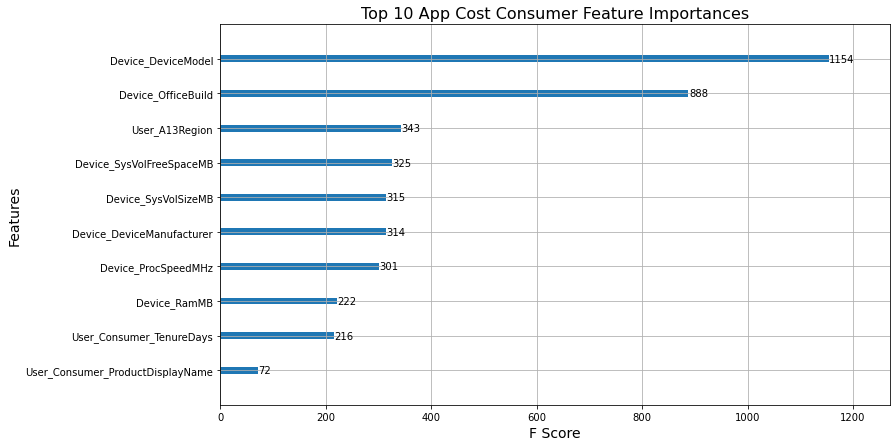

In [1580]:
app_cost_consumer_feats, app_cost_consumer_important_features_model = find_important_features(app_cost_consumer_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                                app_cost_consumer_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)


#plot the features
plt.figure(figsize = (12, 10))
ax = plot_importance(app_cost_consumer_important_features_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 App Cost Consumer Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

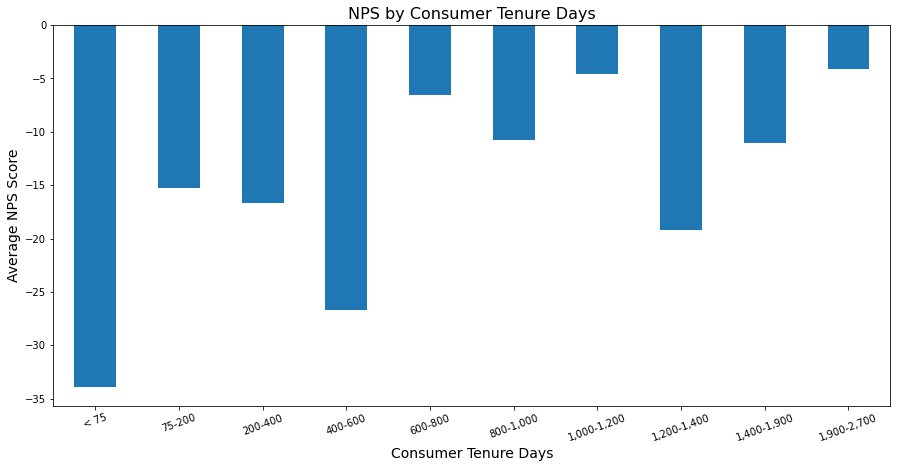

In [1596]:
plot_nums(app_cost_consumer_top_10_features, 'User_Consumer_TenureDays', 'NPS by Consumer Tenure Days', 'Consumer Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

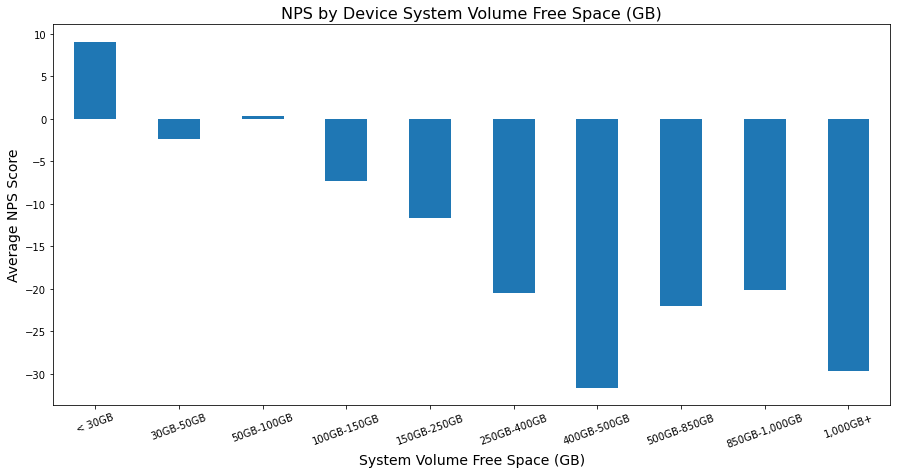

In [1597]:
plot_nums(app_cost_consumer_top_10_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

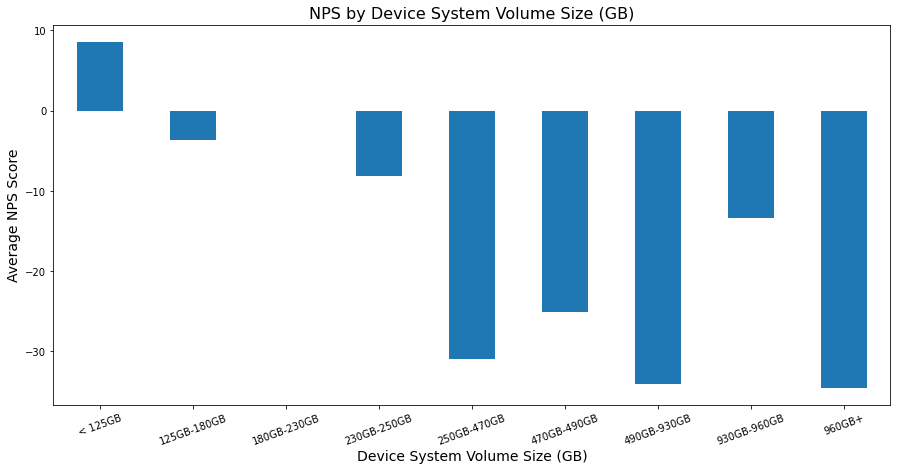

In [1598]:
plot_nums(app_cost_consumer_top_10_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

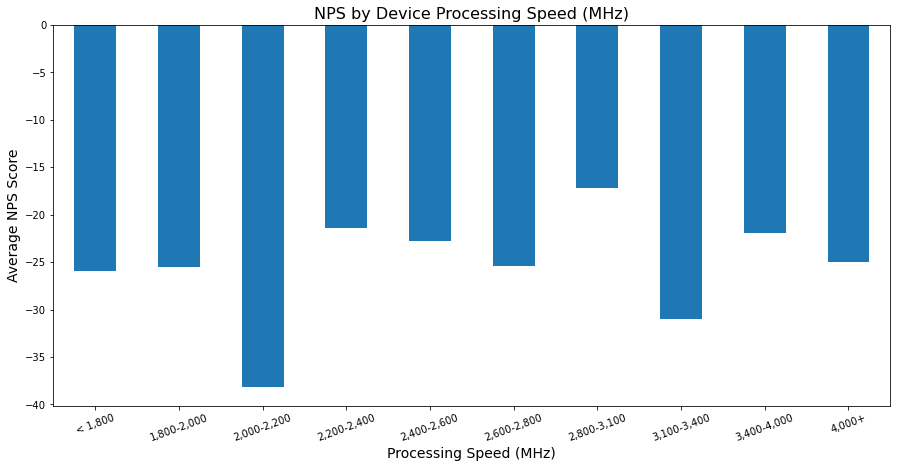

In [1599]:
plot_nums(app_cost_consumer_top_10_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

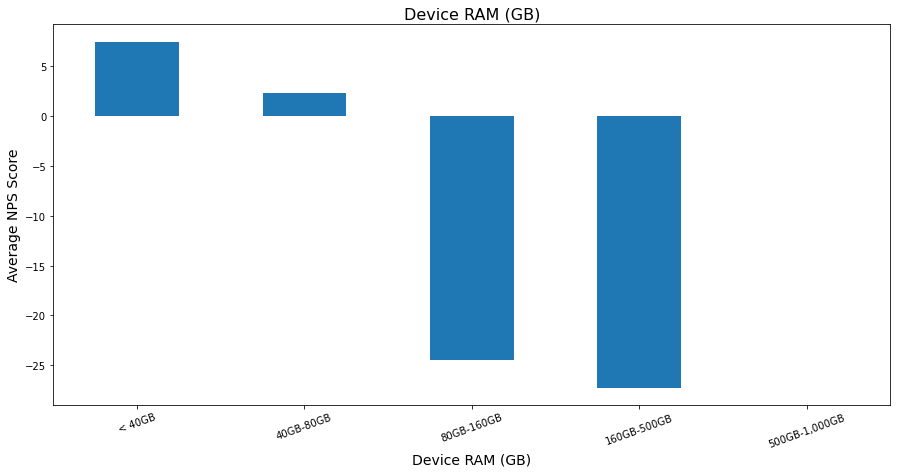

In [1600]:
plot_nums(app_cost_consumer_top_10_features, 'Device_RamMB', 'Device RAM (GB)', 'Device RAM (GB)', bins = [0, 4000, 8000, 16000, 50000, 100000],
          labels = ['< 40GB', '40GB-80GB', '80GB-160GB', '160GB-500GB', '500GB-1,000GB'], method = 'cut')

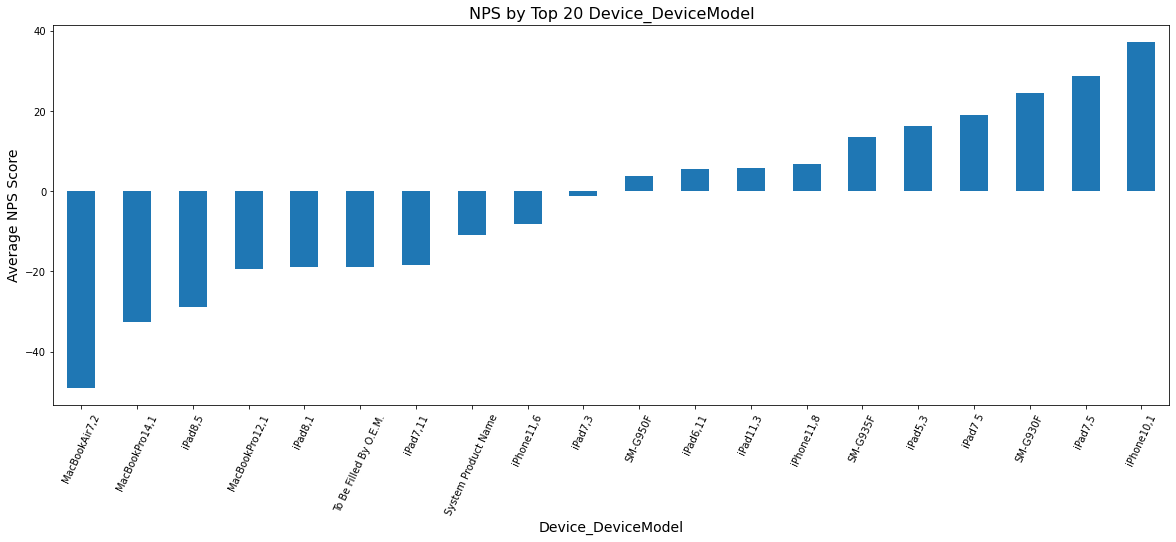

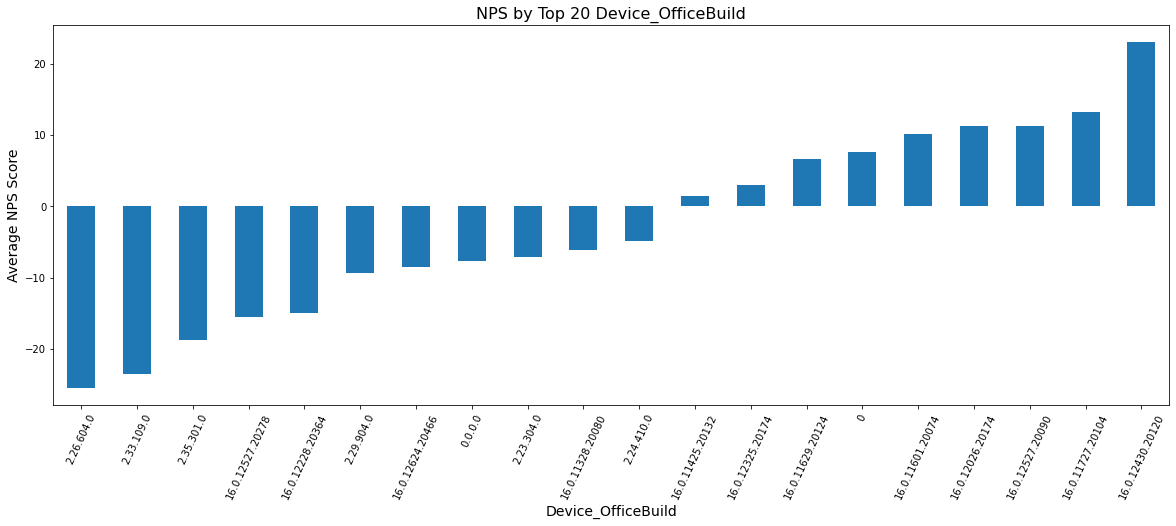

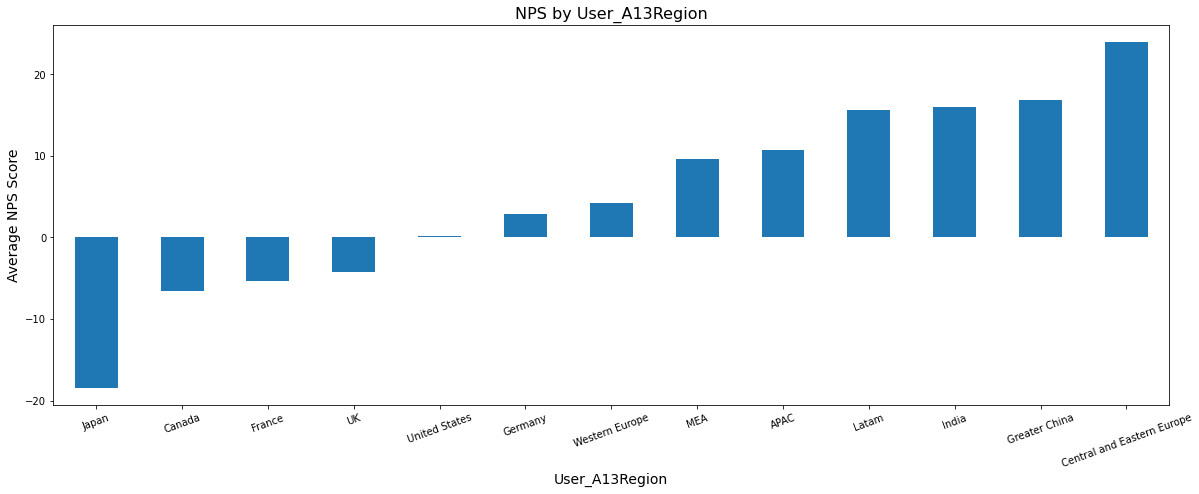

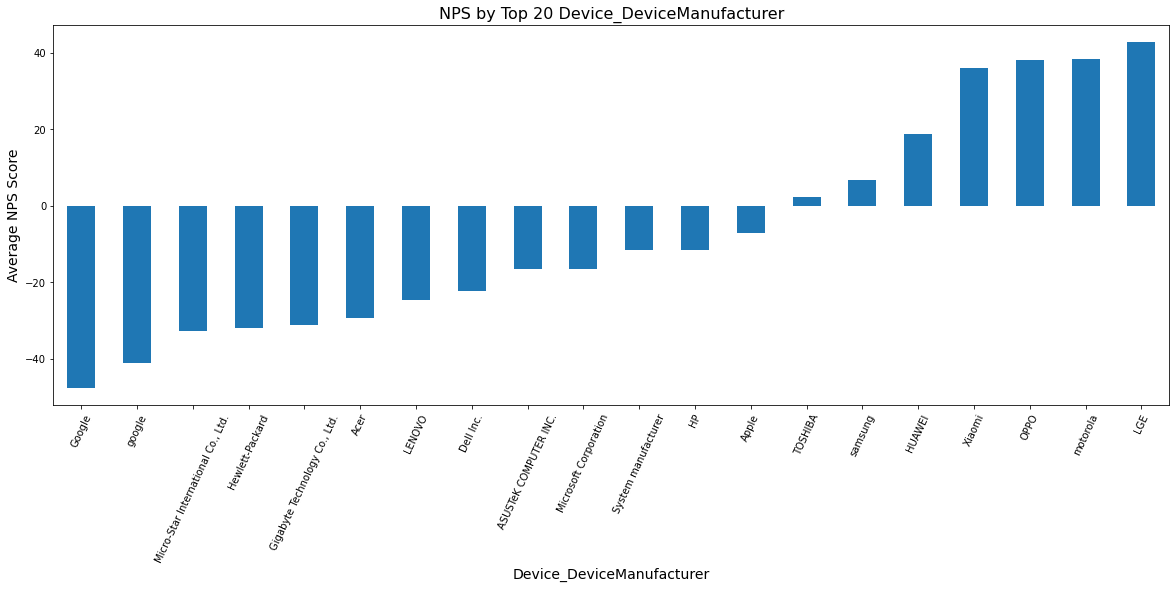

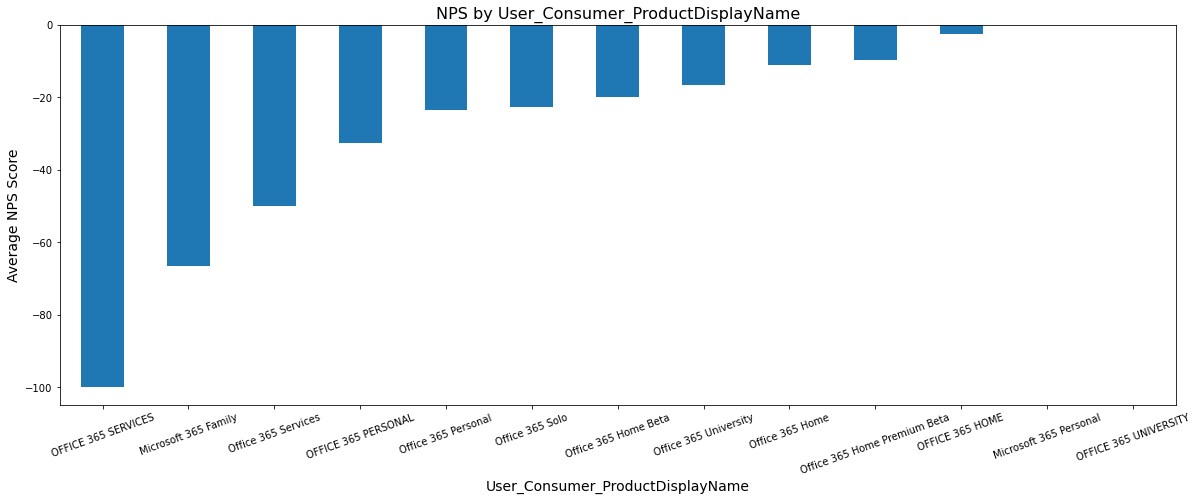

In [1588]:
plot_cats(app_cost_consumer_top_10_features)

### Top 10 App Cost Commercial Edu Features

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 10.3min remaining:  2.3min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 10.6min remaining:   40.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 10.8min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

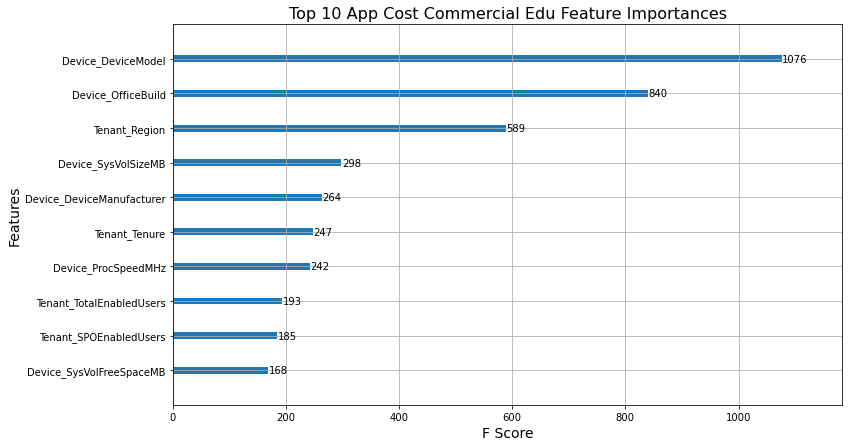

In [1581]:
app_cost_commercial_edu_feats, app_cost_commercial_edu_important_features_model = find_important_features(app_cost_commercial_edu_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                                app_cost_commercial_edu_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)


#plot the features
plt.figure(figsize = (12, 10))
ax = plot_importance(app_cost_commercial_edu_important_features_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 App Cost Commercial Edu Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

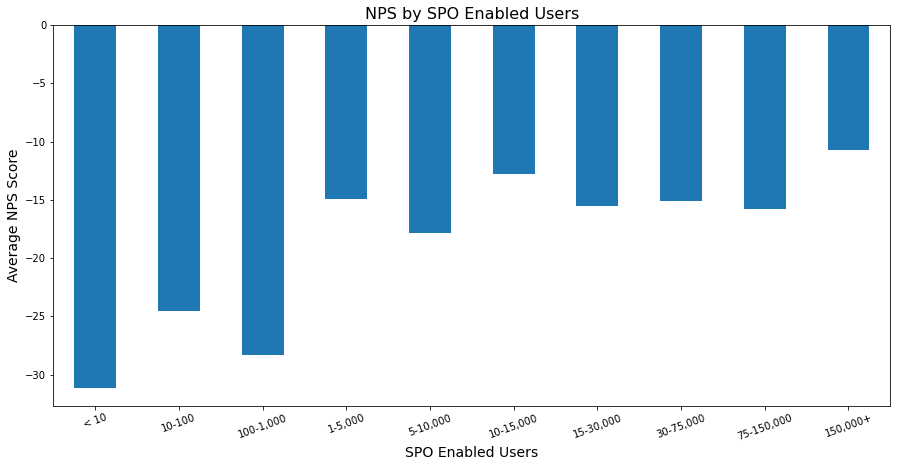

In [1610]:
plot_nums(app_cost_commercial_edu_top_10_features, 'Tenant_SPOEnabledUsers', 'NPS by SPO Enabled Users', 'SPO Enabled Users', 
         bins = [0, 10, 100, 1000, 5000, 10000, 15000, 30000, 75000, 150000, 1000000000],
          labels = ['< 10', '10-100', '100-1,000', '1-5,000', '5-10,000', '10-15,000', '15-30,000', '30-75,000', '75-150,000', '150,000+'], method = 'cut')

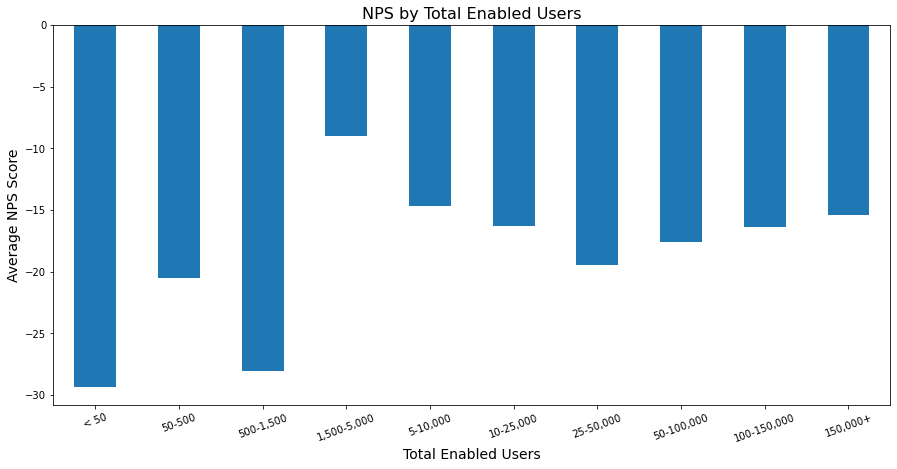

In [1608]:
plot_nums(app_cost_commercial_edu_top_10_features, 'Tenant_TotalEnabledUsers', 'NPS by Total Enabled Users', 'Total Enabled Users', 
          bins = [0, 50, 500, 1500, 5000, 10000, 25000, 50000, 100000, 150000, 1000000000000],
          labels = ['< 50', '50-500', '500-1,500', '1,500-5,000', '5-10,000', '10-25,000', '25-50,000', '50-100,000', '100-150,000', '150,000+'], method = 'cut')

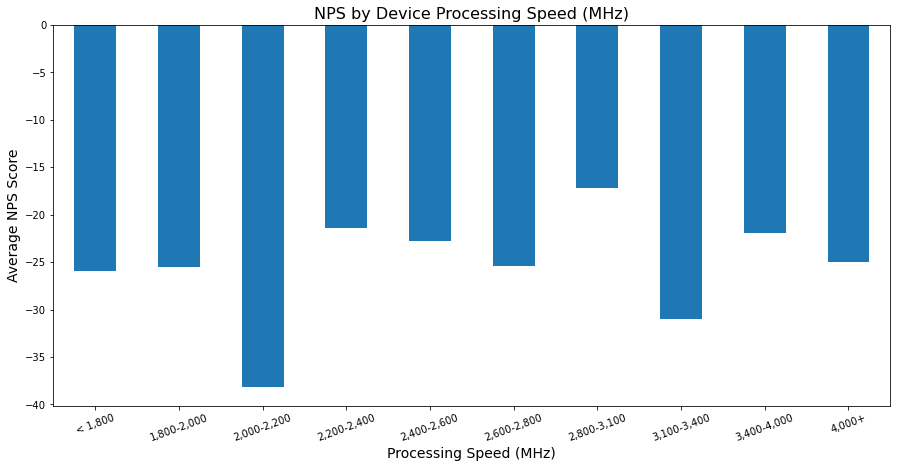

In [1605]:
plot_nums(app_cost_commercial_edu_top_10_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

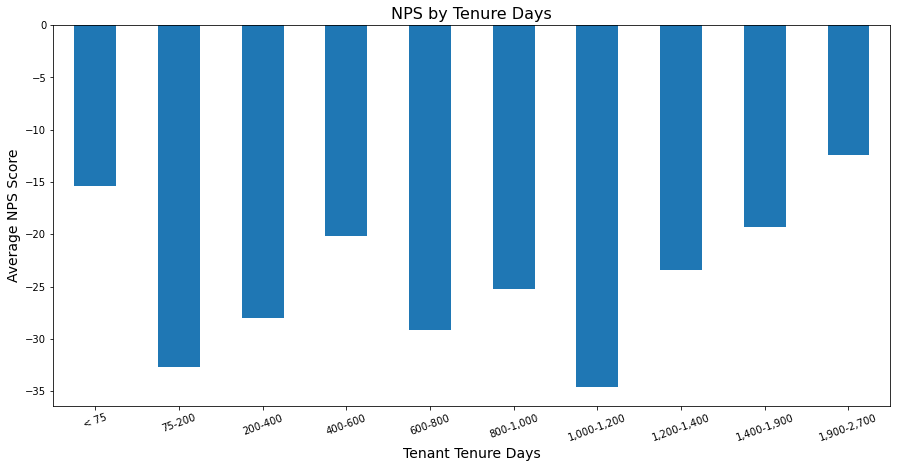

In [1615]:
plot_nums(app_cost_commercial_edu_top_10_features, 'Tenant_Tenure', 'NPS by Tenure Days', 'Tenant Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

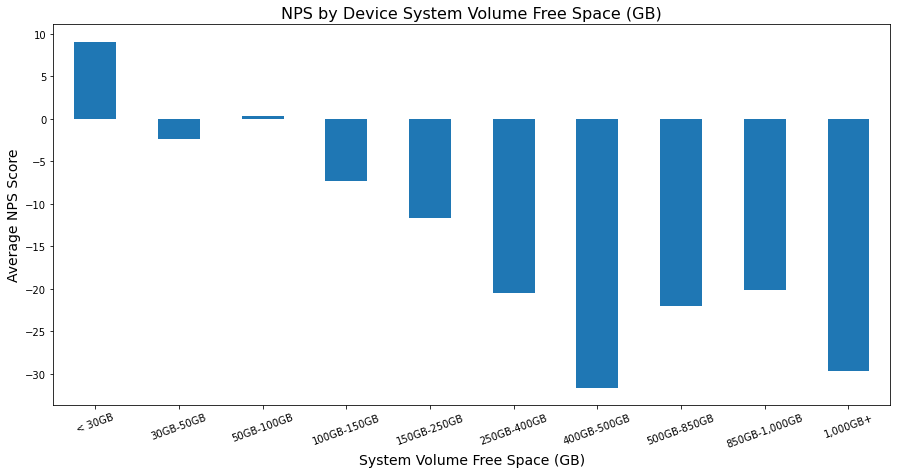

In [1603]:
plot_nums(app_cost_commercial_edu_top_10_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

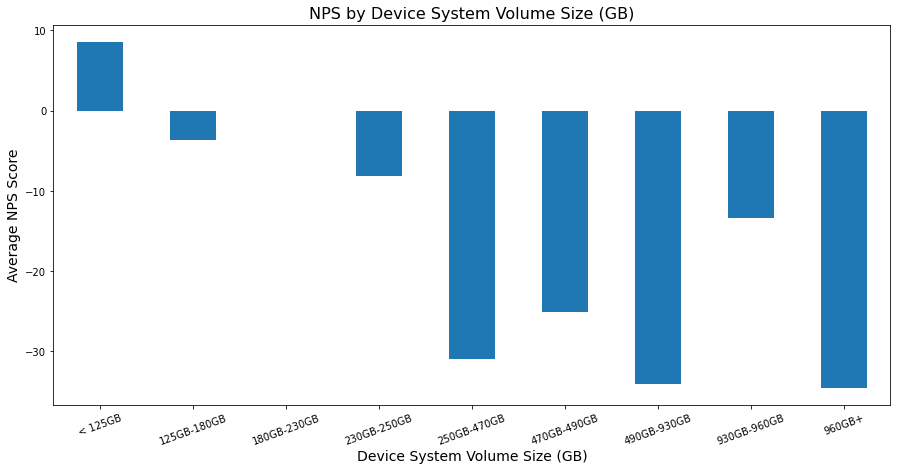

In [1602]:
plot_nums(app_cost_commercial_edu_top_10_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

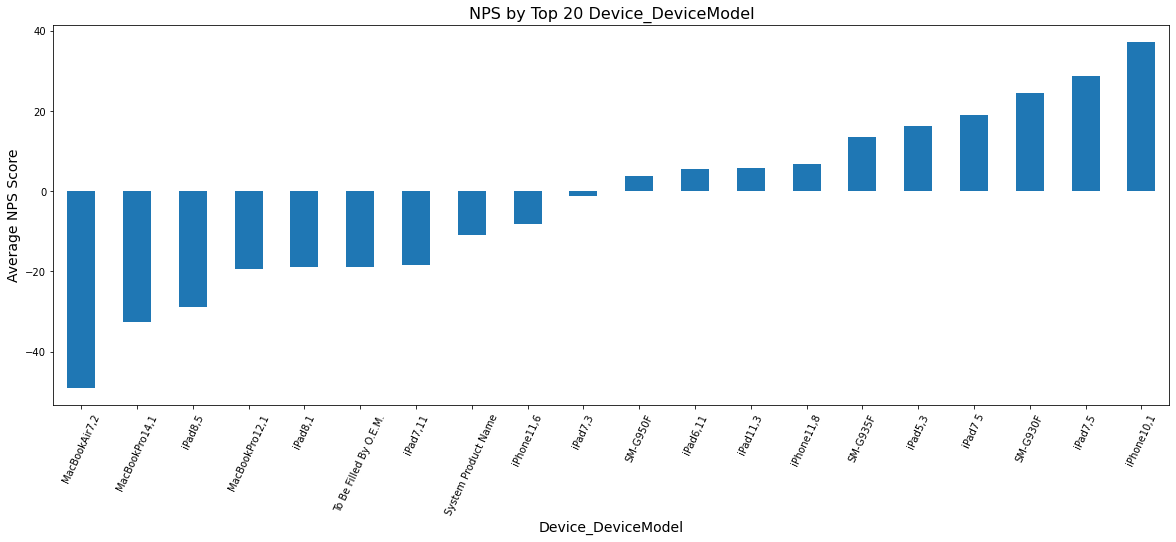

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37117 missing from curre

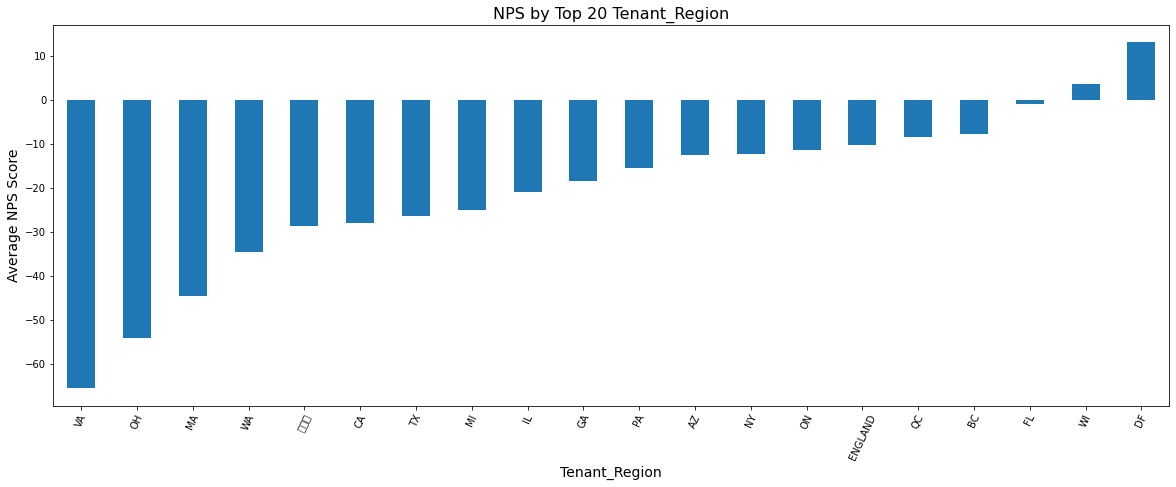

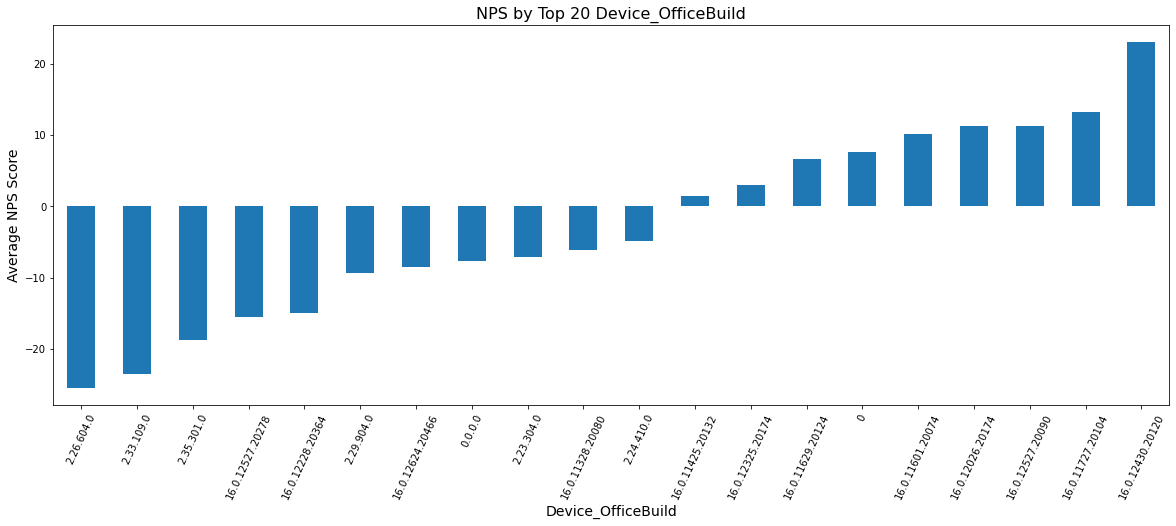

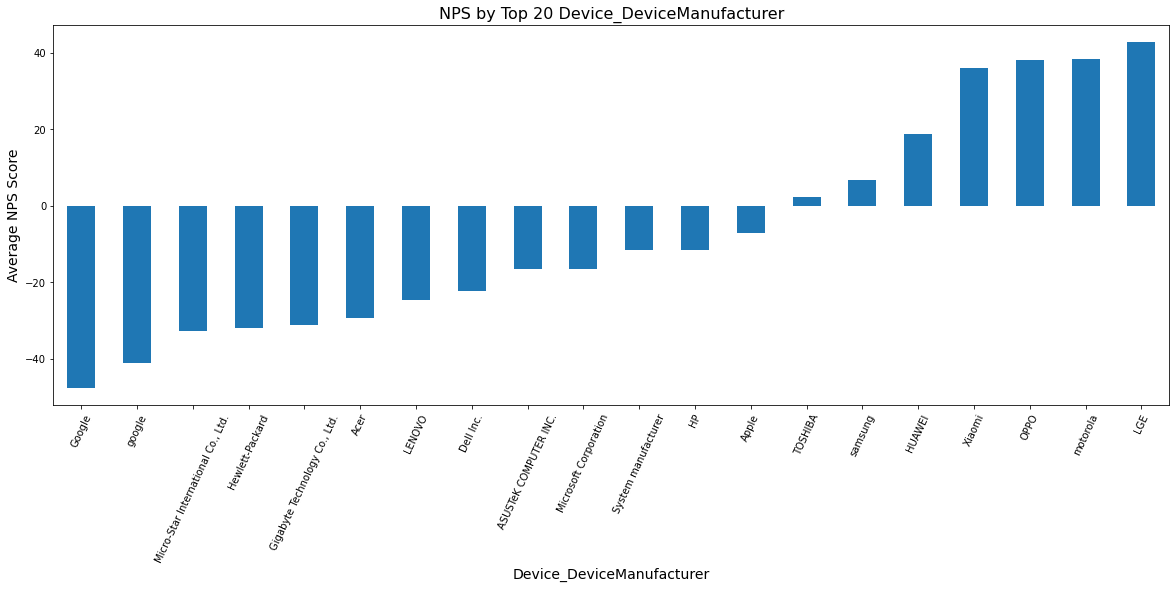

In [1589]:
plot_cats(app_cost_commercial_edu_top_10_features)

### Top 10 App Cost Commercial Non-Edu Features

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  7.0min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed: 11.2min remaining:  2.5min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed: 12.0min remaining:   46.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed: 13.3min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

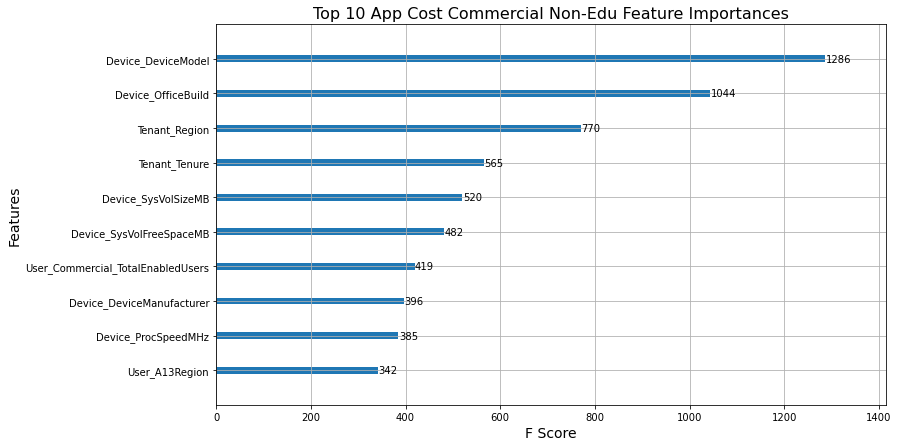

In [1582]:
app_cost_commercial_nonedu_feats, app_cost_commercial_nonedu_important_features_model = find_important_features(app_cost_commercial_nonedu_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                                app_cost_commercial_nonedu_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)


#plot the features
plt.figure(figsize = (12, 10))
ax = plot_importance(app_cost_commercial_nonedu_important_features_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 App Cost Commercial Non-Edu Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

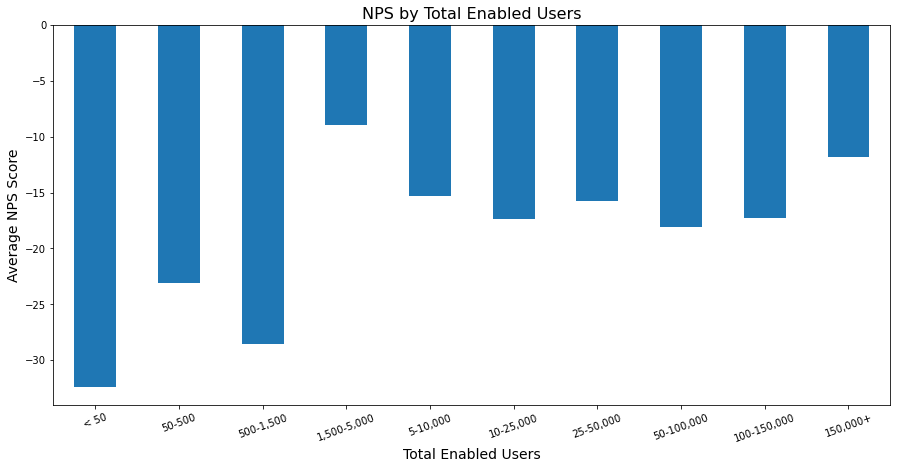

In [1619]:
plot_nums(app_cost_commercial_nonedu_top_10_features, 'User_Commercial_TotalEnabledUsers', 'NPS by Total Enabled Users', 'Total Enabled Users', 
          bins = [0, 50, 500, 1500, 5000, 10000, 25000, 50000, 100000, 150000, 1000000000000],
          labels = ['< 50', '50-500', '500-1,500', '1,500-5,000', '5-10,000', '10-25,000', '25-50,000', '50-100,000', '100-150,000', '150,000+'], method = 'cut')

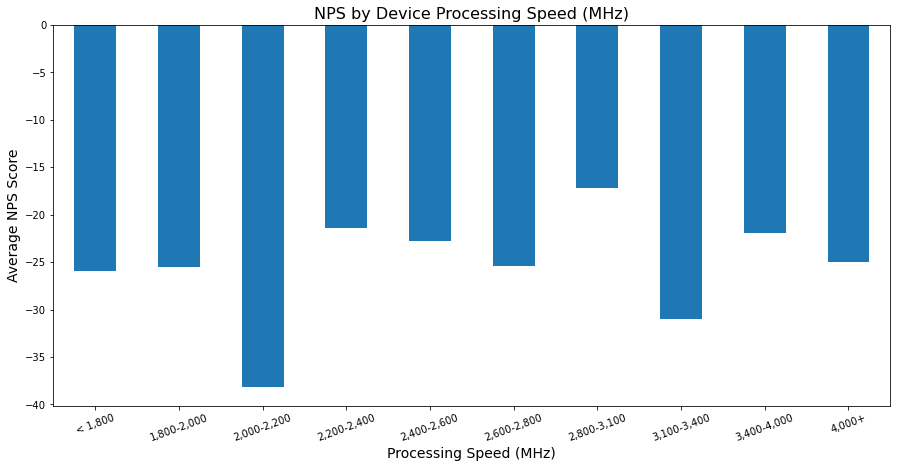

In [1618]:
plot_nums(app_cost_commercial_nonedu_top_10_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

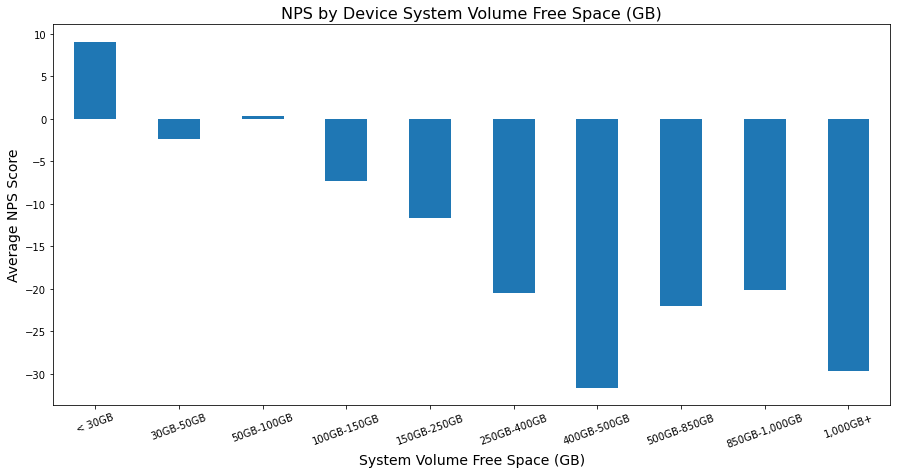

In [1617]:
plot_nums(app_cost_commercial_nonedu_top_10_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

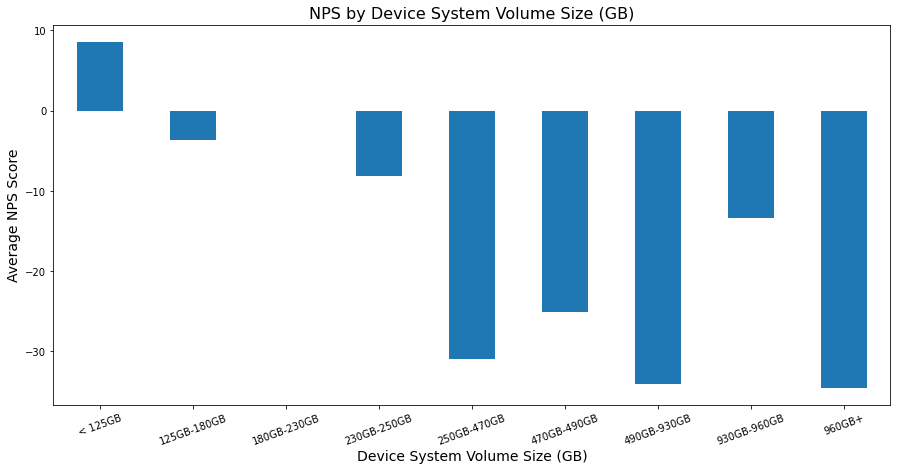

In [1616]:
plot_nums(app_cost_commercial_nonedu_top_10_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

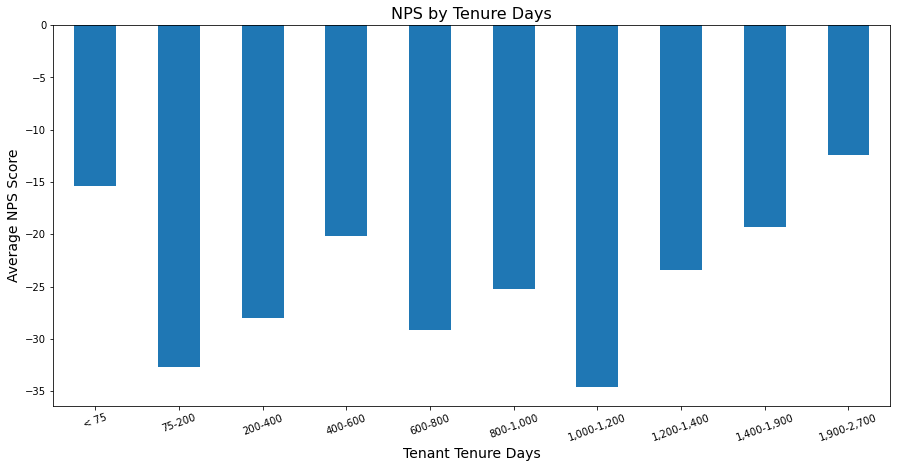

In [1614]:
plot_nums(app_cost_commercial_nonedu_top_10_features, 'Tenant_Tenure', 'NPS by Tenure Days', 'Tenant Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

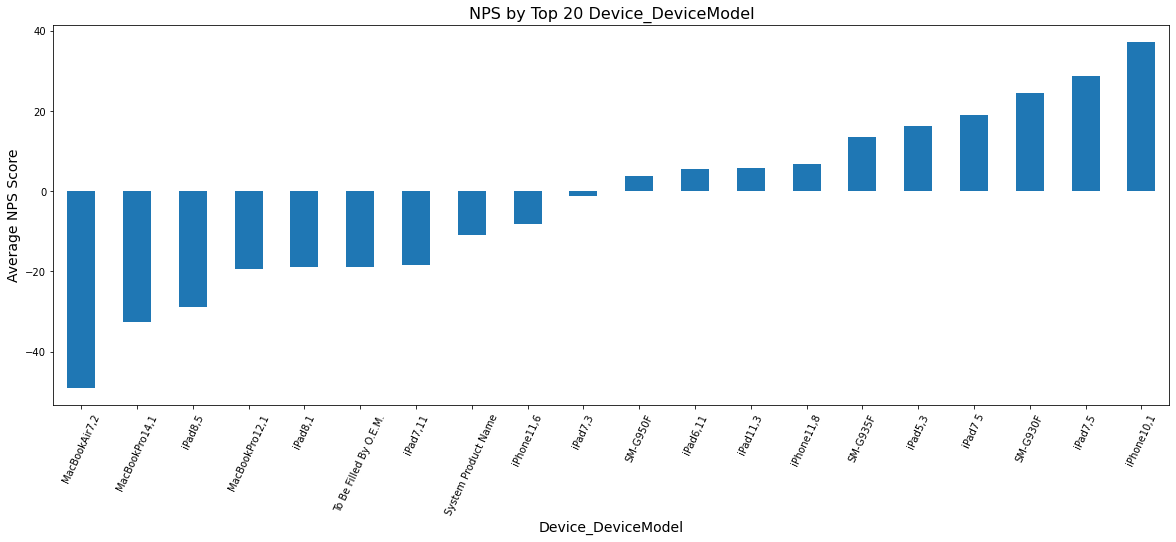

C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 37117 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 26481 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 20140 missing from current font.
  font.set_text(s, 0, flags=flags)
C:\Users\fulto\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:183: RuntimeWarning: Glyph 37117 missing from curre

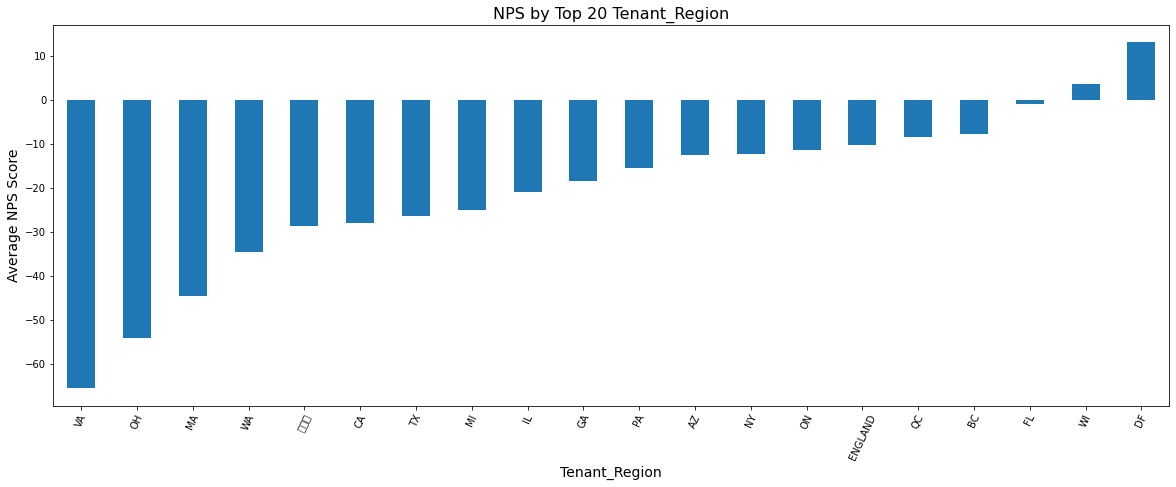

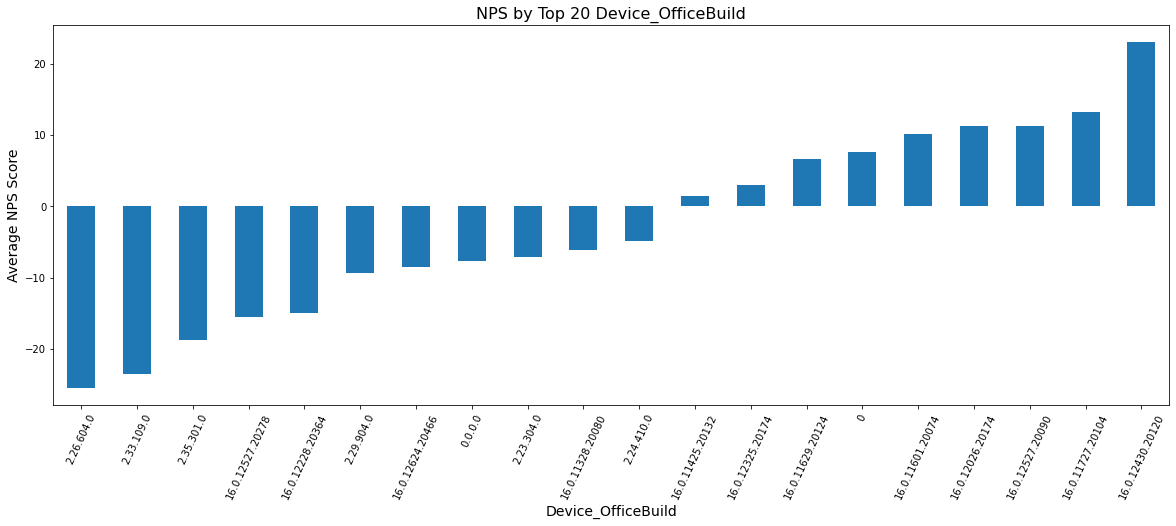

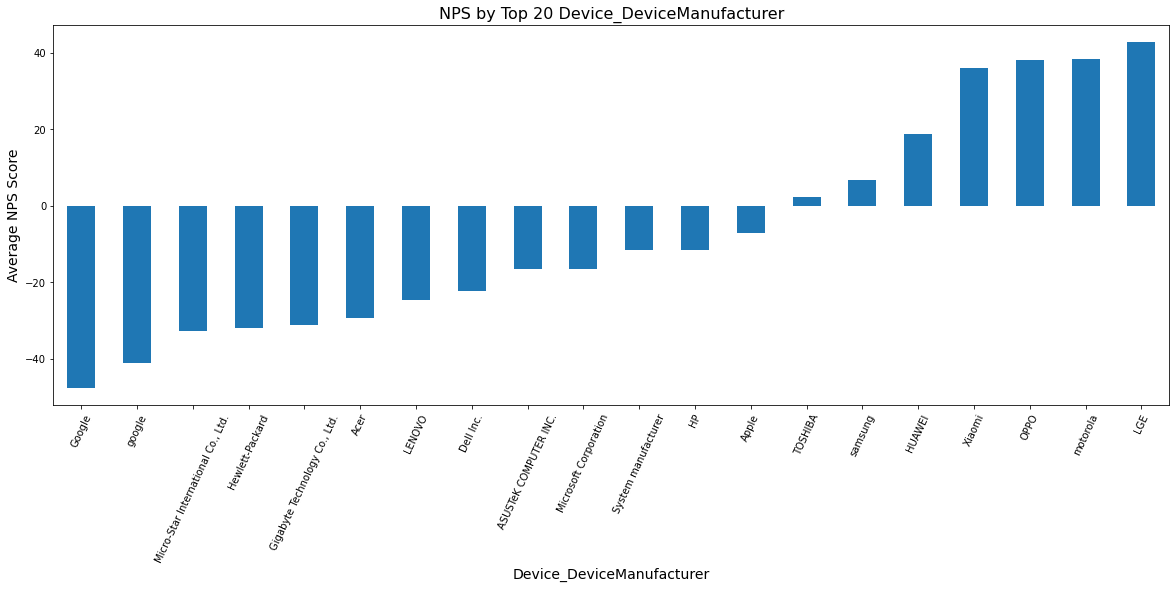

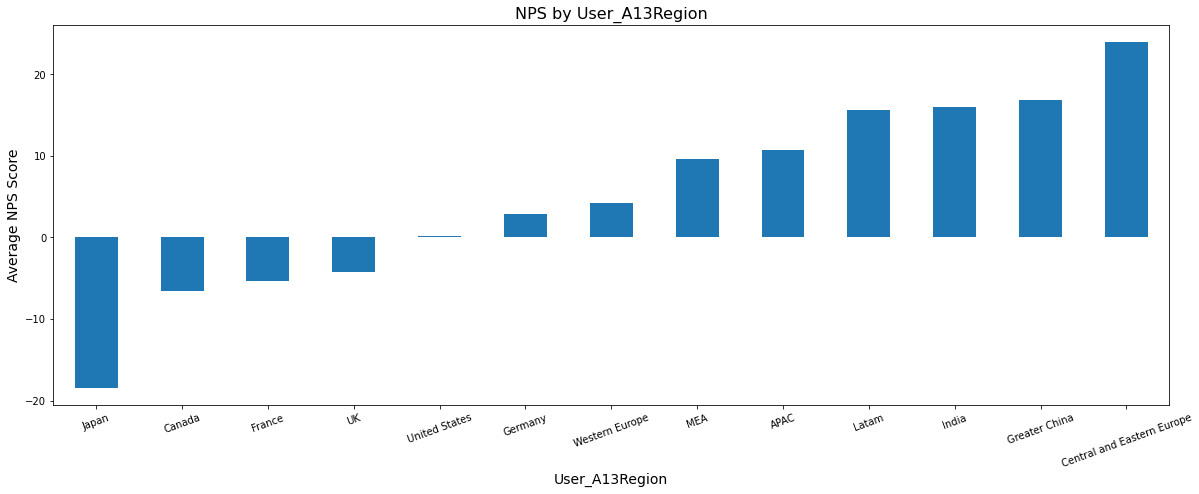

In [1590]:
plot_cats(app_cost_commercial_nonedu_top_10_features)

### Top 10 App Compete Consumer Features

Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

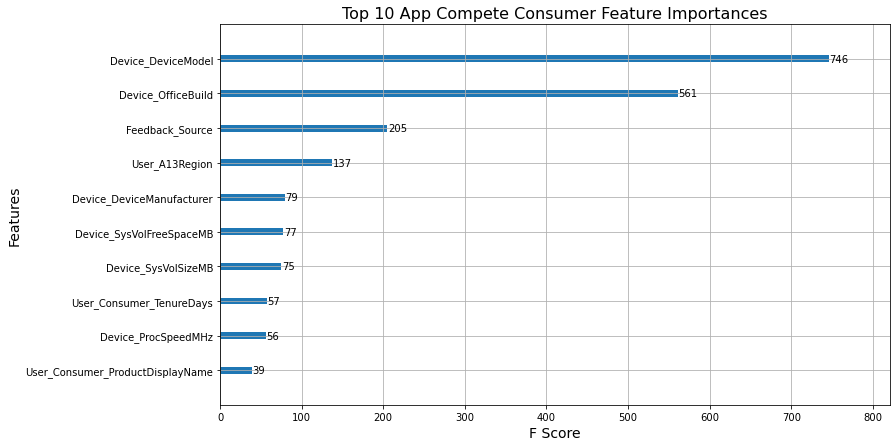

In [1585]:
app_compete_consumer_feats, app_compete_consumer_important_features_model = find_important_features(app_compete_consumer_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                                app_compete_consumer_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)


#plot the features
plt.figure(figsize = (12, 10))
ax = plot_importance(app_compete_consumer_important_features_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 App Compete Consumer Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

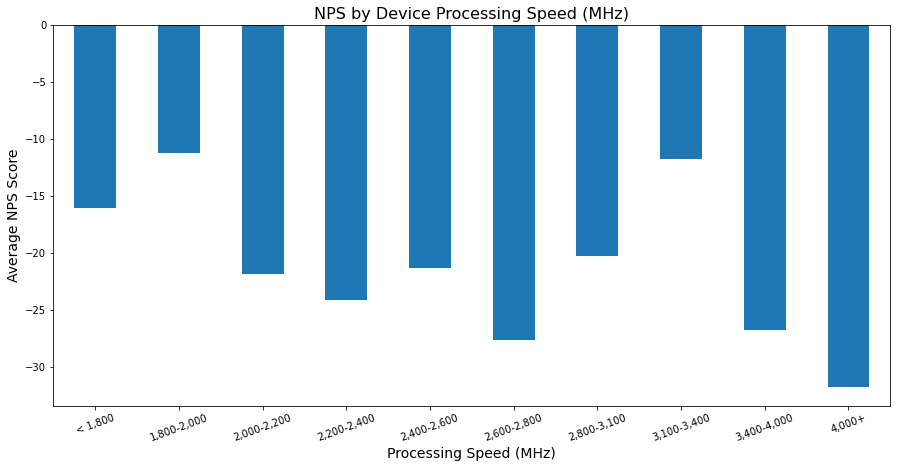

In [1625]:
plot_nums(app_compete_consumer_top_10_features, 'Device_ProcSpeedMHz', 'NPS by Device Processing Speed (MHz)', 'Processing Speed (MHz)',
         bins = [0, 1800, 2000, 2200, 2400, 2600, 2800, 3100, 3400, 4000, 4400],
          labels = ['< 1,800', '1,800-2,000', '2,000-2,200', '2,200-2,400', '2,400-2,600', '2,600-2,800', '2,800-3,100', '3,100-3,400', '3,400-4,000', '4,000+'], method = 'cut')

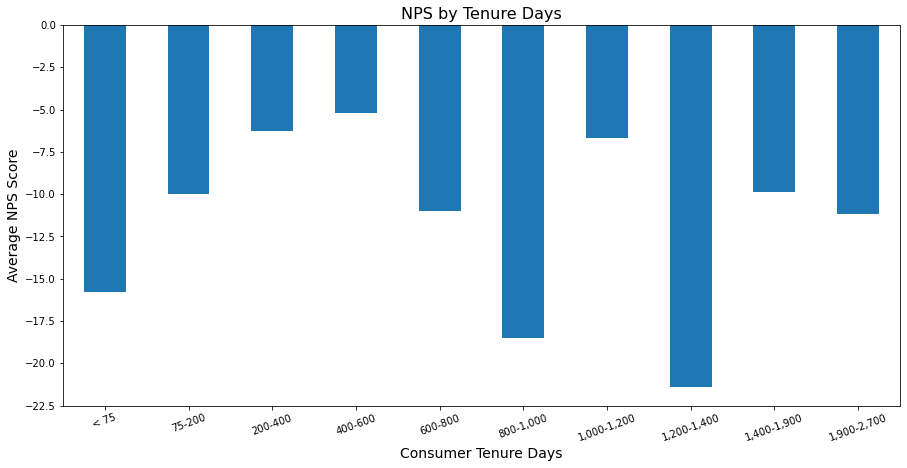

In [1623]:
plot_nums(app_compete_consumer_top_10_features, 'User_Consumer_TenureDays', 'NPS by Tenure Days', 'Consumer Tenure Days',
          bins = [0, 75, 200, 400, 600, 800, 1000, 1200, 1400, 1900, 2700],
          labels = ['< 75', '75-200', '200-400', '400-600', '600-800', '800-1,000', '1,000-1,200', '1,200-1,400', '1,400-1,900', '1,900-2,700'], method = 'cut')

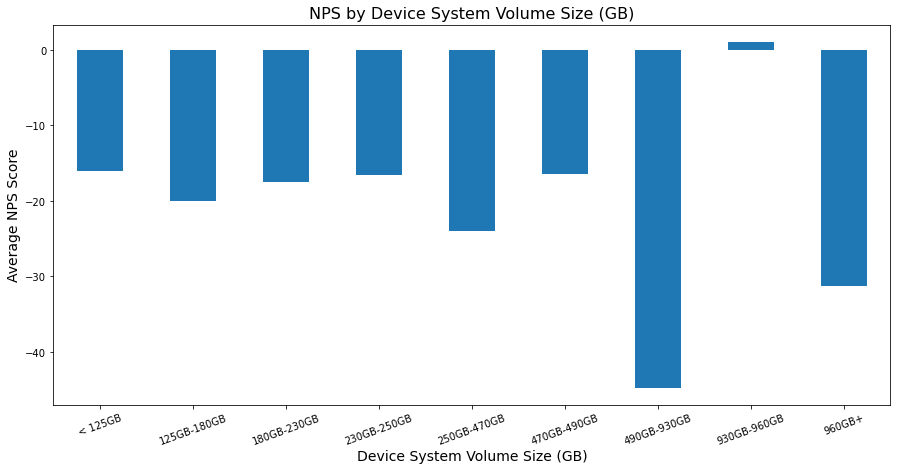

In [1622]:
plot_nums(app_compete_consumer_top_10_features, 'Device_SysVolSizeMB', 'NPS by Device System Volume Size (GB)', 'Device System Volume Size (GB)', 
         bins = [0, 125000, 180000, 230000, 250000, 470000, 490000, 930000, 960000, 4000000],
          labels = ['< 125GB', '125GB-180GB', '180GB-230GB', '230GB-250GB', '250GB-470GB', '470GB-490GB', '490GB-930GB', '930GB-960GB', '960GB+'], method = 'cut')

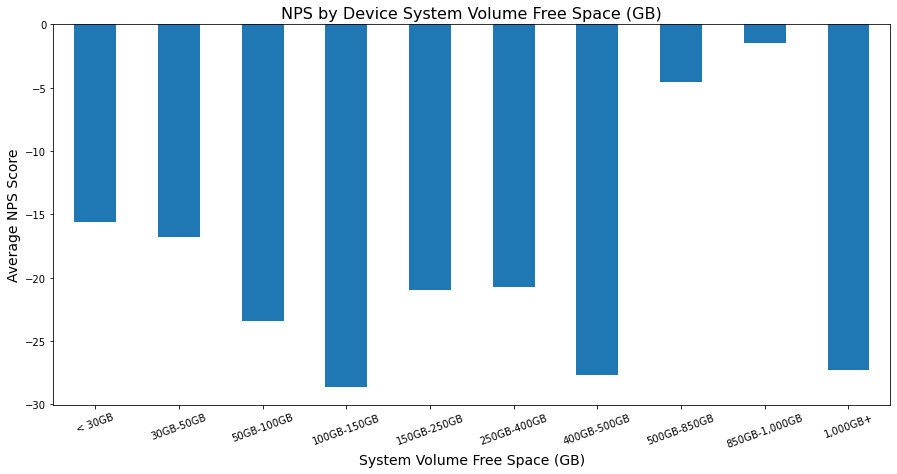

In [1621]:
plot_nums(app_compete_consumer_top_10_features, 'Device_SysVolFreeSpaceMB', 'NPS by Device System Volume Free Space (GB)', 
         'System Volume Free Space (GB)', bins = [0, 30000, 50000, 100000, 150000, 250000, 400000, 500000, 850000, 1000000, 4000000],
          labels = ['< 30GB', '30GB-50GB', '50GB-100GB', '100GB-150GB', '150GB-250GB', '250GB-400GB', '400GB-500GB', '500GB-850GB', '850GB-1,000GB',
                   '1,000GB+'], method = 'cut')

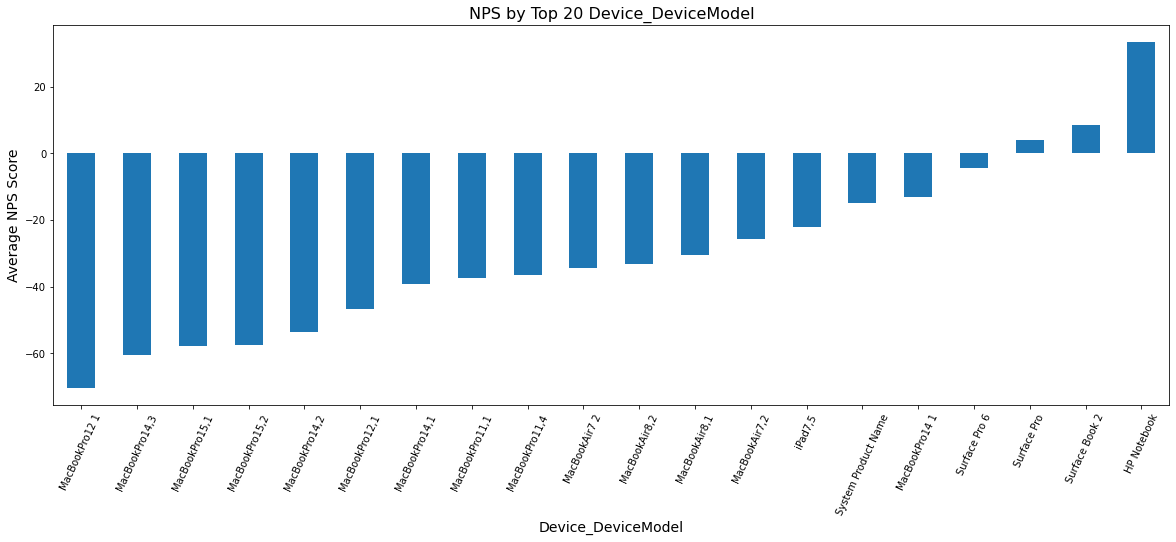

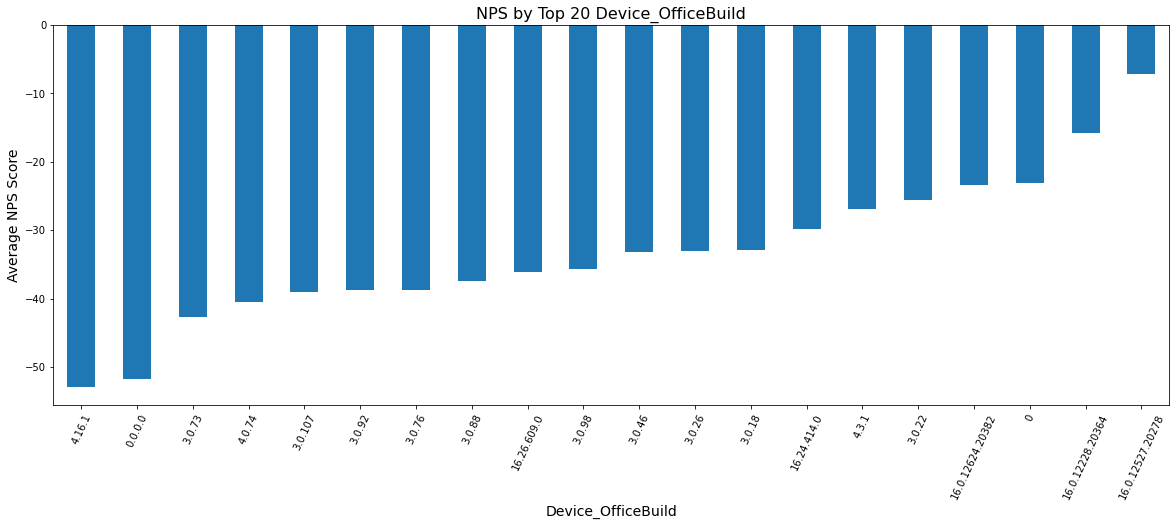

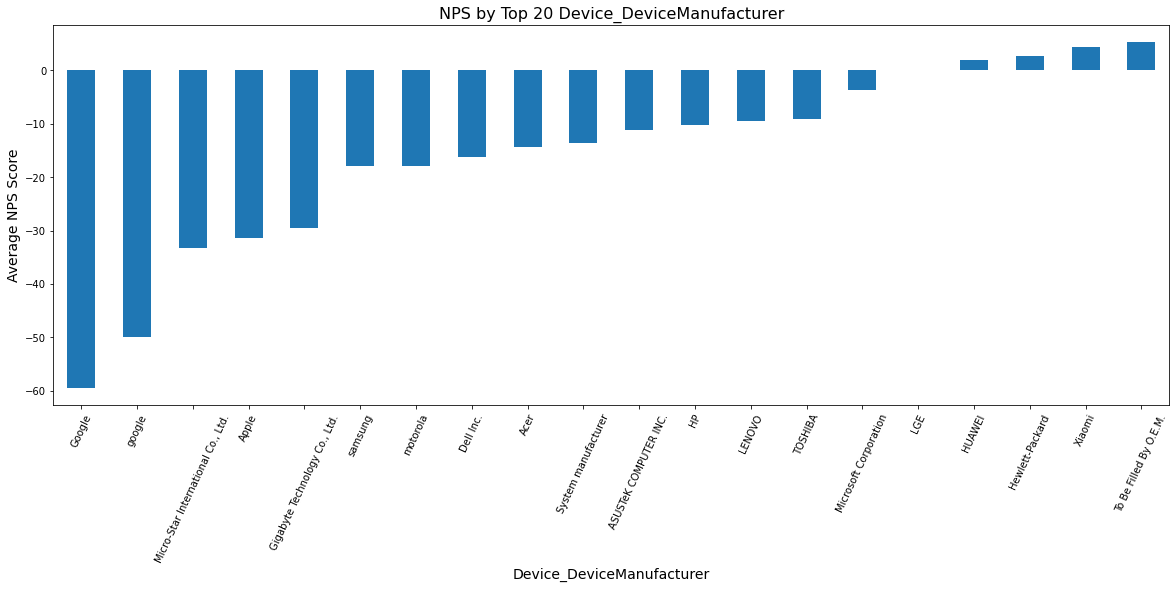

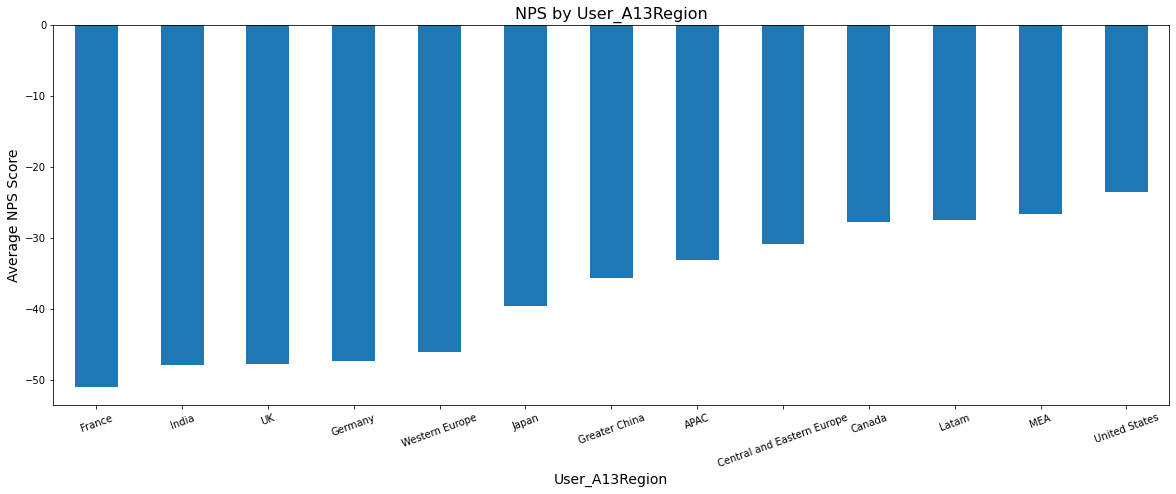

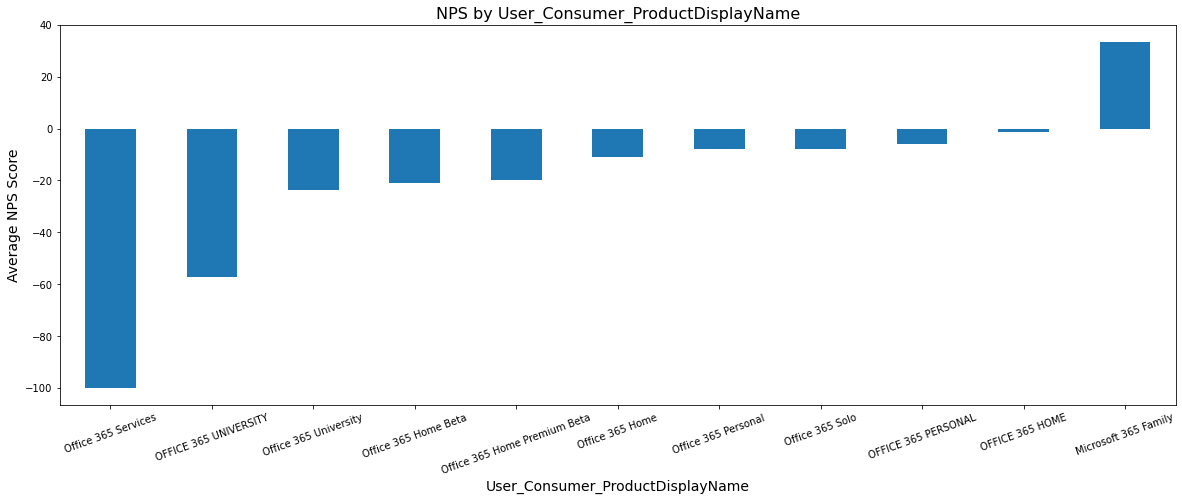

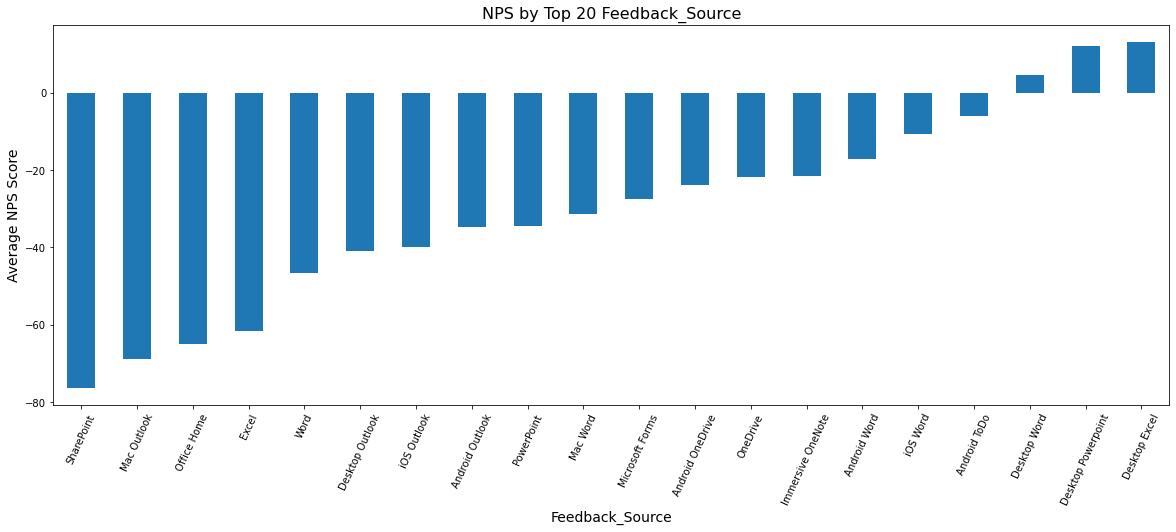

In [1591]:
plot_cats(app_compete_consumer_top_10_features)

### Top 10 App Compete Commercial Edu Features

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   13.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   59.6s
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  3.9min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  5.1min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  5.9min remaining:   22.7s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  6.1min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

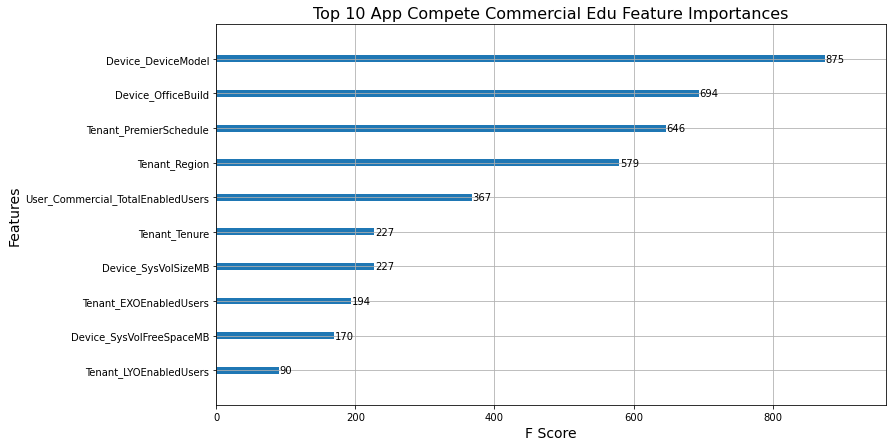

In [1586]:
app_compete_commercial_edu_feats, app_compete_commercial_edu_important_features_model = find_important_features(app_compete_commercial_edu_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                                app_compete_commercial_edu_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)


#plot the features
plt.figure(figsize = (12, 10))
ax = plot_importance(app_compete_commercial_edu_important_features_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 App Compete Commercial Edu Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

In [1626]:
app_compete_commercial_edu_top_10_features.dtypes

Device_DeviceModel                    object
Tenant_Region                         object
Device_OfficeBuild                    object
Tenant_PremierSchedule                object
Tenant_EXOEnabledUsers               float64
Tenant_LYOEnabledUsers               float64
Tenant_Tenure                        float64
Device_SysVolSizeMB                  float64
Device_SysVolFreeSpaceMB             float64
User_Commercial_TotalEnabledUsers    float64
Feedback_RatingValue                   int64
dtype: object

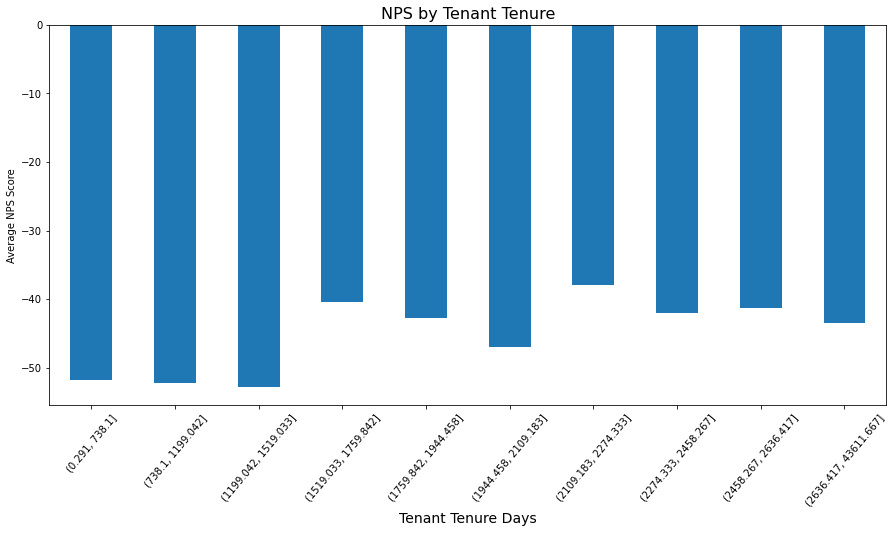

In [1633]:
plot_nums(app_compete_commercial_edu_top_10_features, 'Tenant_Tenure', 'NPS by Tenant Tenure', 'Tenant Tenure Days',
          bins = 10, method = 'qcut')

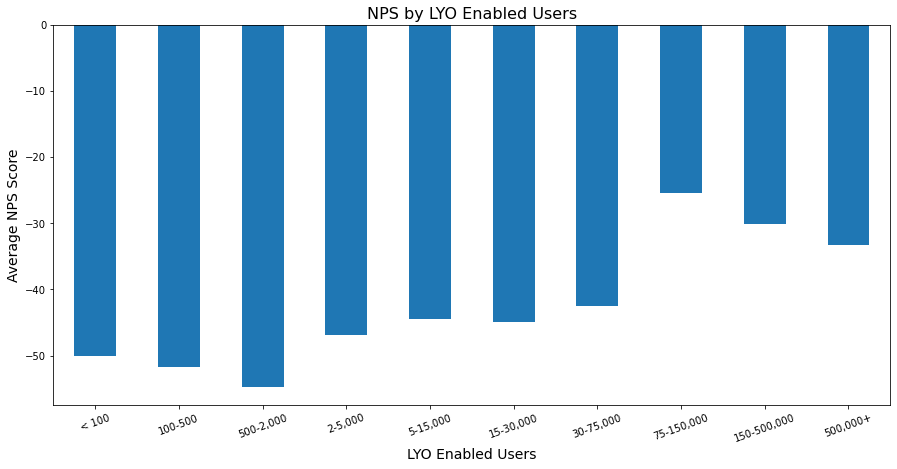

In [1630]:
plot_nums(app_compete_commercial_edu_top_10_features, 'Tenant_LYOEnabledUsers', 'NPS by LYO Enabled Users', 'LYO Enabled Users', 
         bins = [0, 100, 500, 2000, 5000, 15000, 30000, 75000, 150000, 500000, 100000000000],
          labels = ['< 100', '100-500', '500-2,000', '2-5,000', '5-15,000', '15-30,000', '30-75,000', '75-150,000', '150-500,000', '500,000+'], method = 'cut')

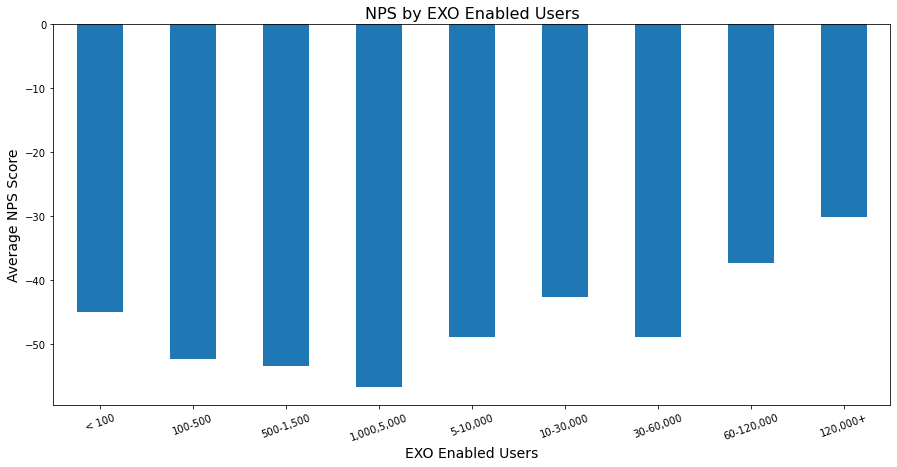

In [1628]:
plot_nums(app_compete_commercial_edu_top_10_features, 'Tenant_EXOEnabledUsers', 'NPS by EXO Enabled Users', 'EXO Enabled Users', 
          bins = [0, 100, 500, 1500, 5000, 10000, 30000, 60000, 120000, 100000000000],
          labels = ['< 100', '100-500', '500-1,500', '1,000,5,000', '5-10,000', '10-30,000', '30-60,000', '60-120,000', '120,000+'], method = 'cut')

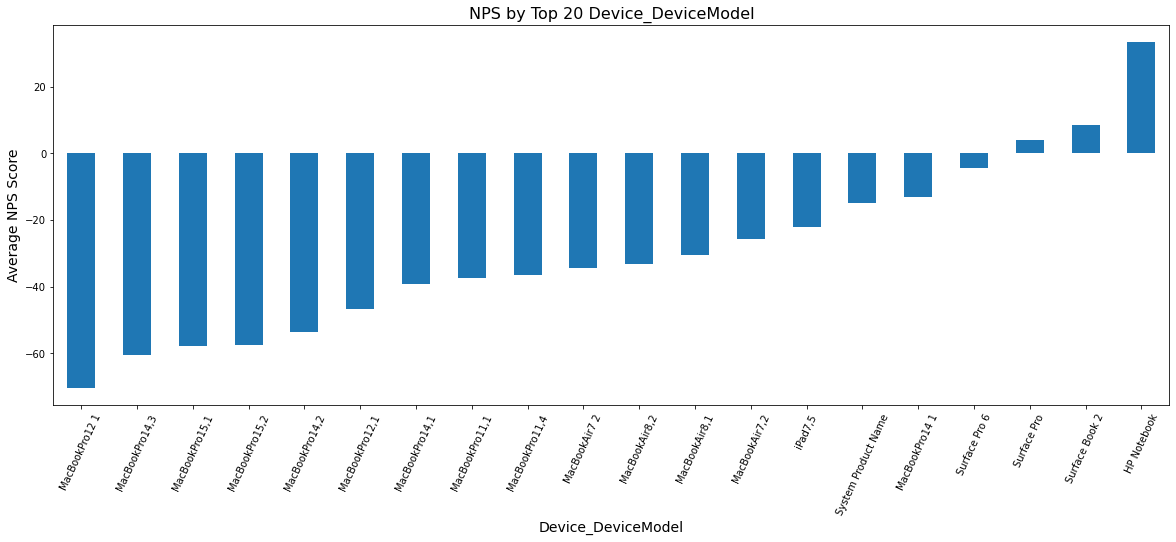

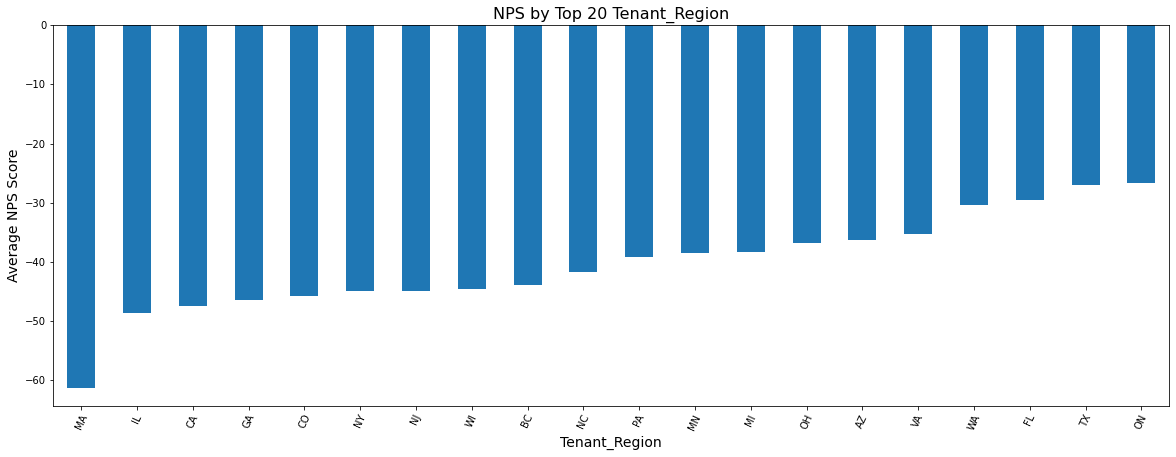

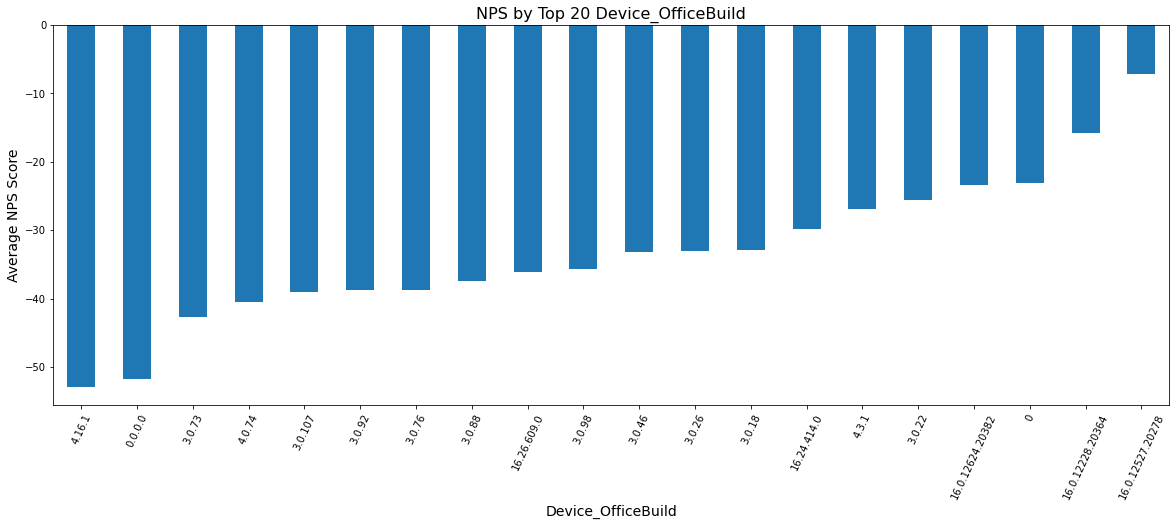

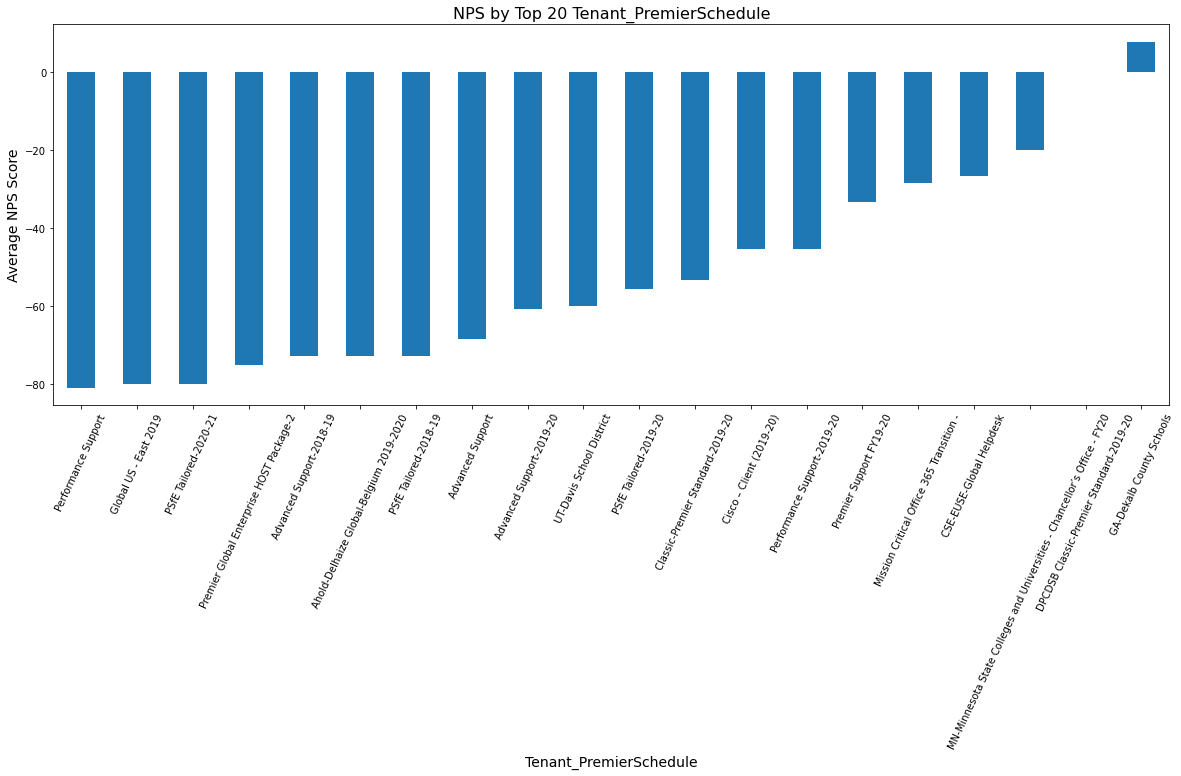

In [1592]:
plot_cats(app_compete_commercial_edu_top_10_features)

### Top 10 App Compete Commercial Non-Edu Features

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:  3.6min
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:  4.1min
[Parallel(n_jobs=-1)]: Done  41 out of  50 | elapsed:  5.0min remaining:  1.1min
[Parallel(n_jobs=-1)]: Done  47 out of  50 | elapsed:  7.9min remaining:   30.0s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  8.2min finished


Text(0, 0.5, 'Features')

<Figure size 864x720 with 0 Axes>

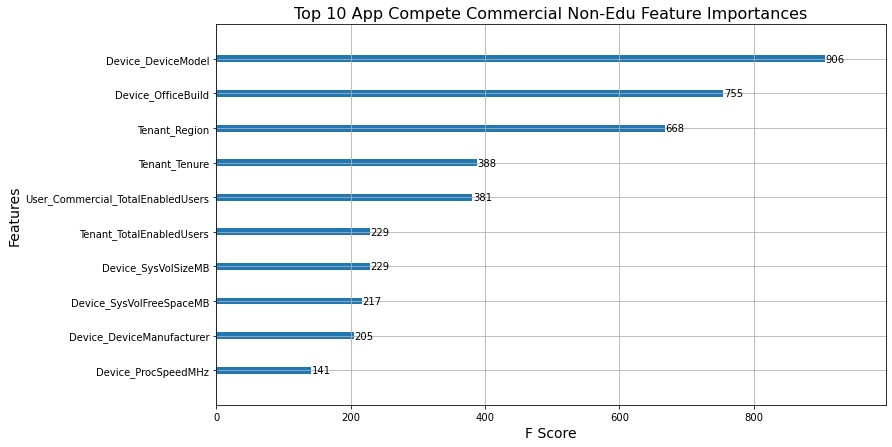

In [1587]:
app_compete_commercial_nonedu_feats, app_compete_commercial_nonedu_important_features_model = find_important_features(app_compete_commercial_nonedu_top_10_features.drop('Feedback_RatingValue', axis = 1),
                                                                                app_compete_commercial_nonedu_top_10_features['Feedback_RatingValue'], model = 'xgboost', encode = True)


#plot the features
plt.figure(figsize = (12, 10))
ax = plot_importance(app_compete_commercial_nonedu_important_features_model)
fig = ax.figure
fig.set_size_inches(12, 7)
plt.title('Top 10 App Compete Commercial Non-Edu Feature Importances', fontsize = 16)
plt.xlabel('F Score', fontsize = 14)
plt.ylabel('Features', fontsize = 14)

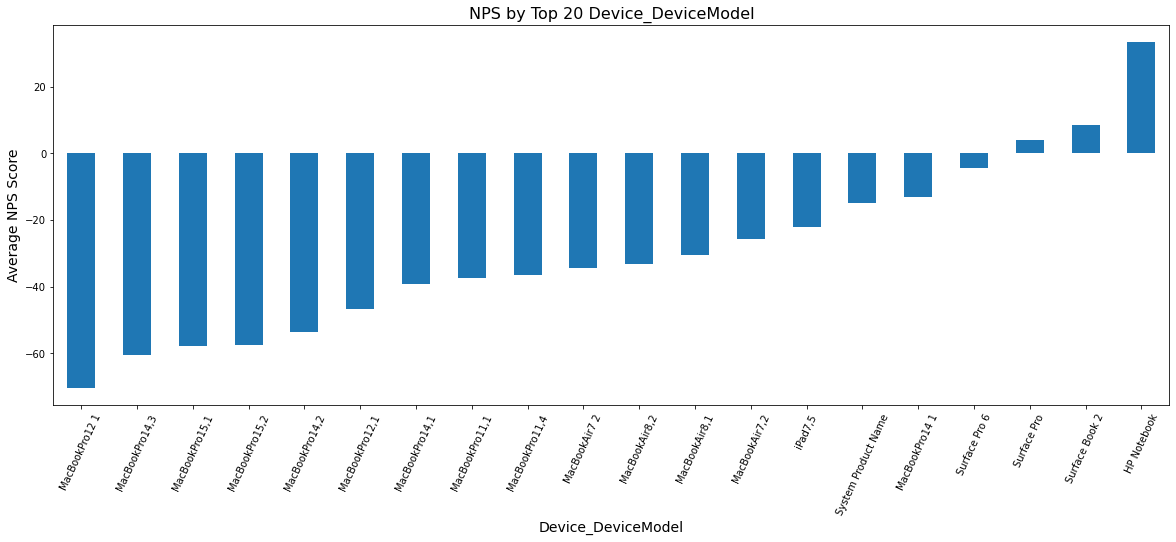

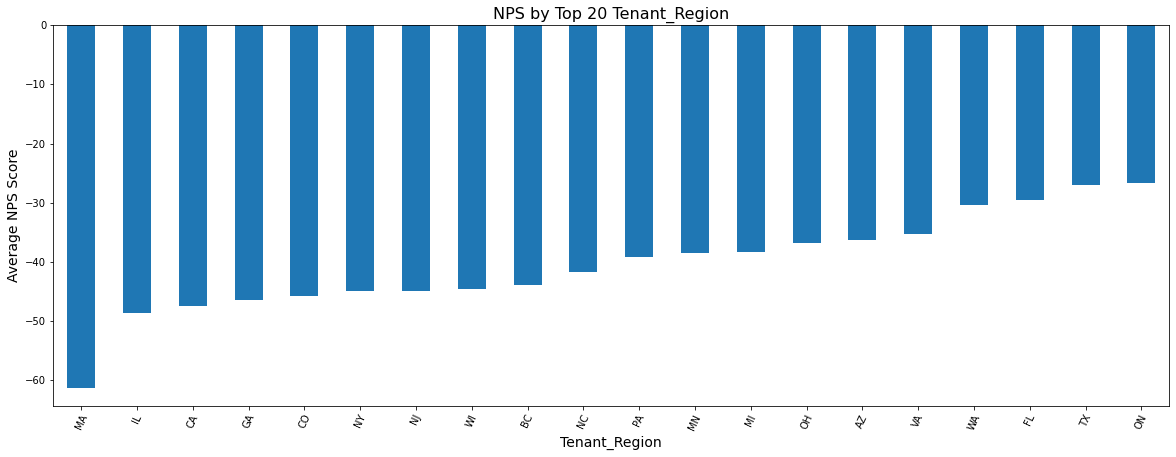

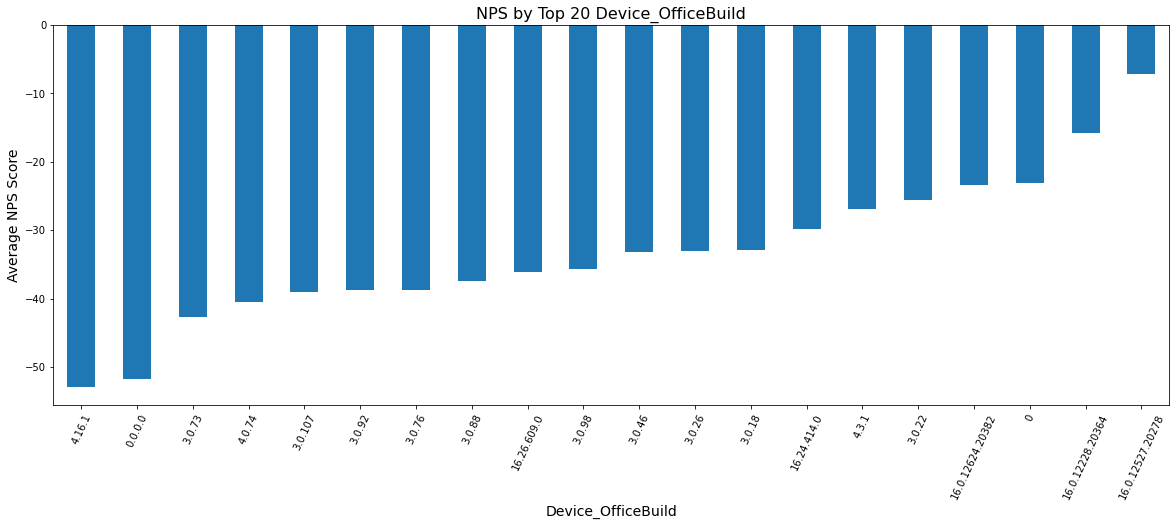

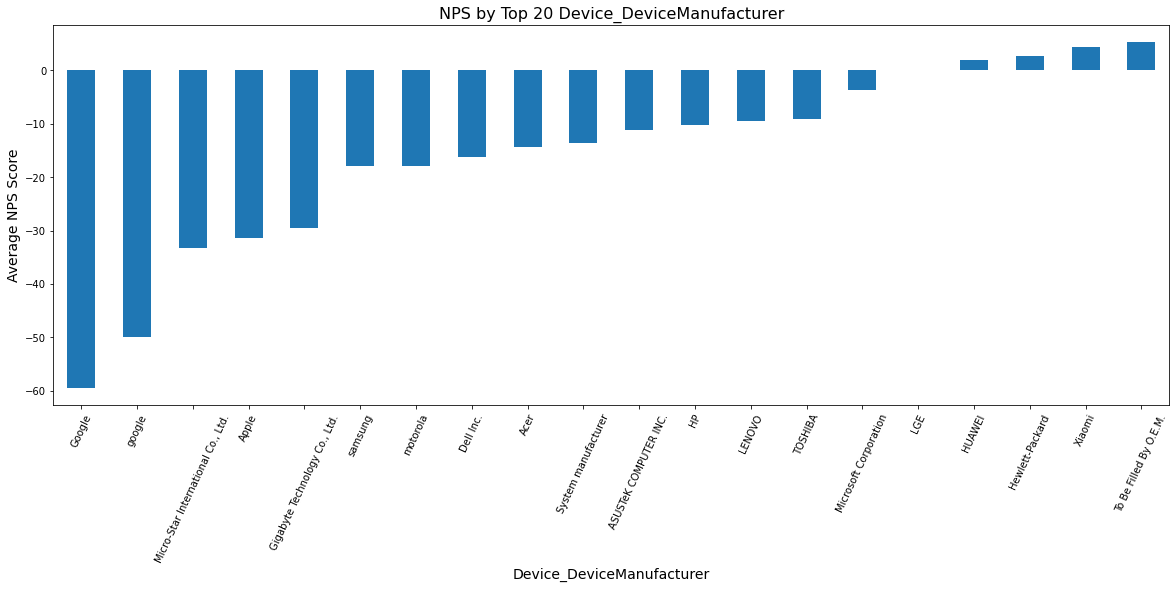

In [1593]:
plot_cats(app_compete_commercial_nonedu_top_10_features)

# Overall NPS Trend Plots
- Be sure to use colorblind appropriate palettes

In [447]:
#set this color palette that is colorblind safe
sns.set_palette("Set2")

In [396]:
#convert feedback date to datetime feature so that we can access dt accessories
dfs = [app, suite]

app.rename(columns = {'Feedback_DateTime_x':'Feedback_DateTime'}, inplace = True)

for df in dfs:
    
    app_cost = app[app['NgramThemePredictions'] == 'cost']
    
    app_compete = app[app['NgramThemePredictions'] == 'compete']
    
    suite_cost = suite[suite['NgramThemePredictions'] == 'cost']
    
    suite_compete = suite[suite['NgramThemePredictions'] == 'compete']
    
    suite_and_app = [app_cost, app_compete, suite_cost, suite_compete]
    
    for df in suite_and_app:
        
        for col in df.columns:
            
            try:
                
                if col == 'Feedback_DateTime':
                
                    df.rename(columns = {'Feedback_DateTime_x':'Feedback_DateTime'}, inplace = True)
                
                    df[col] = pd.to_datetime(df[col])
            except:
                
                df[col] = pd.to_datetime(df[col])
           

C:\Users\fulto\anaconda3\lib\site-packages\pandas\core\frame.py:4133: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,
C:\Users\fulto\anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


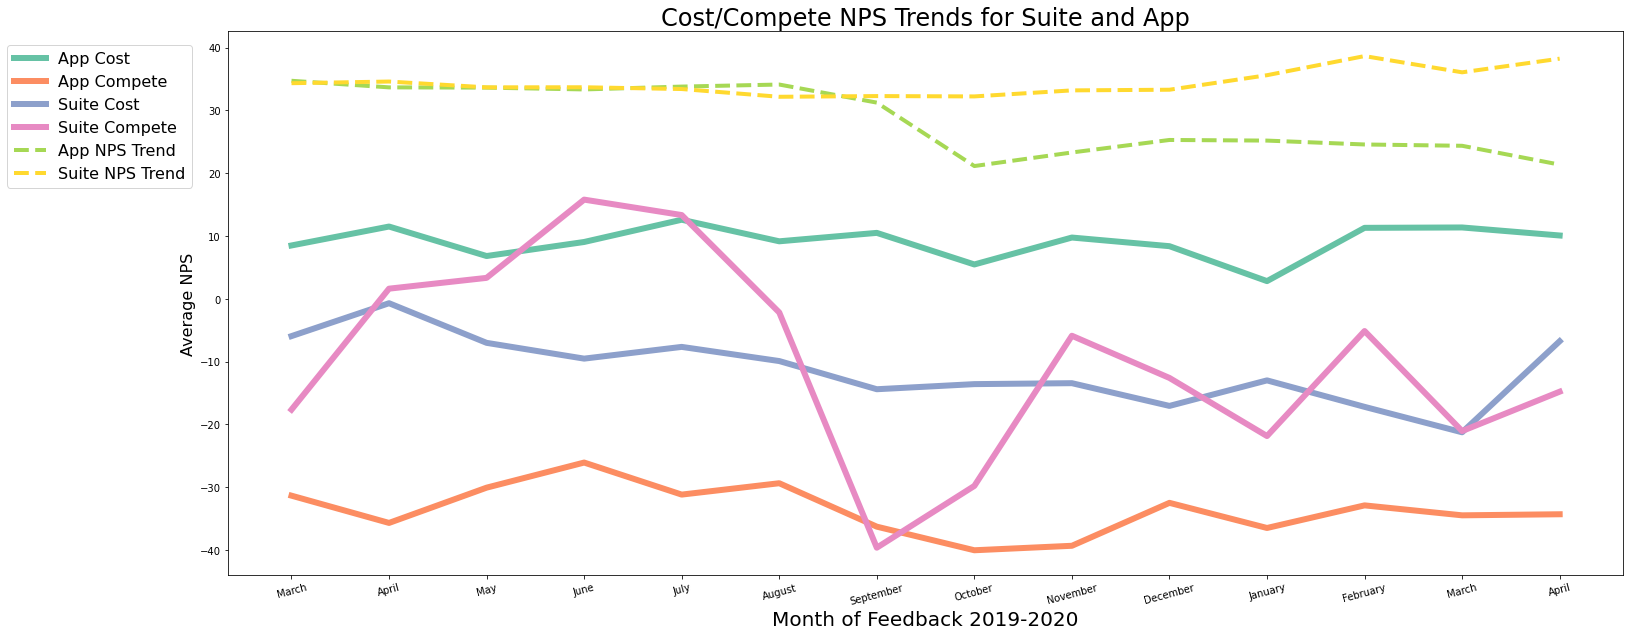

In [402]:
os.chdir('C:\\Users\\fulto\\Desktop\\Driver Analysis\\Suite and App')
app_nps = pd.read_csv('App_Combined_NPS_Trend.csv')
suite_nps = pd.read_csv('Suite_NPS_Trend.csv')

#plot all trend lines for cost and compete
for df in [app_cost, app_compete, suite_cost, suite_compete]:
    ax = df.groupby([df['Feedback_DateTime'].dt.year, df['Feedback_DateTime'].dt.month]).Feedback_RatingValue.mean().plot(figsize = (25, 10), linewidth = 6, color = cmap)
    
ax = app_nps['Avg_App_NPS'].plot(linestyle = '--', linewidth = 4)
ax = suite_nps['Avg_NPS'].plot(linestyle = '--', linewidth = 4)
plt.title('Cost/Compete NPS Trends for Suite and App', fontsize = 24)
plt.legend(labels = ['App Cost', 'App Compete', 'Suite Cost', 'Suite Compete', 'App NPS Trend', 'Suite NPS Trend'], fontsize = 16, bbox_to_anchor = (-0.02,.99))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 
                                                           'February', 'March', 'April'])
plt.xlabel('Month of Feedback 2019-2020', fontsize = 20)
plt.ylabel('Average NPS', fontsize = 16)
plt.xticks(rotation = 15);

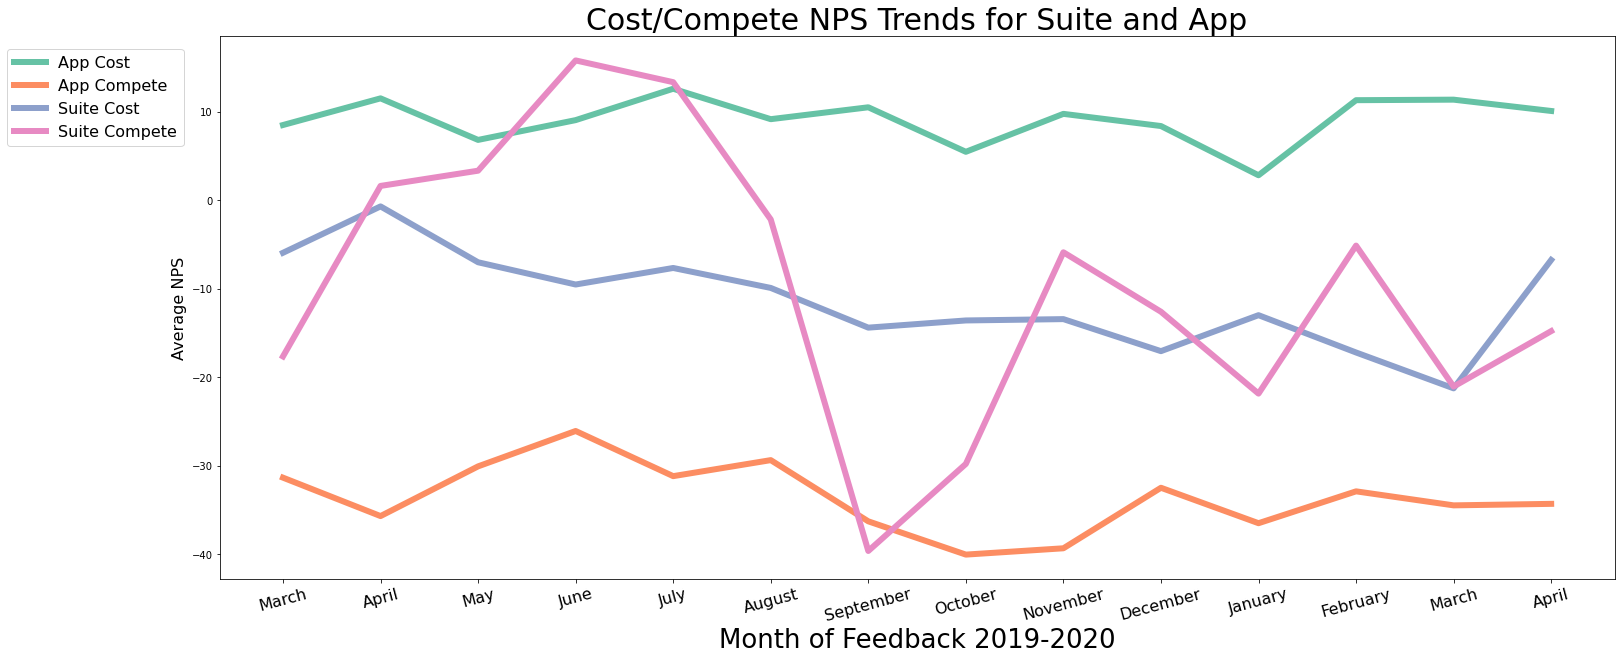

In [428]:
#plot all trend lines for cost and compete -- without overall trends
for df in [app_cost, app_compete, suite_cost, suite_compete]:
    ax = df.groupby([df['Feedback_DateTime'].dt.year, df['Feedback_DateTime'].dt.month]).Feedback_RatingValue.mean().plot(figsize = (25, 10), linewidth = 6)
plt.title('Cost/Compete NPS Trends for Suite and App', fontsize = 30)
plt.legend(labels = ['App Cost', 'App Compete', 'Suite Cost', 'Suite Compete', 'App NPS Trend'], fontsize = 16, bbox_to_anchor = (-0.02,.99))
plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 
                                                           'February', 'March', 'April'], fontsize = 16)
plt.xlabel('Month of Feedback 2019-2020', fontsize = 26)
plt.ylabel('Average NPS', fontsize = 16)
plt.xticks(rotation = 15);

# Create Consumer, Commercial NPS Trend Plots

In [442]:
#convert all these dates to datetime
app_dfs = [app_cost_consumer, app_cost_commercial_e, app_cost_commercial_n, app_compete_consumer, app_compete_commercial_e, app_compete_commercial_n]
suite_dfs  = [suite_cost_consumer, suite_cost_commercial_edu, suite_cost_commercial_nonedu, suite_compete_consumer, suite_compete_commercial_edu, suite_compete_commercial_nonedu]


for df in app_dfs:
    for col in df.columns:
        if col == 'Feedback_DateTime':
            df[col] = pd.to_datetime(df[col])
for df in suite_dfs:
    for col in df.columns:
        if col == 'Feedback_DateTime':
            df[col] = pd.to_datetime(df[col])

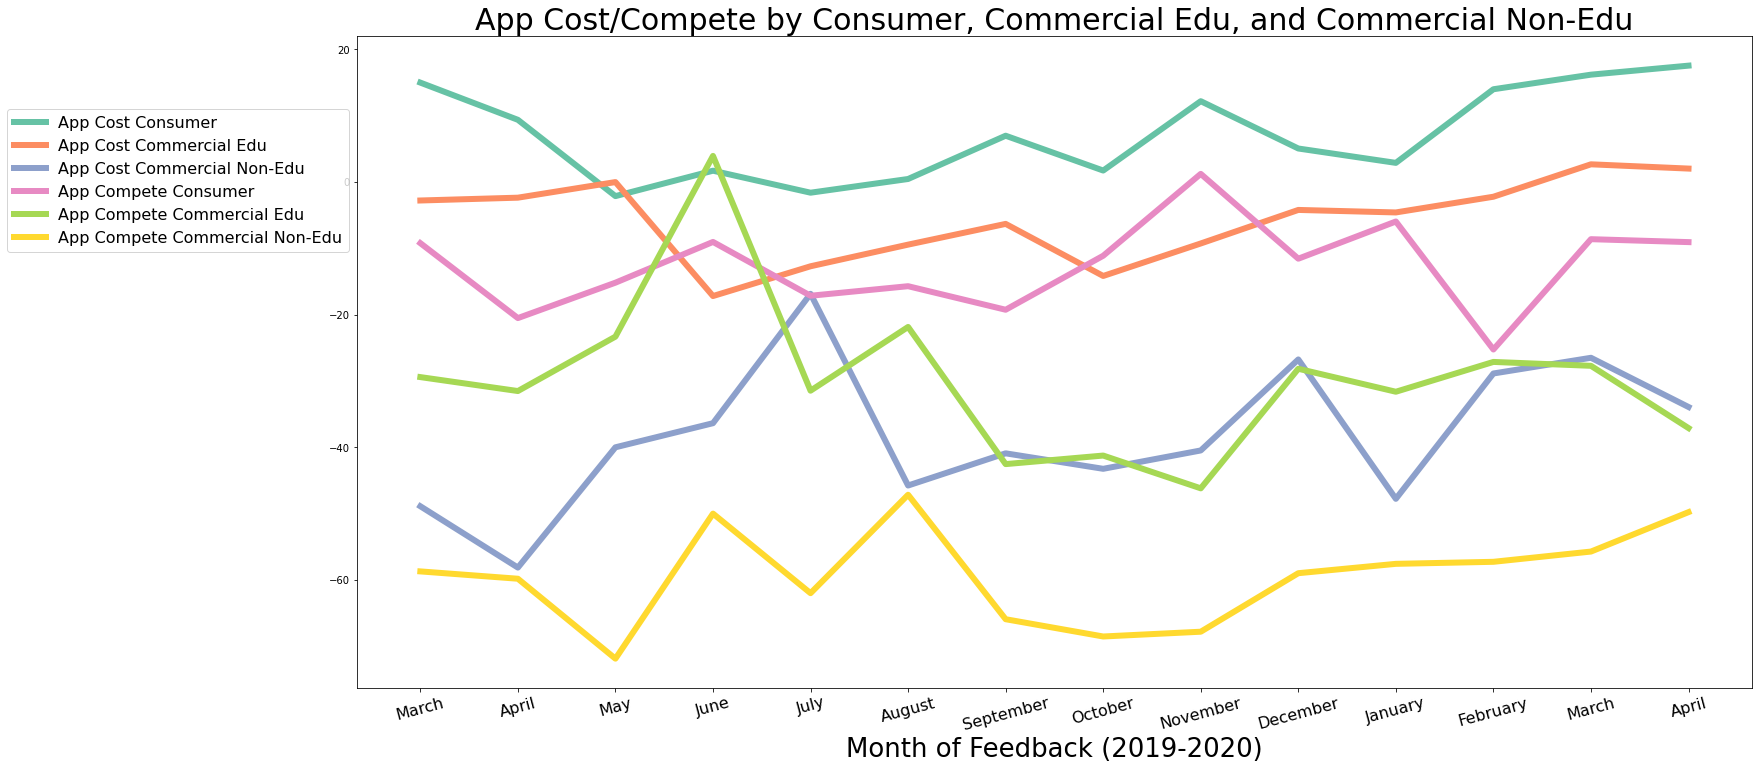

In [485]:
for df in app_dfs:
    df.groupby([df['Feedback_DateTime'].dt.year, df['Feedback_DateTime'].dt.month])['Feedback_RatingValue'].mean().plot(figsize = (25,12), linewidth = 6)

plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 
                                                           'February', 'March', 'April'], fontsize = 16, rotation = 15)
plt.title('App Cost/Compete by Consumer, Commercial Edu, and Commercial Non-Edu', fontsize = 30)
plt.legend(labels = ['App Cost Consumer', 'App Cost Commercial Edu', 'App Cost Commercial Non-Edu', 'App Compete Consumer', 'App Compete Commercial Edu', 
                     'App Compete Commercial Non-Edu'], fontsize = 16, bbox_to_anchor = (0, .9))
plt.xlabel('Month of Feedback (2019-2020)', fontsize = 26);

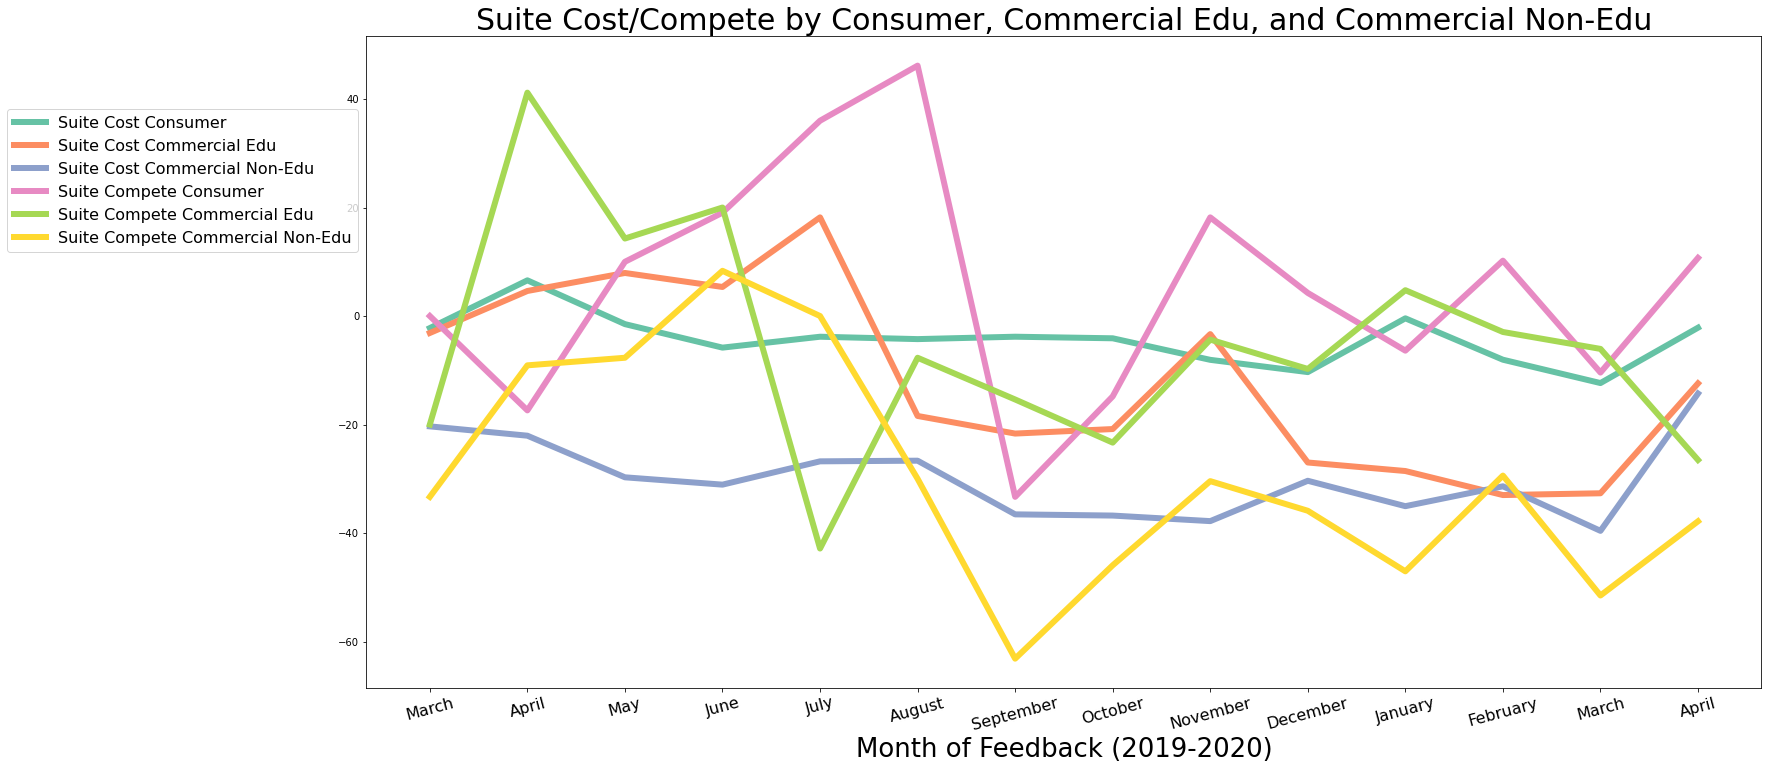

In [486]:
for df in suite_dfs:
    df.groupby([df['Feedback_DateTime'].dt.year, df['Feedback_DateTime'].dt.month])['Feedback_RatingValue'].mean().plot(figsize = (25,12), linewidth = 6)


plt.xticks([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13], ['March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December', 'January', 
                                                           'February', 'March', 'April'], fontsize = 16, rotation = 15)
plt.title('Suite Cost/Compete by Consumer, Commercial Edu, and Commercial Non-Edu', fontsize = 30)
plt.legend(labels = ['Suite Cost Consumer', 'Suite Cost Commercial Edu', 'Suite Cost Commercial Non-Edu', 'Suite Compete Consumer', 'Suite Compete Commercial Edu', 
                     'Suite Compete Commercial Non-Edu'], fontsize = 16, bbox_to_anchor = (0, .9))
plt.xlabel('Month of Feedback (2019-2020)', fontsize = 26);